In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandapower as pp
from pandapower.networks import case14, case_ieee30, case118, case300, case4gs
from gekko import GEKKO
from pandapower.plotting.plotly import pf_res_plotly
import pandapower.plotting as pplot
from msc_rafael_pavan import otimizacao_pso_discreto_sengi
from msc_rafael_pavan import inicializa_sep
from msc_rafael_pavan import matriz_condutancia
from msc_rafael_pavan import coleta_dados_vbus
from msc_rafael_pavan import coleta_dados_gen
from msc_rafael_pavan import func_objetivo
from msc_rafael_pavan import pen_tensao
from msc_rafael_pavan import pen_ger_reativo
from msc_rafael_pavan import coleta_dados_trafo
from msc_rafael_pavan import pen_trafo
from msc_rafael_pavan import coleta_dados_bshunt
from msc_rafael_pavan import converte_trafo
from msc_rafael_pavan import cria_alcateia
from msc_rafael_pavan import cria_enxame
from msc_rafael_pavan import pen_bshunt
from msc_rafael_pavan import fluxo_de_pot
from msc_rafael_pavan import fitness
from msc_rafael_pavan import validacao
from msc_rafael_pavan import validacao_q
from msc_rafael_pavan import fluxo_de_pot_q

from msc_rafael_pavan import otimizacao_gwo_continuo
from msc_rafael_pavan import otimizacao_pso_continuo
from msc_rafael_pavan import discreto_bshunt
from msc_rafael_pavan import discreto_tap
from msc_rafael_pavan import otimizacao_gwo_discreto
from msc_rafael_pavan import otimizacao_pso_discreto
from msc_rafael_pavan import ipm_ieee30
from msc_rafael_pavan import ipm_ieee14
from msc_rafael_pavan import cria_enxame_v
import copy

from numba import jit
import time

sep_14 = case14()
sep_118 = case118()
sep_30 = case_ieee30()
sep_300 = case300()
v_init30 = inicializa_sep(sep_30,algorithm='fdbx', relatorio=False)
v_init14 = inicializa_sep(sep_14,algorithm='fdbx', relatorio=False)
sep_118 = case118()
v_init118 = inicializa_sep(sep_118,algorithm='fdbx', relatorio=False)

v_init300 = inicializa_sep(sep_300,algorithm='fdbx', relatorio=False)


In [37]:
def balanco_potencia_ativa(sep,pg_sgen,pg, pc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, tap, bkmt,gkmt,pshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(33333333)
    baux.append(33333331)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        soma = soma + gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(gkm_linhas[posi]*(tensoes[barra_atual]**2) - tensoes[barra_atual]*tensoes[bd]*(gkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]/tap[posi]**2 - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + (gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual]  - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
    
        fluxos.append(gkmt[posi]*tensoes[barra_atual]*tensoes[barra_atual] - (tensoes[barra_atual]*tensoes[bd]/tap[posi])*(gkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-bkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))

    return  pg[barra_atual] - pc[barra_atual] - soma + pg_sgen[barra_atual] - pshunt[barra_atual]*tensoes[barra_atual]**2

In [38]:
def balanco_potencia_reativa(sep,qg, qc, barras_origem, barras_destino, barra_atual, gkm_linhas, bkm_linhas, tensoes, angulos, to, td, tap, bkmt,gkmt, bshl, bsht,qshunt):
    
    soma = 0
    
    fluxos = []
    
    linhas = np.arange(0,len(barras_origem),1)
    
    baux = []
    baux.append(10101010101)
    baux.append(1000101010)
    
    for bd in barras_destino[barras_origem==barra_atual]:
        
        baux.append(bd)
        posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][0]
        
        if baux[-2]==bd:
            
#             print(linhas[(barras_destino==bd) & (barras_origem==barra_atual)],'aaaaaaaaaa')
            posi = linhas[(barras_destino==bd) & (barras_origem==barra_atual)][1]
            
#         print(bd,'vai linha')
#         print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in barras_origem[barras_destino==barra_atual]:
        
        posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][0]
        
        baux.append(bd)
        
        if baux[-2]==bd:
#             print(linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1],'aaaaaaaaaa')
            posi = linhas[(barras_destino==barra_atual) & (barras_origem==bd)][1]
        
#         print(bd,'volta linha')
#         print(posi)
        
        soma = soma + -(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkm_linhas[posi]+bshl[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*tensoes[bd]*(-bkm_linhas[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkm_linhas[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    linhas = np.arange(0,len(to),1)
    
    for bd in td[to==barra_atual]:
        
        posi = linhas[(td==bd) & (to==barra_atual)][0]
#         print(bd,'vai trafo')
#         print(posi)
        soma = soma + -(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]/(tap[posi]**2)+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    for bd in to[td==barra_atual]:
        
        posi = linhas[(td==barra_atual) & (to==bd)][0]
#         print(bd,'volta trafo')
#         print(posi)
        soma = soma + -(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd]))
        fluxos.append(-(-bkmt[posi]+bsht[posi]/2)*tensoes[barra_atual]**2+tensoes[barra_atual]*(1/tap[posi])*tensoes[bd]*(-bkmt[posi]*sep.cos(angulos[barra_atual]-angulos[bd])-gkmt[posi]*sep.sin(angulos[barra_atual]-angulos[bd])))
        
    return  qg[barra_atual] - qc[barra_atual] - soma - qshunt[barra_atual]*tensoes[barra_atual]**2

In [39]:
def perdas(sep,gkml, gkmt, angulos, tensoes, tap, origem, destino, hv, lv):
    
    i = 0
    
    eq = []
 
    for bus in zip(origem,destino):
        
        
        perdas = gkml[i]*(tensoes[bus[0]]**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*sep.cos(angulos[bus[0]]-angulos[bus[1]]))
        i=i+1
        
        eq.append(perdas)
    
    j = 0
    

    
    for bus in zip(hv,lv):
        
        perdas = gkmt[j]*((tensoes[bus[0]]/tap[j])**2 + tensoes[bus[1]]**2 - 2*tensoes[bus[1]]*tensoes[bus[0]]*(1/tap[j])*sep.cos(angulos[bus[0]]-angulos[bus[1]]))
        
        eq.append(perdas)
            
        j=j+1
        
    return perdas, eq
    

In [40]:
def voltage_dev(tensoes):
    
    
    sum_dev = 0
    
    for tensao in tensoes:
        dev = (1-tensao)**2

        sum_dev = dev + sum_dev
        
    return sum_dev


In [2]:
def automatiza_ipm_c(sep_teste, verbose=True, travado=False):
    
    
    sep14 = copy.copy(sep_teste) 
    sep14.res_line = sep14.res_line.sort_index()
    sep14.line = sep14.line.sort_index()
    origem = sep14.line[['from_bus']].values
    destino = sep14.line[['to_bus']].values
    
        ########################################################################### Vetores de condutância e susceptância série

    m_z = np.zeros((5,len(sep14.line)))

    gkm = np.zeros(len(sep14.line))

    bkm = np.zeros(len(sep14.line))

    bo = np.zeros(len(sep14.line))

    bd = np.zeros(len(sep14.line))

    sep14.line = sep14.line.sort_index()

    sep14.bus = sep14.bus.sort_index()

    vbus = sep14.bus.vn_kv.to_numpy(dtype=np.float64)

    zbase = np.power(np.multiply(vbus,1000), 2)/(100*1e6)

    m_z[0,:] = sep14.line.from_bus.to_numpy()

    m_z[1,:] = sep14.line.to_bus.to_numpy()

    bsh = 1e-9*(2*np.pi*60*sep14.line.c_nf_per_km.to_numpy())

    m_z[4,:] = bsh


    for i in range(len(sep14.line.index.ravel())):    

        m_z[2,i] = sep14.line.r_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[3,i] = sep14.line.x_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[4,i] =  m_z[4,i] * zbase[int(m_z[0,i])]


    gkm = np.array(np.divide(m_z[2,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))

    bo = m_z[0,:]

    bd = m_z[1,:]

    ########################################################################### Vetor de susceptância

    bkm = np.array(np.divide(m_z[3,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))


    ########################################################################### Vetor de susceptância shunt

    bsh = m_z[4,:]
    

    
    sep14.trafo = sep14.trafo.sort_index()

    barras = sep14.trafo['hv_bus'].to_numpy()
    
    zkm = (sep14.trafo['vk_percent'].to_numpy()/100)*(1000/sep14.trafo['sn_mva'].to_numpy())
    
    rkm = (sep14.trafo['vkr_percent'].to_numpy()/100)*(1000/sep14.trafo['sn_mva'].to_numpy())
    
    #a = (sep14.trafo['vn_lv_kv'].to_numpy()*sep14.trafo['vn_lv_kv'].to_numpy()*1000/sep14.trafo['sn_mva'].to_numpy())/(sep14.trafo['vn_lv_kv'].to_numpy()*sep14.trafo['vn_lv_kv'].to_numpy()/1000)
    
    a = 1
    
    zkm=zkm/10
    
    rkm=rkm/10
    
    xkm = np.sqrt(zkm**2-rkm**2)
    

#     xkm[91] = 0.0231
        
    gkmt = (rkm*a/((a*rkm)**2+(a*xkm)**2))
    
    bkmt = (xkm*a/((a*rkm)**2+(a*xkm)**2))
    
    bsht = np.sqrt(np.power(sep14.trafo['i0_percent'].to_numpy()/100,2))
    
    bsht = bsht*99
    
    print(bsht)
    

        ########################################################################### Vetor de tap

    tap_pos = sep14.trafo[~pd.isnull(sep14.trafo['tap_pos'])]['tap_pos'].to_numpy(dtype=np.float64)

    tap_neutral = sep14.trafo[~pd.isnull(sep14.trafo['tap_neutral'])]['tap_neutral'].to_numpy(dtype=np.float64)

    tap_step_percent = sep14.trafo[~pd.isnull(sep14.trafo['tap_step_percent'])]['tap_step_percent'].to_numpy(dtype=np.float64)

    valor_percentual = (tap_pos-tap_neutral)*(tap_step_percent/100) + 1

#     valor_percentual = np.resize(valor_percentual,(len(sep14.trafo)))


    to = np.zeros(len(sep14.trafo))
    td = np.zeros(len(sep14.trafo))
    
    for i in range(len(sep14.trafo)):
        
        if sep14.trafo['tap_side'].iloc[i] == None or sep14.trafo['tap_side'].iloc[i] == 'hv':
        
            to[i] = int(sep14.trafo['hv_bus'].iloc[i])


            td[i] = int(sep14.trafo['lv_bus'].iloc[i])

        if sep14.trafo['tap_side'].iloc[i] == 'lv':
        
            to[i] = int(sep14.trafo['lv_bus'].iloc[i])


            td[i] = int(sep14.trafo['hv_bus'].iloc[i])
            
    to = to.astype(int)
    td = td.astype(int)

    i = 0

    for i in range(len(valor_percentual)):

        if i < len(tap_pos):

            valor_percentual[i] = valor_percentual[i]

        else:

            valor_percentual[i] = 1


    tap = valor_percentual
    
    sep14.trafo['tap_pos'][~pd.isnull(sep14.trafo['tap_pos'])] = valor_percentual
    sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_pos'])] = 1
    
    tap = sep14.trafo['tap_pos'].values
    
    
    ########################################################################### Vetor de tensões das barras
    sep14.line = sep14.line.sort_index()

    sep14.res_bus = sep14.res_bus.sort_index()
    
    sep14.sgen = sep14.sgen.sort_index()

    v = sep14.res_bus['vm_pu'].to_numpy()
    Sbase=100
    ########################################################################### Vetor de ângulos das barras

    theta = np.radians(sep14.res_bus['va_degree'].to_numpy())

    ########################################################################### Vetor de potência ativa gerada
    sep14.gen = sep14.gen.sort_index()
    
    pg = np.zeros(len(sep14.bus))
    
    pg_sgen = np.zeros(len(sep14.bus))
    qg_sgen = np.zeros(len(sep14.bus))
    
    i = 0

    sep14.gen = sep14.gen.sort_index()

    sep14.res_gen = sep14.res_gen.sort_index()

    for bus in sep14.gen['bus'].to_numpy():

        pg[bus] = sep14.gen['p_mw'].to_numpy()[i]/Sbase
        
        i=i+1
        

    i=0
    
    qg = np.zeros(len(pg))
    
    for bus in sep14.sgen['bus'].to_numpy():
        
        pg_sgen[bus] = sep14.sgen['p_mw'].to_numpy()[i]/Sbase
        
        qg_sgen[bus] = sep14.sgen['q_mvar'].to_numpy()[i]/Sbase

        i = i+1
    
    if len(sep14.bus)==118:

        pg[68] = sep14.res_ext_grid['p_mw'].to_numpy()/100
        qg[68] = sep14.res_ext_grid['q_mvar'].to_numpy()/100
        
    if len(sep14.bus)==300:

        pg[256] = sep14.res_ext_grid['p_mw'].to_numpy()/100
        qg[256] = sep14.res_ext_grid['q_mvar'].to_numpy()/100
        
    if len(sep14.bus)==14 or len(sep14.bus)==30 :

        pg[0] = sep14.res_ext_grid['p_mw'].to_numpy()/100

    pg_ls = sep14.ext_grid['max_p_mw'].to_numpy()/100

    pg_li = sep14.ext_grid['min_p_mw'].to_numpy()/100
    
    sep14.load = sep14.load.sort_index()
    pc = np.zeros(len(sep14.bus))

    i = 0

    sep14.load = sep14.load.sort_index()

    for bus in sep14.load['bus'].to_numpy():

        pc[bus] = sep14.load['p_mw'].to_numpy()[i]/Sbase

        i=i+1

    qc = np.zeros(len(sep14.bus))

    i = 0

    for bus in sep14.load['bus'].to_numpy():

        qc[bus] = sep14.load['q_mvar'].to_numpy()[i]/Sbase

        i=i+1


########################################################################### Vetores de condutância e susceptância série

    m_z = np.zeros((5,len(sep14.line)))

    gkm = np.zeros(len(sep14.line))

    bkm = np.zeros(len(sep14.line))

    bo = np.zeros(len(sep14.line))

    bd = np.zeros(len(sep14.line))

    sep14.line = sep14.line.sort_index()

    sep14.bus = sep14.bus.sort_index()

    vbus = sep14.bus.vn_kv.to_numpy(dtype=np.float64)

    zbase = np.power(np.multiply(vbus,1000), 2)/(100*1e6)

    m_z[0,:] = sep14.line.from_bus.to_numpy()

    m_z[1,:] = sep14.line.to_bus.to_numpy()

    bsh = 1e-9*(2*np.pi*60*sep14.line.c_nf_per_km.to_numpy())

    m_z[4,:] = bsh


    for i in range(len(sep14.line.index.ravel())):    

        m_z[2,i] = sep14.line.r_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[3,i] = sep14.line.x_ohm_per_km[i]/zbase[int(m_z[0,i])]

        m_z[4,i] =  m_z[4,i] * zbase[int(m_z[0,i])]


    gkm = np.array(np.divide(m_z[2,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))

    bo = m_z[0,:]

    bd = m_z[1,:]

    ########################################################################### Vetor de susceptância

    bkm = np.array(np.divide(m_z[3,:], np.power(m_z[2,:],2)+np.power(m_z[3],2)))


    ########################################################################### Vetor de susceptância shunt

    bsh = m_z[4,:]
    
    qg = np.zeros(len(pg))

    if len(sep14.bus)==14 or len(sep14.bus)==30:

        qg[0] = sep14.res_ext_grid['q_mvar'].values/100

    if len(sep14.bus)==118:

        qg[68] = sep14.res_ext_grid['q_mvar'].values/100


    if len(sep14.bus)==300:

        qg[256] = sep14.res_ext_grid['q_mvar'].values/100


    sepaux = sep14.gen['bus']

    for barra in sepaux:

        qg[barra]=sep14.res_gen[sep14.gen['bus']==barra]['q_mvar'].values/100


    barras = sep14.shunt['bus'].to_numpy()
    qshunt = np.zeros(np.shape(qg))
    pshunt = np.zeros(np.shape(pg))

    for barra in barras:

        qshunt[barra]=sep14.shunt[sep14.shunt['bus']==barra]['q_mvar'].values/100
        pshunt[barra]=sep14.shunt[sep14.shunt['bus']==barra]['p_mw'].values/100

    hv=sep14.trafo['hv_bus'].values
    lv=sep14.trafo['lv_bus'].values

    if len(sep14.bus) == 118:
        


        tensoes = []
        angulos = []

        sep14.res_bus = sep14.res_bus.sort_index()


        v = sep14.res_bus['vm_pu'].to_numpy()


        theta = np.radians(sep14.res_bus['va_degree'].to_numpy())
        sep = GEKKO()

        for bus in range(len(sep14.bus)):

            tensoes.append(sep.Var(v[bus],0.95,1.05))
            angulos.append(sep.Var(theta[bus],0,2*np.pi))


        shunt = np.zeros(len(sep14.bus)).tolist()

        shunt[4]= sep.Var(qshunt[4],0,0.40)
        shunt[33]= sep.Var(qshunt[33],-0.2,0)
        shunt[36]= sep.Var(qshunt[36],0,0.25)
        shunt[43]= sep.Var(qshunt[43],-0.1,0)
        shunt[44]= sep.Var(qshunt[44],-0.1,0)
        shunt[45]= sep.Var(qshunt[45],-0.1,0)
        shunt[47]= sep.Var(qshunt[47],-0.15,0)
        shunt[73]= sep.Var(qshunt[73],-0.2,0)
        shunt[78]= sep.Var(qshunt[78],-0.2,0)
        shunt[81]= sep.Var(qshunt[81],-0.2,0)
        shunt[82]= sep.Var(qshunt[82],-0.2,0)
        shunt[104]= sep.Var(qshunt[104],-0.2,0)
        shunt[106]= sep.Var(qshunt[106],-0.2,0)
        shunt[109]= sep.Var(qshunt[109],-0.2,0)

#         shunt[4]= sep.sos1([0,0.4])
#         shunt[33]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])
#         shunt[36]= sep.sos1([0,0.25])
#         shunt[43]= sep.sos1([0,-0.1])
#         shunt[44]= sep.sos1([0,-0.1])
#         shunt[45]= sep.sos1([0,-0.1])
#         shunt[47]= sep.sos1([0,-0.15])

#         shunt[73]= sep.sos1([0,-0.08,-0.12,-0.2])

#         shunt[78]= sep.sos1([0,-0.1,-0.2])

#         shunt[81]= sep.sos1([0,-0.1,-0.2])

#         shunt[82]= sep.sos1([0,-0.1,-0.2])

#         shunt[104]= sep.sos1([0,-0.1,-0.2])

#         shunt[106]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])
#         shunt[109]= sep.sos1([0,-0.06,-0.07,-0.13,-0.14,-0.2])


        

        sep14.trafo['tap_pos'][sep14.trafo['tap_pos']==np.nan] = 1

        tap = sep14.trafo['tap_pos'].to_numpy()

        taps = []

        for valor in tap:

            if valor !=1:

                taps.append(sep.Var(valor,0.95,1.05))
#                 taps.append(sep.sos1([0.88,0.8875,0.895,0.9025,0.91,0.9175,0.925,0.9325,0.94,0.9475,0.955,0.9625,0.97,0.9775,0.985,0.9925,1.0,1.0075,1.015,1.0225,1.03,1.0375,1.045,1.0525,1.06,1.0675,1.075,1.0825,1.09,1.0975,1.105,1.1125,1.12]))

            else: 
                taps.append(1)

        if travado == True:
            taps=tap
            shunt = qshunt

    

        qgs = np.zeros(len(pg))

        qg = qgs.tolist()



        for bus in sep14.gen['bus'].to_numpy():

            qg[bus] = sep.Var((sep14.res_gen[sep14.gen['bus']==bus]['q_mvar'].to_numpy()/100)[0], (sep14.gen[sep14.gen['bus']==bus]['min_q_mvar'].to_numpy()/100)[0],(sep14.gen[sep14.gen['bus']==bus]['max_q_mvar'].to_numpy()/100)[0] )  


        qg[68] = sep.Var((sep14.res_ext_grid['q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['min_q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['max_q_mvar'].to_numpy()/100)[0])
        
        pgl=np.copy(pg)
        pgs = pgl.tolist()

        pgs[68] = sep.Var((sep14.res_ext_grid['p_mw'].to_numpy()/100)[0],(sep14.ext_grid['min_p_mw'].to_numpy()/100)[0],(sep14.ext_grid['max_p_mw'].to_numpy()/100)[0])
        
        for barra in range(0,len(sep14.bus)):


            sep.Equation(balanco_potencia_reativa(sep,qg, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,shunt)==0)
        
        for barra in range(0,len(sep14.bus)):

    
            sep.Equation(balanco_potencia_ativa(sep,pg_sgen,pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt,pshunt)==0)
    
        a, equations = perdas(sep,gkm, gkmt, angulos, tensoes, taps, origem.ravel(), destino.ravel(), to, td)
        
        sep.Obj(sep.sum(equations)+0*voltage_dev(tensoes))
        
        sep.options.SOLVER = 3
        sep.options.RTOL = 1e-6
        
        sep.solver_options = ['tol 1e-8',\
                               'constr_viol_tol 1e-8',\
                            'bound_push 1e-4',\
                            'bound_frac 1e-4']  
        sep.solve(disp=verbose)
        
        tensao = np.zeros(len(sep14.gen['bus'].to_numpy())+1)
        i=1
        tensao[0] = tensoes[68][0]

        for bus in sep14.gen['bus'].to_numpy():

            tensao[i] =  tensoes[bus][0]
            i=i+1

        if travado == False:
            t = np.array([taps[0][0],taps[1][0],taps[2][0],taps[3][0],taps[4][0],taps[5][0],taps[6][0],taps[8][0],taps[10][0]])
        else:
            t = np.array([taps[0],taps[1],taps[2],taps[3],taps[4],taps[5],taps[6],taps[8],taps[10]])

        s = np.zeros(len(sep14.shunt['bus'].to_numpy()))

        i=0
        for bus in sep14.shunt['bus'].to_numpy():


            
            if travado == True:
                s[i] =  shunt[bus]
            else:
                s[i] =  shunt[bus][0]

            i=i+1

        s = s*-1
        
        sep14.res_bus= sep14.res_bus.sort_index()

        thetas = np.zeros(len(angulos))

        voltages = np.zeros(len(angulos))

        pot_reativas = np.zeros(len(qg))


        for i in range(len(angulos)):

            thetas[i]=angulos[i][0]

            voltages[i]=tensoes[i][0]



        sep14.res_bus['vm_pu'] = voltages


        sep14.res_ext_grid['p_mw'] = pgs[68][0]*100


        sep14.res_ext_grid['q_mvar'] = qg[68][0]*100

        sep14.shunt['q_mvar'] = s*100
        
        gbest = np.concatenate((tensao,t,s,np.array([0,0,0,0,0,0])),axis=0)
        
        sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_step_percent'])]=np.nan
        
        sep14.bus['max_vm_pu'] = 1.05

        sep14.bus['min_vm_pu'] = 0.95
        sep14.gen['min_vm_pu'] = 0.95

        sep14.gen['max_vm_pu'] = 1.05
        
        sep14.ext_grid['min_vm_pu'] = 0.95

        sep14.ext_grid['max_vm_pu'] = 1.05
        
    elif len(sep14.bus) == 14:
        
        print('ENTROU')
        
        tensoes = []
        angulos = []

        sep14.res_bus = sep14.res_bus.sort_index()


        v = sep14.res_bus['vm_pu'].to_numpy()


        theta = np.radians(sep14.res_bus['va_degree'].to_numpy())
        sep = GEKKO()

        for bus in range(len(sep14.bus)):

            tensoes.append(sep.Var(v[bus],0.95,1.05))
            angulos.append(sep.Var(theta[bus],0,2*np.pi))


        shunt = np.zeros(len(sep14.bus)).tolist()
            
        shunt[8]= sep.Var(qshunt[8],-0.39,0)
        
        sep14.trafo['tap_pos'][sep14.trafo['tap_pos']==np.nan] = 1

        tap = sep14.trafo['tap_pos'].to_numpy()

        taps = []

        for valor in tap:

            if valor !=1:

                taps.append(sep.Var(valor,0.95,1.05))
#                 taps.append(sep.sos1([0.88,0.8875,0.895,0.9025,0.91,0.9175,0.925,0.9325,0.94,0.9475,0.955,0.9625,0.97,0.9775,0.985,0.9925,1.0,1.0075,1.015,1.0225,1.03,1.0375,1.045,1.0525,1.06,1.0675,1.075,1.0825,1.09,1.0975,1.105,1.1125,1.12]))

            else: 
                taps.append(1)

        if travado == True:
            taps=tap
            shunt = qshunt

    

        qgs = np.zeros(len(pg))

        qg = qgs.tolist()



        for bus in sep14.gen['bus'].to_numpy():

            qg[bus] = sep.Var((sep14.res_gen[sep14.gen['bus']==bus]['q_mvar'].to_numpy()/100)[0], (sep14.gen[sep14.gen['bus']==bus]['min_q_mvar'].to_numpy()/100)[0],(sep14.gen[sep14.gen['bus']==bus]['max_q_mvar'].to_numpy()/100)[0] )  


        qg[0] = sep.Var((sep14.res_ext_grid['q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['min_q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['max_q_mvar'].to_numpy()/100)[0])
        
        pgl=np.copy(pg)
        pgs = pgl.tolist()

        pgs[0] = sep.Var((sep14.res_ext_grid['p_mw'].to_numpy()/100)[0],(sep14.ext_grid['min_p_mw'].to_numpy()/100)[0],(sep14.ext_grid['max_p_mw'].to_numpy()/100)[0])
        
        for barra in range(0,len(sep14.bus)):


            sep.Equation(balanco_potencia_reativa(sep,qg, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,shunt)==0)
        
        for barra in range(0,len(sep14.bus)):

    
            sep.Equation(balanco_potencia_ativa(sep,pg_sgen,pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt,pshunt)==0)
    
        a, equations = perdas(sep,gkm, gkmt, angulos, tensoes, taps, origem.ravel(), destino.ravel(), to, td)
        
        sep.Obj(sep.sum(equations)+0*voltage_dev(tensoes))
        
        sep.options.SOLVER = 3
        sep.options.RTOL = 1e-6
        
        sep.solver_options = ['tol 1e-8',\
                               'constr_viol_tol 1e-8',\
                            'bound_push 1e-6',\
                            'bound_frac 1e-6']  
        sep.solve(disp=verbose)
        
        tensao = np.zeros(len(sep14.gen['bus'].to_numpy())+1)
        i=1
        tensao[0] = tensoes[0][0]

        for bus in sep14.gen['bus'].to_numpy():

            tensao[i] =  tensoes[bus][0]
            i=i+1
        
        
        if travado == False:
            t =np.array([taps[0][0],taps[1][0],taps[2][0]])
        else:
            t =np.array([taps[0],taps[1],taps[2]])

        s = np.zeros(len(sep14.shunt['bus'].to_numpy()))

        i=0
        for bus in sep14.shunt['bus'].to_numpy():


            
            if travado == True:
                s[i] =  shunt[bus]
            else:
                s[i] =  shunt[bus][0]

            i=i+1

        s = s*-1
        
        sep14.res_bus= sep14.res_bus.sort_index()

        thetas = np.zeros(len(angulos))

        voltages = np.zeros(len(angulos))

        pot_reativas = np.zeros(len(qg))


        for i in range(len(angulos)):

            thetas[i]=angulos[i][0]

            voltages[i]=tensoes[i][0]



        sep14.res_bus['vm_pu'] = voltages


        sep14.res_ext_grid['p_mw'] = pgs[0][0]*100


        sep14.res_ext_grid['q_mvar'] = qg[0][0]*100

        sep14.shunt['q_mvar'] = s*100
        
        gbest = np.concatenate((tensao,t,s,np.array([0,0,0,0,0,0])),axis=0)
        
        sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_step_percent'])]=np.nan
        
        sep14.bus['max_vm_pu'] = 1.05

        sep14.bus['min_vm_pu'] = 0.95
        sep14.gen['min_vm_pu'] = 0.95

        sep14.gen['max_vm_pu'] = 1.05
        
        sep14.ext_grid['min_vm_pu'] = 0.95

        sep14.ext_grid['max_vm_pu'] = 1.05

    elif len(sep14.bus) == 30:
        
        
        tensoes = []
        angulos = []

        sep14.res_bus = sep14.res_bus.sort_index()


        v = sep14.res_bus['vm_pu'].to_numpy()


        theta = np.radians(sep14.res_bus['va_degree'].to_numpy())
        sep = GEKKO()

        for bus in range(len(sep14.bus)):

            tensoes.append(sep.Var(v[bus],0.95,1.05))
            angulos.append(sep.Var(theta[bus],0,2*np.pi))

        shunt = np.zeros(len(sep14.bus)).tolist()
            
        shunt[9]= sep.Var(qshunt[9],-0.39,0)
        shunt[23]= sep.Var(qshunt[23],-0.09,0)
        
        sep14.trafo['tap_pos'][sep14.trafo['tap_pos']==np.nan] = 1

        tap = sep14.trafo['tap_pos'].to_numpy()

        taps = []

        for valor in tap:

            if valor !=1:

                taps.append(sep.Var(valor,0.95,1.05))
#                 taps.append(sep.sos1([0.88,0.8875,0.895,0.9025,0.91,0.9175,0.925,0.9325,0.94,0.9475,0.955,0.9625,0.97,0.9775,0.985,0.9925,1.0,1.0075,1.015,1.0225,1.03,1.0375,1.045,1.0525,1.06,1.0675,1.075,1.0825,1.09,1.0975,1.105,1.1125,1.12]))

            else: 
                taps.append(1)

        if travado == True:
            taps=tap
            shunt = qshunt

    

        qgs = np.zeros(len(pg))

        qg = qgs.tolist()



        for bus in sep14.gen['bus'].to_numpy():

            qg[bus] = sep.Var((sep14.res_gen[sep14.gen['bus']==bus]['q_mvar'].to_numpy()/100)[0], (sep14.gen[sep14.gen['bus']==bus]['min_q_mvar'].to_numpy()/100)[0],(sep14.gen[sep14.gen['bus']==bus]['max_q_mvar'].to_numpy()/100)[0] )  


        qg[0] = sep.Var((sep14.res_ext_grid['q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['min_q_mvar'].to_numpy()/100)[0],(sep14.ext_grid['max_q_mvar'].to_numpy()/100)[0])
        
        pgl=np.copy(pg)
        pgs = pgl.tolist()

        pgs[0] = sep.Var((sep14.res_ext_grid['p_mw'].to_numpy()/100)[0],(sep14.ext_grid['min_p_mw'].to_numpy()/100)[0],(sep14.ext_grid['max_p_mw'].to_numpy()/100)[0])
        
        for barra in range(0,len(sep14.bus)):


            sep.Equation(balanco_potencia_reativa(sep,qg, qc, origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to, td, taps, bkmt,gkmt, bsh, bsht,shunt)==0)
        
        for barra in range(0,len(sep14.bus)):

    
            sep.Equation(balanco_potencia_ativa(sep,pg_sgen,pgs,pc,origem.ravel(), destino.ravel(), barra, gkm, bkm, tensoes, angulos, to,td,taps,bkmt,gkmt,pshunt)==0)
    
        a, equations = perdas(sep,gkm, gkmt, angulos, tensoes, taps, origem.ravel(), destino.ravel(), to, td)
        
        sep.Obj(sep.sum(equations)+0*voltage_dev(tensoes))
        
        sep.options.SOLVER = 3
        sep.options.RTOL = 1e-6
        
        sep.solver_options = ['tol 1e-8',\
                               'constr_viol_tol 1e-8',\
                            'bound_push 1e-6',\
                            'bound_frac 1e-6']  
        sep.solve(disp=verbose)
        
        tensao = np.zeros(len(sep14.gen['bus'].to_numpy())+1)
        i=1
        tensao[0] = tensoes[0][0]

        for bus in sep14.gen['bus'].to_numpy():

            tensao[i] =  tensoes[bus][0]
            i=i+1
     

        
        if travado == False:
            t =np.array([taps[0][0],taps[1][0],taps[4][0],taps[6][0]])
        else:
            t =np.array([taps[0],taps[1],taps[4],taps[6]])

        s = np.zeros(len(sep14.shunt['bus'].to_numpy()))

        i=0
        for bus in sep14.shunt['bus'].to_numpy():


            
            if travado == True:
                s[i] =  shunt[bus]
            else:
                s[i] =  shunt[bus][0]

            i=i+1

        s = s*-1
        
        sep14.res_bus= sep14.res_bus.sort_index()

        thetas = np.zeros(len(angulos))

        voltages = np.zeros(len(angulos))

        pot_reativas = np.zeros(len(qg))


        for i in range(len(angulos)):

            thetas[i]=angulos[i][0]

            voltages[i]=tensoes[i][0]



        sep14.res_bus['vm_pu'] = voltages


        sep14.res_ext_grid['p_mw'] = pgs[0][0]*100


        sep14.res_ext_grid['q_mvar'] = qg[0][0]*100

        sep14.shunt['q_mvar'] = s*100
        
        gbest = np.concatenate((tensao,t,s,np.array([0,0,0,0,0,0])),axis=0)
        
        sep14.trafo['tap_pos'][pd.isnull(sep14.trafo['tap_step_percent'])]=np.nan
        
        sep14.bus['max_vm_pu'] = 1.05

        sep14.bus['min_vm_pu'] = 0.95
        sep14.gen['min_vm_pu'] = 0.95

        sep14.gen['max_vm_pu'] = 1.05
        
        sep14.ext_grid['min_vm_pu'] = 0.95

        sep14.ext_grid['max_vm_pu'] = 1.05
        

    
    return gbest, sep14, tensao, t, s

In [3]:
solucao_continua,sep_atualizado,tensao,t,s = automatiza_ipm_c(sep_300, verbose=True, travado=False)

NameError: name 'sep_300' is not defined

In [8]:
solucao_continua

array([1.05      , 1.02339438, 0.99096723, 0.99708964, 1.04999968,
       1.05      , 1.04999453, 0.9713675 , 0.96291253, 0.95      ,
       0.389652  , 0.09      , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [27]:
# sep_atualizado.bus['max_vm_pu'] = 1.05-5e-4

# sep_atualizado.bus['min_vm_pu'] = 0.95+5e-4
# sep_atualizado.gen['min_vm_pu'] = 0.95+5e-3

# sep_atualizado.gen['max_vm_pu'] = 1.05-5e-4
        
# sep_atualizado.ext_grid['min_vm_pu'] = 0.95+5e-4

# sep_atualizado.ext_grid['max_vm_pu'] = 1.05-5e-4

# sep_atualizado.gen['max_q_mvar'] = sep_atualizado.gen['max_q_mvar'].values - 5e-2
# sep_atualizado.gen['min_q_mvar'] = sep_atualizado.gen['min_q_mvar'].values + 5e-2

# sep_atualizado.ext_grid['max_q_mvar'] = sep_atualizado.ext_grid['max_q_mvar'].values - 5e-2
# sep_atualizado.ext_grid['min_q_mvar'] = sep_atualizado.ext_grid['min_q_mvar'].values + 5e-2

# sep_atualizado.ext_grid['max_p_mw'] = sep_atualizado.ext_grid['max_p_mw'].values - 5e-2
# sep_atualizado.ext_grid['min_p_mw'] = sep_atualizado.ext_grid['min_p_mw'].values + 5e-2

validacao(sep_atualizado,solucao_continua)

sep_atualizado

Perdas de Potência Ativa [PU]:

1.1732600690143151
 
Penalização de Violação de Tensão [PU]:

3.660201250882783e-06
 
Penalização de Violação de Geração de Reativo [PU]:

0.05602821626568154
 
Penalização de Violação de TAP Discreto [PU]:

2.163966431883431
 
Penalização de Violação de Bshunt Discreto [PU]:

1.0
 


This pandapower network includes the following parameter tables:
   - bus (118 elements)
   - load (99 elements)
   - gen (53 elements)
   - shunt (14 elements)
   - ext_grid (1 element)
   - line (173 elements)
   - trafo (13 elements)
   - poly_cost (54 elements)
   - bus_geodata (118 elements)
 and the following results tables:
   - res_bus (118 elements)
   - res_line (173 elements)
   - res_trafo (13 elements)
   - res_ext_grid (1 element)
   - res_load (99 elements)
   - res_shunt (14 elements)
   - res_gen (53 elements)

In [30]:
j,perda,pen_v,pen_gq,pen_tap,pen_bsh,global_best, tempo = otimizacao_pso_discreto(sep_atualizado,zeta=1e10, psi=1e10, sigma=0, omega=0, max_iter=500, n_particles=30,c1=2.05,c2=2.05, v_amp=0.1, step=0.1, wmax=0.9, valor_inicial=solucao_continua,relatorio=True,inicial=True)

[ 1.05000000e+00  1.01762036e+00  1.04905195e+00  1.04160459e+00
  1.03350047e+00  1.04465645e+00  1.03868437e+00  1.03731162e+00
  1.03967794e+00  1.03584417e+00  1.04187120e+00  1.05000000e+00
  1.05000000e+00  1.03518601e+00  1.03089816e+00  1.03372766e+00
  1.04699260e+00  1.04512769e+00  1.02569740e+00  1.02755128e+00
  1.03678317e+00  1.05000000e+00  1.02908469e+00  1.02802443e+00
  1.02804041e+00  1.05000000e+00  1.05000000e+00  1.04592442e+00
  1.05000000e+00  1.05000000e+00  1.02789173e+00  1.03191520e+00
  1.02742844e+00  1.00963708e+00  9.93737412e-01  1.03571209e+00
  1.05000000e+00  1.04249653e+00  1.05000000e+00  1.05000000e+00
  1.03335177e+00  1.03794496e+00  1.03894823e+00  1.04511065e+00
  1.05000000e+00  1.04182612e+00  1.03178093e+00  1.02945423e+00
  1.01628916e+00  1.02594972e+00  1.03394661e+00  1.01022924e+00
  1.04673782e+00  1.04969473e+00  9.81462452e-01  1.05000000e+00
  9.83502906e-01  9.81915174e-01  9.80335128e-01  1.00092751e+00
  9.88305142e-01  9.50000

[ 1.05000000e+00  1.01762036e+00  1.04905195e+00  1.04160459e+00
  1.03350047e+00  1.04465645e+00  1.03868437e+00  1.03731162e+00
  1.03967794e+00  1.03584417e+00  1.04187120e+00  1.05000000e+00
  1.05000000e+00  1.03518601e+00  1.03089816e+00  1.03372766e+00
  1.04699260e+00  1.04512769e+00  1.02569740e+00  1.02755128e+00
  1.03678317e+00  1.05000000e+00  1.02908469e+00  1.02802443e+00
  1.02804041e+00  1.05000000e+00  1.05000000e+00  1.04592442e+00
  1.05000000e+00  1.05000000e+00  1.02789173e+00  1.03191520e+00
  1.02742844e+00  1.00963708e+00  9.93737412e-01  1.03571209e+00
  1.05000000e+00  1.04249653e+00  1.05000000e+00  1.05000000e+00
  1.03335177e+00  1.03794496e+00  1.03894823e+00  1.04511065e+00
  1.05000000e+00  1.04182612e+00  1.03178093e+00  1.02945423e+00
  1.01628916e+00  1.02594972e+00  1.03394661e+00  1.01022924e+00
  1.04673782e+00  1.04969473e+00  9.81462452e-01  1.05000000e+00
  9.83502906e-01  9.81915174e-01  9.80335128e-01  1.00092751e+00
  9.88305142e-01  9.50000

[ 1.05000000e+00  1.01535636e+00  1.04864086e+00  1.03934058e+00
  1.03123646e+00  1.04240907e+00  1.03642036e+00  1.03504761e+00
  1.03741394e+00  1.03358016e+00  1.03960719e+00  1.05000000e+00
  1.05000000e+00  1.03292201e+00  1.02863415e+00  1.03146366e+00
  1.04479541e+00  1.04288485e+00  1.02343339e+00  1.02528728e+00
  1.03451917e+00  1.05000000e+00  1.02682068e+00  1.02576042e+00
  1.02577641e+00  1.05000000e+00  1.05000000e+00  1.04368926e+00
  1.05000000e+00  1.05000000e+00  1.02562773e+00  1.02965120e+00
  1.02516444e+00  1.00737308e+00  9.91473408e-01  1.03344809e+00
  1.05000000e+00  1.04023253e+00  1.05000000e+00  1.05000000e+00
  1.03108776e+00  1.03568096e+00  1.03668422e+00  1.04286766e+00
  1.05000000e+00  1.03956212e+00  1.02951693e+00  1.02719023e+00
  1.01402515e+00  1.02368571e+00  1.03168261e+00  1.00796524e+00
  1.04453499e+00  1.04967566e+00  9.79198448e-01  1.05000000e+00
  9.81238902e-01  9.79651170e-01  9.78071124e-01  9.98663506e-01
  9.86041138e-01  9.50000

[ 1.05000000e+00  1.01434949e+00  1.04133016e+00  1.03779854e+00
  1.03216536e+00  1.04035899e+00  1.03669470e+00  1.03453123e+00
  1.03976727e+00  1.03325187e+00  1.04097540e+00  1.05000000e+00
  1.04881724e+00  1.03512749e+00  1.02812830e+00  1.03300318e+00
  1.04600602e+00  1.04143236e+00  1.02430528e+00  1.02482445e+00
  1.03486854e+00  1.05000000e+00  1.02794967e+00  1.02491136e+00
  1.02592649e+00  1.05000000e+00  1.05000000e+00  1.04385481e+00
  1.05000000e+00  1.05000000e+00  1.02547996e+00  1.03082558e+00
  1.02378982e+00  1.00834679e+00  9.91486672e-01  1.03352534e+00
  1.05000000e+00  1.04059710e+00  1.05000000e+00  1.05000000e+00
  1.03230728e+00  1.03862128e+00  1.03900576e+00  1.04262653e+00
  1.05000000e+00  1.03916623e+00  1.03069178e+00  1.02616600e+00
  1.01591632e+00  1.02488282e+00  1.03210618e+00  1.00833149e+00
  1.04512492e+00  1.04993413e+00  9.78726205e-01  1.04186721e+00
  9.82990018e-01  9.81062056e-01  9.78027230e-01  9.98730093e-01
  9.86355369e-01  9.50000

[ 1.05000000e+00  1.01504068e+00  1.04283734e+00  1.03959037e+00
  1.03084374e+00  1.04173558e+00  1.03801227e+00  1.03532349e+00
  1.03813223e+00  1.03343790e+00  1.03947167e+00  1.05000000e+00
  1.04881001e+00  1.03466465e+00  1.02805146e+00  1.03257054e+00
  1.04598549e+00  1.04316024e+00  1.02341306e+00  1.02496907e+00
  1.03611226e+00  1.05000000e+00  1.02699398e+00  1.02505862e+00
  1.02461005e+00  1.05000000e+00  1.05000000e+00  1.04188283e+00
  1.05000000e+00  1.05000000e+00  1.02408724e+00  1.03090501e+00
  1.02418267e+00  1.00666141e+00  9.91678678e-01  1.03378207e+00
  1.05000000e+00  1.03954686e+00  1.05000000e+00  1.05000000e+00
  1.03208621e+00  1.03736745e+00  1.03729802e+00  1.04218476e+00
  1.05000000e+00  1.03912161e+00  1.02960048e+00  1.02764071e+00
  1.01421866e+00  1.02376089e+00  1.03364429e+00  1.00697462e+00
  1.04414287e+00  1.04995961e+00  9.78852905e-01  1.04238958e+00
  9.81589393e-01  9.82474162e-01  9.76870133e-01  9.98898874e-01
  9.86954572e-01  9.50000

[ 1.05000000e+00  1.01455584e+00  1.04263787e+00  1.03913959e+00
  1.03125536e+00  1.04224362e+00  1.03858486e+00  1.03547982e+00
  1.03827753e+00  1.03365618e+00  1.03961565e+00  1.05000000e+00
  1.04863852e+00  1.03502370e+00  1.02812044e+00  1.03226258e+00
  1.04585231e+00  1.04294233e+00  1.02369465e+00  1.02544461e+00
  1.03636587e+00  1.05000000e+00  1.02657691e+00  1.02486467e+00
  1.02452699e+00  1.05000000e+00  1.05000000e+00  1.04357511e+00
  1.05000000e+00  1.05000000e+00  1.02418774e+00  1.03137640e+00
  1.02466151e+00  1.00625196e+00  9.91224770e-01  1.03336221e+00
  1.05000000e+00  1.03858947e+00  1.05000000e+00  1.05000000e+00
  1.03135054e+00  1.03769746e+00  1.03750030e+00  1.04152958e+00
  1.05000000e+00  1.03913408e+00  1.03018020e+00  1.02749025e+00
  1.01442620e+00  1.02352029e+00  1.03358272e+00  1.00698748e+00
  1.04394085e+00  1.05000000e+00  9.78278248e-01  1.04263705e+00
  9.80911846e-01  9.83022686e-01  9.76137816e-01  9.98360243e-01
  9.85994451e-01  9.50000

[ 1.05000000e+00  1.01510407e+00  1.04283383e+00  1.04006746e+00
  1.03118803e+00  1.04227007e+00  1.03834575e+00  1.03487441e+00
  1.03810018e+00  1.03337487e+00  1.03915563e+00  1.05000000e+00
  1.04827006e+00  1.03403993e+00  1.02722070e+00  1.03269584e+00
  1.04653252e+00  1.04289212e+00  1.02318033e+00  1.02464013e+00
  1.03642039e+00  1.05000000e+00  1.02776727e+00  1.02443833e+00
  1.02502650e+00  1.05000000e+00  1.05000000e+00  1.04163079e+00
  1.05000000e+00  1.05000000e+00  1.02441303e+00  1.03047715e+00
  1.02449833e+00  1.00589899e+00  9.91744686e-01  1.03350268e+00
  1.05000000e+00  1.03853574e+00  1.05000000e+00  1.05000000e+00
  1.03222493e+00  1.03734939e+00  1.03667311e+00  1.04182958e+00
  1.05000000e+00  1.03948444e+00  1.02988740e+00  1.02738448e+00
  1.01343541e+00  1.02333320e+00  1.03348541e+00  1.00671036e+00
  1.04427233e+00  1.04996635e+00  9.77945309e-01  1.04246635e+00
  9.81218998e-01  9.82544322e-01  9.76761887e-01  9.99267409e-01
  9.87345750e-01  9.50000

[ 1.05000000e+00  1.01540188e+00  1.04380806e+00  1.04115760e+00
  1.03109449e+00  1.04262714e+00  1.03841320e+00  1.03380581e+00
  1.03750889e+00  1.03257047e+00  1.03869184e+00  1.05000000e+00
  1.04786976e+00  1.03294126e+00  1.02548981e+00  1.03324510e+00
  1.04652901e+00  1.04280715e+00  1.02278718e+00  1.02386170e+00
  1.03612576e+00  1.05000000e+00  1.02885520e+00  1.02338994e+00
  1.02528123e+00  1.05000000e+00  1.05000000e+00  1.04077177e+00
  1.05000000e+00  1.05000000e+00  1.02445315e+00  1.03001460e+00
  1.02426700e+00  1.00524719e+00  9.92627859e-01  1.03299687e+00
  1.05000000e+00  1.03822921e+00  1.05000000e+00  1.05000000e+00
  1.03298298e+00  1.03679919e+00  1.03593282e+00  1.04133303e+00
  1.05000000e+00  1.03950186e+00  1.02979688e+00  1.02730171e+00
  1.01246238e+00  1.02271059e+00  1.03338109e+00  1.00618850e+00
  1.04444453e+00  1.04994309e+00  9.77092672e-01  1.04287824e+00
  9.81636096e-01  9.81945992e-01  9.77518900e-01  1.00014901e+00
  9.87596009e-01  9.50000

[ 1.05000000e+00  1.01540188e+00  1.04380806e+00  1.04115760e+00
  1.03109449e+00  1.04262714e+00  1.03841320e+00  1.03380581e+00
  1.03750889e+00  1.03257047e+00  1.03869184e+00  1.05000000e+00
  1.04786976e+00  1.03294126e+00  1.02548981e+00  1.03324510e+00
  1.04652901e+00  1.04280715e+00  1.02278718e+00  1.02386170e+00
  1.03612576e+00  1.05000000e+00  1.02885520e+00  1.02338994e+00
  1.02528123e+00  1.05000000e+00  1.05000000e+00  1.04077177e+00
  1.05000000e+00  1.05000000e+00  1.02445315e+00  1.03001460e+00
  1.02426700e+00  1.00524719e+00  9.92627859e-01  1.03299687e+00
  1.05000000e+00  1.03822921e+00  1.05000000e+00  1.05000000e+00
  1.03298298e+00  1.03679919e+00  1.03593282e+00  1.04133303e+00
  1.05000000e+00  1.03950186e+00  1.02979688e+00  1.02730171e+00
  1.01246238e+00  1.02271059e+00  1.03338109e+00  1.00618850e+00
  1.04444453e+00  1.04994309e+00  9.77092672e-01  1.04287824e+00
  9.81636096e-01  9.81945992e-01  9.77518900e-01  1.00014901e+00
  9.87596009e-01  9.50000

[ 1.05000000e+00  1.01527046e+00  1.04391459e+00  1.04120796e+00
  1.03099410e+00  1.04283986e+00  1.03856974e+00  1.03357976e+00
  1.03775766e+00  1.03230538e+00  1.03884459e+00  1.05000000e+00
  1.04787783e+00  1.03276964e+00  1.02561214e+00  1.03346307e+00
  1.04637271e+00  1.04258200e+00  1.02287991e+00  1.02351295e+00
  1.03591196e+00  1.05000000e+00  1.02921019e+00  1.02318496e+00
  1.02549791e+00  1.05000000e+00  1.05000000e+00  1.04065852e+00
  1.05000000e+00  1.05000000e+00  1.02427388e+00  1.03020622e+00
  1.02456016e+00  1.00501519e+00  9.92449882e-01  1.03280671e+00
  1.05000000e+00  1.03843094e+00  1.05000000e+00  1.05000000e+00
  1.03315673e+00  1.03676279e+00  1.03611119e+00  1.04131341e+00
  1.05000000e+00  1.03929137e+00  1.02964809e+00  1.02703781e+00
  1.01259003e+00  1.02265743e+00  1.03320087e+00  1.00641829e+00
  1.04431025e+00  1.04994063e+00  9.76801560e-01  1.04292372e+00
  9.81747718e-01  9.81792600e-01  9.77673958e-01  9.99819242e-01
  9.87442815e-01  9.50000

[ 1.05000000e+00  1.01610410e+00  1.04370537e+00  1.04127013e+00
  1.03151950e+00  1.04247911e+00  1.03785558e+00  1.03365152e+00
  1.03782069e+00  1.03293377e+00  1.03880239e+00  1.05000000e+00
  1.04802125e+00  1.03271680e+00  1.02570007e+00  1.03359337e+00
  1.04563260e+00  1.04196386e+00  1.02214334e+00  1.02416875e+00
  1.03512580e+00  1.05000000e+00  1.02912859e+00  1.02387365e+00
  1.02636309e+00  1.05000000e+00  1.05000000e+00  1.04103887e+00
  1.05000000e+00  1.05000000e+00  1.02498041e+00  1.02941421e+00
  1.02457266e+00  1.00478569e+00  9.92430524e-01  1.03275833e+00
  1.05000000e+00  1.03840383e+00  1.05000000e+00  1.05000000e+00
  1.03302218e+00  1.03729944e+00  1.03618687e+00  1.04136662e+00
  1.05000000e+00  1.03864400e+00  1.02892136e+00  1.02666204e+00
  1.01267302e+00  1.02284560e+00  1.03197984e+00  1.00708421e+00
  1.04359178e+00  1.04993335e+00  9.76001911e-01  1.04208334e+00
  9.82447329e-01  9.81315452e-01  9.77697336e-01  1.00078706e+00
  9.86777740e-01  9.50000

[ 1.05000000e+00  1.01610410e+00  1.04370537e+00  1.04127013e+00
  1.03151950e+00  1.04247911e+00  1.03785558e+00  1.03365152e+00
  1.03782069e+00  1.03293377e+00  1.03880239e+00  1.05000000e+00
  1.04802125e+00  1.03271680e+00  1.02570007e+00  1.03359337e+00
  1.04563260e+00  1.04196386e+00  1.02214334e+00  1.02416875e+00
  1.03512580e+00  1.05000000e+00  1.02912859e+00  1.02387365e+00
  1.02636309e+00  1.05000000e+00  1.05000000e+00  1.04103887e+00
  1.05000000e+00  1.05000000e+00  1.02498041e+00  1.02941421e+00
  1.02457266e+00  1.00478569e+00  9.92430524e-01  1.03275833e+00
  1.05000000e+00  1.03840383e+00  1.05000000e+00  1.05000000e+00
  1.03302218e+00  1.03729944e+00  1.03618687e+00  1.04136662e+00
  1.05000000e+00  1.03864400e+00  1.02892136e+00  1.02666204e+00
  1.01267302e+00  1.02284560e+00  1.03197984e+00  1.00708421e+00
  1.04359178e+00  1.04993335e+00  9.76001911e-01  1.04208334e+00
  9.82447329e-01  9.81315452e-01  9.77697336e-01  1.00078706e+00
  9.86777740e-01  9.50000

[ 1.05000000e+00  1.01372195e+00  1.04453422e+00  1.03983724e+00
  1.02966479e+00  1.04337452e+00  1.03818324e+00  1.03372532e+00
  1.03849815e+00  1.03352752e+00  1.04066412e+00  1.05000000e+00
  1.04856493e+00  1.03326248e+00  1.02703814e+00  1.03282720e+00
  1.04499026e+00  1.04119349e+00  1.02240514e+00  1.02519270e+00
  1.03661308e+00  1.05000000e+00  1.02735472e+00  1.02261172e+00
  1.02506224e+00  1.05000000e+00  1.05000000e+00  1.04025927e+00
  1.05000000e+00  1.05000000e+00  1.02328574e+00  1.03169965e+00
  1.02349352e+00  1.00422208e+00  9.91330988e-01  1.03216362e+00
  1.05000000e+00  1.03712811e+00  1.05000000e+00  1.05000000e+00
  1.03435000e+00  1.03554460e+00  1.03695681e+00  1.04087729e+00
  1.05000000e+00  1.03757199e+00  1.02786250e+00  1.02582413e+00
  1.01140395e+00  1.02099658e+00  1.03111867e+00  1.00564854e+00
  1.04273888e+00  1.04994490e+00  9.76164329e-01  1.04407458e+00
  9.83022879e-01  9.81559597e-01  9.78823457e-01  1.00126157e+00
  9.85754620e-01  9.50000

[ 1.05000000e+00  1.01519289e+00  1.04430149e+00  1.04150505e+00
  1.03100475e+00  1.04330604e+00  1.03769674e+00  1.03286873e+00
  1.03816844e+00  1.03266276e+00  1.03914189e+00  1.05000000e+00
  1.04785508e+00  1.03213083e+00  1.02547068e+00  1.03351596e+00
  1.04538145e+00  1.04158494e+00  1.02229052e+00  1.02440469e+00
  1.03568379e+00  1.05000000e+00  1.02909907e+00  1.02326232e+00
  1.02604141e+00  1.05000000e+00  1.05000000e+00  1.04057219e+00
  1.05000000e+00  1.05000000e+00  1.02412896e+00  1.03035716e+00
  1.02394248e+00  1.00380655e+00  9.92211955e-01  1.03238906e+00
  1.05000000e+00  1.03818173e+00  1.05000000e+00  1.05000000e+00
  1.03382786e+00  1.03664498e+00  1.03596875e+00  1.04110498e+00
  1.05000000e+00  1.03778019e+00  1.02802816e+00  1.02582451e+00
  1.01205009e+00  1.02152215e+00  1.03164150e+00  1.00627875e+00
  1.04337689e+00  1.04996062e+00  9.75628406e-01  1.04312542e+00
  9.82803327e-01  9.80769923e-01  9.78411260e-01  1.00092523e+00
  9.86081908e-01  9.50000

[ 1.05000000e+00  1.01342498e+00  1.04507667e+00  1.04095212e+00
  1.03002273e+00  1.04430968e+00  1.03791132e+00  1.03248522e+00
  1.03872338e+00  1.03282306e+00  1.04021877e+00  1.05000000e+00
  1.04819438e+00  1.03208673e+00  1.02584556e+00  1.03316967e+00
  1.04491643e+00  1.04086082e+00  1.02250633e+00  1.02478744e+00
  1.03669582e+00  1.05000000e+00  1.02835099e+00  1.02217710e+00
  1.02520537e+00  1.05000000e+00  1.05000000e+00  1.04007903e+00
  1.05000000e+00  1.05000000e+00  1.02274747e+00  1.03212487e+00
  1.02315310e+00  1.00309192e+00  9.91502005e-01  1.03180935e+00
  1.05000000e+00  1.03716624e+00  1.05000000e+00  1.05000000e+00
  1.03507154e+00  1.03541265e+00  1.03620138e+00  1.04068799e+00
  1.05000000e+00  1.03670401e+00  1.02716787e+00  1.02502125e+00
  1.01097430e+00  1.02002077e+00  1.03118917e+00  1.00506915e+00
  1.04278975e+00  1.04997654e+00  9.75478520e-01  1.04469583e+00
  9.83595257e-01  9.80645778e-01  9.79503010e-01  1.00135369e+00
  9.85321775e-01  9.50000

[ 1.05000000e+00  1.01329008e+00  1.04485028e+00  1.04108872e+00
  1.02999346e+00  1.04399400e+00  1.03777371e+00  1.03259345e+00
  1.03857853e+00  1.03283609e+00  1.04004826e+00  1.05000000e+00
  1.04802212e+00  1.03220227e+00  1.02590925e+00  1.03310995e+00
  1.04489813e+00  1.04121575e+00  1.02251627e+00  1.02497762e+00
  1.03651323e+00  1.05000000e+00  1.02845323e+00  1.02255388e+00
  1.02542265e+00  1.05000000e+00  1.05000000e+00  1.04014746e+00
  1.05000000e+00  1.05000000e+00  1.02319332e+00  1.03201656e+00
  1.02335932e+00  1.00333276e+00  9.91744199e-01  1.03209894e+00
  1.05000000e+00  1.03760868e+00  1.05000000e+00  1.05000000e+00
  1.03464820e+00  1.03572942e+00  1.03624888e+00  1.04087025e+00
  1.05000000e+00  1.03714807e+00  1.02728525e+00  1.02519295e+00
  1.01139036e+00  1.02035718e+00  1.03119217e+00  1.00542586e+00
  1.04302350e+00  1.04998229e+00  9.75616973e-01  1.04435233e+00
  9.83228508e-01  9.80628681e-01  9.79056027e-01  1.00119871e+00
  9.85472724e-01  9.50000

[ 1.05000000e+00  1.01329008e+00  1.04485028e+00  1.04108872e+00
  1.02999346e+00  1.04399400e+00  1.03777371e+00  1.03259345e+00
  1.03857853e+00  1.03283609e+00  1.04004826e+00  1.05000000e+00
  1.04802212e+00  1.03220227e+00  1.02590925e+00  1.03310995e+00
  1.04489813e+00  1.04121575e+00  1.02251627e+00  1.02497762e+00
  1.03651323e+00  1.05000000e+00  1.02845323e+00  1.02255388e+00
  1.02542265e+00  1.05000000e+00  1.05000000e+00  1.04014746e+00
  1.05000000e+00  1.05000000e+00  1.02319332e+00  1.03201656e+00
  1.02335932e+00  1.00333276e+00  9.91744199e-01  1.03209894e+00
  1.05000000e+00  1.03760868e+00  1.05000000e+00  1.05000000e+00
  1.03464820e+00  1.03572942e+00  1.03624888e+00  1.04087025e+00
  1.05000000e+00  1.03714807e+00  1.02728525e+00  1.02519295e+00
  1.01139036e+00  1.02035718e+00  1.03119217e+00  1.00542586e+00
  1.04302350e+00  1.04998229e+00  9.75616973e-01  1.04435233e+00
  9.83228508e-01  9.80628681e-01  9.79056027e-01  1.00119871e+00
  9.85472724e-01  9.50000

[ 1.05000000e+00  1.01326351e+00  1.04487195e+00  1.04115010e+00
  1.03016398e+00  1.04416691e+00  1.03798514e+00  1.03301818e+00
  1.03885983e+00  1.03321203e+00  1.04038595e+00  1.05000000e+00
  1.04809686e+00  1.03252541e+00  1.02598674e+00  1.03268541e+00
  1.04438697e+00  1.04104107e+00  1.02226566e+00  1.02512548e+00
  1.03661688e+00  1.05000000e+00  1.02794348e+00  1.02272528e+00
  1.02547846e+00  1.05000000e+00  1.05000000e+00  1.04002933e+00
  1.05000000e+00  1.05000000e+00  1.02384665e+00  1.03199669e+00
  1.02377853e+00  1.00320491e+00  9.91626872e-01  1.03270283e+00
  1.05000000e+00  1.03773248e+00  1.05000000e+00  1.05000000e+00
  1.03448193e+00  1.03647229e+00  1.03622730e+00  1.04095311e+00
  1.05000000e+00  1.03747452e+00  1.02770772e+00  1.02499185e+00
  1.01135934e+00  1.02041889e+00  1.03061282e+00  1.00635565e+00
  1.04268937e+00  1.04999409e+00  9.75374471e-01  1.04435269e+00
  9.83473652e-01  9.81013511e-01  9.79146567e-01  1.00079754e+00
  9.85202226e-01  9.50000

[ 1.05000000e+00  1.01362040e+00  1.04493644e+00  1.04111978e+00
  1.03031310e+00  1.04419139e+00  1.03819566e+00  1.03325040e+00
  1.03888908e+00  1.03338167e+00  1.04039194e+00  1.05000000e+00
  1.04815972e+00  1.03252563e+00  1.02583889e+00  1.03270815e+00
  1.04436933e+00  1.04103634e+00  1.02205257e+00  1.02492011e+00
  1.03654537e+00  1.05000000e+00  1.02785103e+00  1.02292487e+00
  1.02541728e+00  1.05000000e+00  1.05000000e+00  1.03989446e+00
  1.05000000e+00  1.05000000e+00  1.02404338e+00  1.03171043e+00
  1.02398448e+00  1.00329593e+00  9.91537676e-01  1.03291578e+00
  1.05000000e+00  1.03786250e+00  1.05000000e+00  1.05000000e+00
  1.03420207e+00  1.03674791e+00  1.03610295e+00  1.04099605e+00
  1.05000000e+00  1.03767462e+00  1.02805675e+00  1.02505513e+00
  1.01139639e+00  1.02057827e+00  1.03068015e+00  1.00659699e+00
  1.04265304e+00  1.04997101e+00  9.75577808e-01  1.04441634e+00
  9.83492201e-01  9.81348715e-01  9.79046165e-01  1.00063920e+00
  9.85272408e-01  9.50000

[ 1.05000000e+00  1.01361939e+00  1.04494646e+00  1.04109085e+00
  1.03032197e+00  1.04416674e+00  1.03819041e+00  1.03327155e+00
  1.03888762e+00  1.03337863e+00  1.04038006e+00  1.05000000e+00
  1.04815610e+00  1.03249907e+00  1.02581246e+00  1.03273407e+00
  1.04437584e+00  1.04102109e+00  1.02201402e+00  1.02491089e+00
  1.03652484e+00  1.05000000e+00  1.02782711e+00  1.02294303e+00
  1.02543433e+00  1.05000000e+00  1.05000000e+00  1.03986857e+00
  1.05000000e+00  1.05000000e+00  1.02402547e+00  1.03168296e+00
  1.02398901e+00  1.00326726e+00  9.91547051e-01  1.03290319e+00
  1.05000000e+00  1.03789121e+00  1.05000000e+00  1.05000000e+00
  1.03416283e+00  1.03677085e+00  1.03608872e+00  1.04098328e+00
  1.05000000e+00  1.03765556e+00  1.02803877e+00  1.02505046e+00
  1.01139496e+00  1.02057336e+00  1.03068891e+00  1.00662938e+00
  1.04262486e+00  1.04997010e+00  9.75559041e-01  1.04443302e+00
  9.83453175e-01  9.81390525e-01  9.79061759e-01  1.00061238e+00
  9.85252075e-01  9.50000

[ 1.05000000e+00  1.01361939e+00  1.04494646e+00  1.04109085e+00
  1.03032197e+00  1.04416674e+00  1.03819041e+00  1.03327155e+00
  1.03888762e+00  1.03337863e+00  1.04038006e+00  1.05000000e+00
  1.04815610e+00  1.03249907e+00  1.02581246e+00  1.03273407e+00
  1.04437584e+00  1.04102109e+00  1.02201402e+00  1.02491089e+00
  1.03652484e+00  1.05000000e+00  1.02782711e+00  1.02294303e+00
  1.02543433e+00  1.05000000e+00  1.05000000e+00  1.03986857e+00
  1.05000000e+00  1.05000000e+00  1.02402547e+00  1.03168296e+00
  1.02398901e+00  1.00326726e+00  9.91547051e-01  1.03290319e+00
  1.05000000e+00  1.03789121e+00  1.05000000e+00  1.05000000e+00
  1.03416283e+00  1.03677085e+00  1.03608872e+00  1.04098328e+00
  1.05000000e+00  1.03765556e+00  1.02803877e+00  1.02505046e+00
  1.01139496e+00  1.02057336e+00  1.03068891e+00  1.00662938e+00
  1.04262486e+00  1.04997010e+00  9.75559041e-01  1.04443302e+00
  9.83453175e-01  9.81390525e-01  9.79061759e-01  1.00061238e+00
  9.85252075e-01  9.50000

[ 1.05000000e+00  1.01315509e+00  1.04420378e+00  1.04085679e+00
  1.03019061e+00  1.04370962e+00  1.03842312e+00  1.03367167e+00
  1.03935364e+00  1.03313843e+00  1.04059767e+00  1.05000000e+00
  1.04752829e+00  1.03283100e+00  1.02587505e+00  1.03247513e+00
  1.04457649e+00  1.03997888e+00  1.02264337e+00  1.02321188e+00
  1.03723287e+00  1.05000000e+00  1.02764682e+00  1.02277261e+00
  1.02480012e+00  1.05000000e+00  1.05000000e+00  1.03998748e+00
  1.05000000e+00  1.05000000e+00  1.02377991e+00  1.03212888e+00
  1.02351585e+00  1.00261541e+00  9.90897061e-01  1.03288991e+00
  1.05000000e+00  1.03760877e+00  1.05000000e+00  1.05000000e+00
  1.03428953e+00  1.03668464e+00  1.03633925e+00  1.04121772e+00
  1.05000000e+00  1.03756476e+00  1.02675058e+00  1.02457811e+00
  1.01116309e+00  1.02010436e+00  1.03135469e+00  1.00617640e+00
  1.04245303e+00  1.04997045e+00  9.76123432e-01  1.04373304e+00
  9.83537474e-01  9.81782902e-01  9.79043350e-01  1.00127818e+00
  9.85643373e-01  9.50000

[ 1.05000000e+00  1.01318391e+00  1.04474116e+00  1.04063753e+00
  1.03054948e+00  1.04401890e+00  1.03886823e+00  1.03396322e+00
  1.03972853e+00  1.03311232e+00  1.04097767e+00  1.05000000e+00
  1.04753154e+00  1.03277807e+00  1.02564760e+00  1.03233208e+00
  1.04430599e+00  1.03940162e+00  1.02252353e+00  1.02252304e+00
  1.03781119e+00  1.05000000e+00  1.02707376e+00  1.02238625e+00
  1.02409683e+00  1.05000000e+00  1.05000000e+00  1.03967025e+00
  1.05000000e+00  1.05000000e+00  1.02416627e+00  1.03188391e+00
  1.02325680e+00  1.00208782e+00  9.90179260e-01  1.03267463e+00
  1.05000000e+00  1.03740402e+00  1.05000000e+00  1.05000000e+00
  1.03395746e+00  1.03673800e+00  1.03615193e+00  1.04079987e+00
  1.05000000e+00  1.03807912e+00  1.02792094e+00  1.02481442e+00
  1.01107846e+00  1.01961176e+00  1.03139873e+00  1.00622860e+00
  1.04167981e+00  1.04997685e+00  9.75802759e-01  1.04399989e+00
  9.83838512e-01  9.82230620e-01  9.78806542e-01  1.00124325e+00
  9.85222660e-01  9.50000

[ 1.05000000e+00  1.01318391e+00  1.04474116e+00  1.04063753e+00
  1.03054948e+00  1.04401890e+00  1.03886823e+00  1.03396322e+00
  1.03972853e+00  1.03311232e+00  1.04097767e+00  1.05000000e+00
  1.04753154e+00  1.03277807e+00  1.02564760e+00  1.03233208e+00
  1.04430599e+00  1.03940162e+00  1.02252353e+00  1.02252304e+00
  1.03781119e+00  1.05000000e+00  1.02707376e+00  1.02238625e+00
  1.02409683e+00  1.05000000e+00  1.05000000e+00  1.03967025e+00
  1.05000000e+00  1.05000000e+00  1.02416627e+00  1.03188391e+00
  1.02325680e+00  1.00208782e+00  9.90179260e-01  1.03267463e+00
  1.05000000e+00  1.03740402e+00  1.05000000e+00  1.05000000e+00
  1.03395746e+00  1.03673800e+00  1.03615193e+00  1.04079987e+00
  1.05000000e+00  1.03807912e+00  1.02792094e+00  1.02481442e+00
  1.01107846e+00  1.01961176e+00  1.03139873e+00  1.00622860e+00
  1.04167981e+00  1.04997685e+00  9.75802759e-01  1.04399989e+00
  9.83838512e-01  9.82230620e-01  9.78806542e-01  1.00124325e+00
  9.85222660e-01  9.50000

[ 1.05000000e+00  1.01318391e+00  1.04474116e+00  1.04063753e+00
  1.03054948e+00  1.04401890e+00  1.03886823e+00  1.03396322e+00
  1.03972853e+00  1.03311232e+00  1.04097767e+00  1.05000000e+00
  1.04753154e+00  1.03277807e+00  1.02564760e+00  1.03233208e+00
  1.04430599e+00  1.03940162e+00  1.02252353e+00  1.02252304e+00
  1.03781119e+00  1.05000000e+00  1.02707376e+00  1.02238625e+00
  1.02409683e+00  1.05000000e+00  1.05000000e+00  1.03967025e+00
  1.05000000e+00  1.05000000e+00  1.02416627e+00  1.03188391e+00
  1.02325680e+00  1.00208782e+00  9.90179260e-01  1.03267463e+00
  1.05000000e+00  1.03740402e+00  1.05000000e+00  1.05000000e+00
  1.03395746e+00  1.03673800e+00  1.03615193e+00  1.04079987e+00
  1.05000000e+00  1.03807912e+00  1.02792094e+00  1.02481442e+00
  1.01107846e+00  1.01961176e+00  1.03139873e+00  1.00622860e+00
  1.04167981e+00  1.04997685e+00  9.75802759e-01  1.04399989e+00
  9.83838512e-01  9.82230620e-01  9.78806542e-01  1.00124325e+00
  9.85222660e-01  9.50000

[ 1.05000000e+00  1.01318391e+00  1.04474116e+00  1.04063753e+00
  1.03054948e+00  1.04401890e+00  1.03886823e+00  1.03396322e+00
  1.03972853e+00  1.03311232e+00  1.04097767e+00  1.05000000e+00
  1.04753154e+00  1.03277807e+00  1.02564760e+00  1.03233208e+00
  1.04430599e+00  1.03940162e+00  1.02252353e+00  1.02252304e+00
  1.03781119e+00  1.05000000e+00  1.02707376e+00  1.02238625e+00
  1.02409683e+00  1.05000000e+00  1.05000000e+00  1.03967025e+00
  1.05000000e+00  1.05000000e+00  1.02416627e+00  1.03188391e+00
  1.02325680e+00  1.00208782e+00  9.90179260e-01  1.03267463e+00
  1.05000000e+00  1.03740402e+00  1.05000000e+00  1.05000000e+00
  1.03395746e+00  1.03673800e+00  1.03615193e+00  1.04079987e+00
  1.05000000e+00  1.03807912e+00  1.02792094e+00  1.02481442e+00
  1.01107846e+00  1.01961176e+00  1.03139873e+00  1.00622860e+00
  1.04167981e+00  1.04997685e+00  9.75802759e-01  1.04399989e+00
  9.83838512e-01  9.82230620e-01  9.78806542e-01  1.00124325e+00
  9.85222660e-01  9.50000

[ 1.05000000e+00  1.01327888e+00  1.04470337e+00  1.04039044e+00
  1.03053503e+00  1.04404894e+00  1.03912575e+00  1.03405111e+00
  1.04003627e+00  1.03324199e+00  1.04114999e+00  1.05000000e+00
  1.04748036e+00  1.03297077e+00  1.02573539e+00  1.03216975e+00
  1.04428926e+00  1.03916374e+00  1.02264739e+00  1.02249026e+00
  1.03793423e+00  1.05000000e+00  1.02712090e+00  1.02256993e+00
  1.02407664e+00  1.05000000e+00  1.05000000e+00  1.03958221e+00
  1.05000000e+00  1.05000000e+00  1.02451372e+00  1.03185051e+00
  1.02332981e+00  1.00212859e+00  9.90057654e-01  1.03271610e+00
  1.05000000e+00  1.03756736e+00  1.05000000e+00  1.05000000e+00
  1.03405943e+00  1.03694741e+00  1.03614536e+00  1.04083245e+00
  1.05000000e+00  1.03813966e+00  1.02795167e+00  1.02480411e+00
  1.01127212e+00  1.01961664e+00  1.03130615e+00  1.00623230e+00
  1.04150385e+00  1.04997598e+00  9.76045229e-01  1.04374346e+00
  9.83754830e-01  9.82478155e-01  9.78908668e-01  1.00115792e+00
  9.85289460e-01  9.50000

[ 1.05000000e+00  1.01338766e+00  1.04460254e+00  1.04008245e+00
  1.03053572e+00  1.04398054e+00  1.03936665e+00  1.03412797e+00
  1.04035692e+00  1.03340553e+00  1.04131400e+00  1.05000000e+00
  1.04749182e+00  1.03317341e+00  1.02596704e+00  1.03197386e+00
  1.04419552e+00  1.03902285e+00  1.02288316e+00  1.02264077e+00
  1.03790194e+00  1.05000000e+00  1.02718691e+00  1.02289819e+00
  1.02423828e+00  1.05000000e+00  1.05000000e+00  1.03948146e+00
  1.05000000e+00  1.05000000e+00  1.02488598e+00  1.03183337e+00
  1.02349942e+00  1.00232189e+00  9.90055985e-01  1.03272960e+00
  1.05000000e+00  1.03781716e+00  1.05000000e+00  1.05000000e+00
  1.03439103e+00  1.03714262e+00  1.03614525e+00  1.04096951e+00
  1.05000000e+00  1.03808769e+00  1.02787275e+00  1.02478466e+00
  1.01157529e+00  1.01969817e+00  1.03107587e+00  1.00619529e+00
  1.04142150e+00  1.04997490e+00  9.76372176e-01  1.04344165e+00
  9.83630499e-01  9.82654152e-01  9.79098653e-01  1.00099601e+00
  9.85450162e-01  9.50000

[ 1.05000000e+00  1.01329959e+00  1.04457990e+00  1.04008484e+00
  1.03050825e+00  1.04397272e+00  1.03948144e+00  1.03414114e+00
  1.04040173e+00  1.03342035e+00  1.04139752e+00  1.05000000e+00
  1.04745991e+00  1.03320076e+00  1.02611362e+00  1.03193332e+00
  1.04414934e+00  1.03891743e+00  1.02292401e+00  1.02257358e+00
  1.03791298e+00  1.05000000e+00  1.02716905e+00  1.02289420e+00
  1.02430983e+00  1.05000000e+00  1.05000000e+00  1.03950130e+00
  1.05000000e+00  1.05000000e+00  1.02490945e+00  1.03187727e+00
  1.02346113e+00  1.00224411e+00  9.89999251e-01  1.03272685e+00
  1.05000000e+00  1.03783857e+00  1.05000000e+00  1.05000000e+00
  1.03443437e+00  1.03709857e+00  1.03627853e+00  1.04094943e+00
  1.05000000e+00  1.03806778e+00  1.02784736e+00  1.02487435e+00
  1.01148781e+00  1.01966933e+00  1.03101246e+00  1.00622375e+00
  1.04135522e+00  1.04997430e+00  9.76342083e-01  1.04339635e+00
  9.83690321e-01  9.82598271e-01  9.79178332e-01  1.00101338e+00
  9.85443384e-01  9.50000

[ 1.05000000e+00  1.01326770e+00  1.04456721e+00  1.04004799e+00
  1.03048265e+00  1.04394307e+00  1.03948863e+00  1.03413659e+00
  1.04044015e+00  1.03344056e+00  1.04142707e+00  1.05000000e+00
  1.04746438e+00  1.03320254e+00  1.02617721e+00  1.03191402e+00
  1.04413394e+00  1.03892571e+00  1.02294357e+00  1.02262713e+00
  1.03787511e+00  1.05000000e+00  1.02717297e+00  1.02295430e+00
  1.02436809e+00  1.05000000e+00  1.05000000e+00  1.03949578e+00
  1.05000000e+00  1.05000000e+00  1.02494724e+00  1.03191268e+00
  1.02346683e+00  1.00227011e+00  9.90022844e-01  1.03272764e+00
  1.05000000e+00  1.03786711e+00  1.05000000e+00  1.05000000e+00
  1.03449925e+00  1.03710677e+00  1.03629272e+00  1.04097399e+00
  1.05000000e+00  1.03800667e+00  1.02778064e+00  1.02485169e+00
  1.01151280e+00  1.01967135e+00  1.03097064e+00  1.00622953e+00
  1.04134750e+00  1.04997408e+00  9.76363549e-01  1.04336310e+00
  9.83687368e-01  9.82584363e-01  9.79244475e-01  1.00101585e+00
  9.85465658e-01  9.50000

[ 1.05000000e+00  1.01286276e+00  1.04441955e+00  1.04020801e+00
  1.03034043e+00  1.04386796e+00  1.03973216e+00  1.03411535e+00
  1.04042417e+00  1.03341389e+00  1.04158823e+00  1.05000000e+00
  1.04732733e+00  1.03322826e+00  1.02662575e+00  1.03187332e+00
  1.04401661e+00  1.03870866e+00  1.02305342e+00  1.02240120e+00
  1.03782780e+00  1.05000000e+00  1.02717736e+00  1.02287416e+00
  1.02467446e+00  1.05000000e+00  1.05000000e+00  1.03966037e+00
  1.05000000e+00  1.05000000e+00  1.02479516e+00  1.03215631e+00
  1.02330479e+00  1.00197329e+00  9.89941098e-01  1.03273477e+00
  1.05000000e+00  1.03787223e+00  1.05000000e+00  1.05000000e+00
  1.03461364e+00  1.03684888e+00  1.03679983e+00  1.04092944e+00
  1.05000000e+00  1.03783372e+00  1.02713488e+00  1.02505955e+00
  1.01109281e+00  1.01958100e+00  1.03082801e+00  1.00631806e+00
  1.04128289e+00  1.04997477e+00  9.76193130e-01  1.04327792e+00
  9.83920572e-01  9.82234692e-01  9.79524452e-01  1.00113793e+00
  9.85445338e-01  9.50000

[ 1.05000000e+00  1.01280029e+00  1.04430138e+00  1.04015952e+00
  1.03034712e+00  1.04377323e+00  1.03978349e+00  1.03413130e+00
  1.04052205e+00  1.03346584e+00  1.04168624e+00  1.05000000e+00
  1.04727143e+00  1.03329880e+00  1.02684879e+00  1.03177167e+00
  1.04396057e+00  1.03851572e+00  1.02317965e+00  1.02237727e+00
  1.03785252e+00  1.05000000e+00  1.02712833e+00  1.02292326e+00
  1.02484762e+00  1.05000000e+00  1.05000000e+00  1.03961911e+00
  1.05000000e+00  1.05000000e+00  1.02490900e+00  1.03227259e+00
  1.02337597e+00  1.00197695e+00  9.89882969e-01  1.03272042e+00
  1.05000000e+00  1.03802779e+00  1.05000000e+00  1.05000000e+00
  1.03478103e+00  1.03682876e+00  1.03694119e+00  1.04096349e+00
  1.05000000e+00  1.03779738e+00  1.02695434e+00  1.02505573e+00
  1.01104270e+00  1.01955425e+00  1.03068316e+00  1.00633137e+00
  1.04125138e+00  1.04997453e+00  9.76326063e-01  1.04312231e+00
  9.83907479e-01  9.82275221e-01  9.79765524e-01  1.00106198e+00
  9.85533426e-01  9.50000

[ 1.05000000e+00  1.01278200e+00  1.04428854e+00  1.04015855e+00
  1.03035465e+00  1.04381311e+00  1.03977373e+00  1.03411961e+00
  1.04051223e+00  1.03346845e+00  1.04169950e+00  1.05000000e+00
  1.04725045e+00  1.03330075e+00  1.02684647e+00  1.03177608e+00
  1.04392986e+00  1.03848708e+00  1.02318550e+00  1.02236531e+00
  1.03789437e+00  1.05000000e+00  1.02715414e+00  1.02292072e+00
  1.02485560e+00  1.05000000e+00  1.05000000e+00  1.03961613e+00
  1.05000000e+00  1.05000000e+00  1.02492864e+00  1.03228524e+00
  1.02339366e+00  1.00196978e+00  9.89844331e-01  1.03265497e+00
  1.05000000e+00  1.03800190e+00  1.05000000e+00  1.05000000e+00
  1.03482328e+00  1.03682369e+00  1.03698263e+00  1.04096535e+00
  1.05000000e+00  1.03774612e+00  1.02693715e+00  1.02504094e+00
  1.01102266e+00  1.01956427e+00  1.03063667e+00  1.00637652e+00
  1.04123348e+00  1.04997524e+00  9.76360649e-01  1.04316267e+00
  9.83897155e-01  9.82313306e-01  9.79798573e-01  1.00111093e+00
  9.85533386e-01  9.50000

[ 1.05000000e+00  1.01449518e+00  1.04522708e+00  1.04026586e+00
  1.02996645e+00  1.04485492e+00  1.03996693e+00  1.03503167e+00
  1.04062095e+00  1.03334150e+00  1.04296214e+00  1.05000000e+00
  1.04702990e+00  1.03364354e+00  1.02712265e+00  1.03130588e+00
  1.04356962e+00  1.03876290e+00  1.02372237e+00  1.02208126e+00
  1.03926966e+00  1.05000000e+00  1.02601188e+00  1.02279829e+00
  1.02392574e+00  1.05000000e+00  1.05000000e+00  1.04032623e+00
  1.05000000e+00  1.05000000e+00  1.02434725e+00  1.03192390e+00
  1.02249661e+00  1.00205579e+00  9.88836480e-01  1.03204428e+00
  1.05000000e+00  1.03742692e+00  1.05000000e+00  1.05000000e+00
  1.03556027e+00  1.03599656e+00  1.03770625e+00  1.04139608e+00
  1.05000000e+00  1.03827634e+00  1.02685487e+00  1.02470152e+00
  1.01177506e+00  1.02154371e+00  1.03149174e+00  1.00593336e+00
  1.04120307e+00  1.04982379e+00  9.76770924e-01  1.04504869e+00
  9.84731248e-01  9.81802721e-01  9.79965911e-01  1.00104365e+00
  9.85795150e-01  9.50000

[ 1.05000000e+00  1.01519268e+00  1.04520159e+00  1.04033684e+00
  1.03001942e+00  1.04491685e+00  1.03992429e+00  1.03509712e+00
  1.04051537e+00  1.03326070e+00  1.04313349e+00  1.05000000e+00
  1.04693163e+00  1.03353628e+00  1.02700969e+00  1.03139028e+00
  1.04347328e+00  1.03859802e+00  1.02371155e+00  1.02170584e+00
  1.03959147e+00  1.05000000e+00  1.02595835e+00  1.02273095e+00
  1.02375761e+00  1.05000000e+00  1.05000000e+00  1.04037447e+00
  1.05000000e+00  1.05000000e+00  1.02432111e+00  1.03169169e+00
  1.02247532e+00  1.00179531e+00  9.88545190e-01  1.03181051e+00
  1.05000000e+00  1.03718788e+00  1.05000000e+00  1.05000000e+00
  1.03564116e+00  1.03590981e+00  1.03778698e+00  1.04136392e+00
  1.05000000e+00  1.03805564e+00  1.02651899e+00  1.02447878e+00
  1.01168782e+00  1.02247253e+00  1.03144591e+00  1.00604668e+00
  1.04108253e+00  1.04975622e+00  9.76715352e-01  1.04542585e+00
  9.84760525e-01  9.81980658e-01  9.79838375e-01  1.00132018e+00
  9.85673662e-01  9.50000

[ 1.05000000e+00  1.01524320e+00  1.04514563e+00  1.04031768e+00
  1.03003575e+00  1.04491692e+00  1.03997706e+00  1.03514171e+00
  1.04053411e+00  1.03326517e+00  1.04321764e+00  1.05000000e+00
  1.04687446e+00  1.03354678e+00  1.02704323e+00  1.03136946e+00
  1.04341211e+00  1.03850640e+00  1.02377125e+00  1.02154252e+00
  1.03970069e+00  1.05000000e+00  1.02594905e+00  1.02274537e+00
  1.02373695e+00  1.05000000e+00  1.05000000e+00  1.04038194e+00
  1.05000000e+00  1.05000000e+00  1.02436488e+00  1.03173256e+00
  1.02249506e+00  1.00169294e+00  9.88418032e-01  1.03172554e+00
  1.05000000e+00  1.03715774e+00  1.05000000e+00  1.05000000e+00
  1.03572808e+00  1.03588254e+00  1.03786198e+00  1.04137207e+00
  1.05000000e+00  1.03795649e+00  1.02635030e+00  1.02442101e+00
  1.01166070e+00  1.02260028e+00  1.03137154e+00  1.00607704e+00
  1.04101029e+00  1.04972558e+00  9.76753518e-01  1.04544845e+00
  9.84761292e-01  9.82080395e-01  9.79865840e-01  1.00138726e+00
  9.85658072e-01  9.50000

[ 1.05000000e+00  1.01522694e+00  1.04514610e+00  1.04033899e+00
  1.03003041e+00  1.04491489e+00  1.03996594e+00  1.03512464e+00
  1.04051563e+00  1.03325607e+00  1.04320376e+00  1.05000000e+00
  1.04687635e+00  1.03353410e+00  1.02704803e+00  1.03138406e+00
  1.04341477e+00  1.03850991e+00  1.02375552e+00  1.02155370e+00
  1.03968043e+00  1.05000000e+00  1.02595670e+00  1.02273127e+00
  1.02375602e+00  1.05000000e+00  1.05000000e+00  1.04038975e+00
  1.05000000e+00  1.05000000e+00  1.02434411e+00  1.03172873e+00
  1.02248504e+00  1.00168846e+00  9.88436154e-01  1.03172995e+00
  1.05000000e+00  1.03715006e+00  1.05000000e+00  1.05000000e+00
  1.03571652e+00  1.03587239e+00  1.03787428e+00  1.04136237e+00
  1.05000000e+00  1.03795063e+00  1.02640032e+00  1.02443389e+00
  1.01163132e+00  1.02259629e+00  1.03137258e+00  1.00608985e+00
  1.04102020e+00  1.04973136e+00  9.76728957e-01  1.04545853e+00
  9.84770947e-01  9.82048550e-01  9.79869923e-01  1.00140174e+00
  9.85650777e-01  9.50000

[ 1.05000000e+00  1.01518132e+00  1.04501892e+00  1.04032619e+00
  1.03006595e+00  1.04485954e+00  1.04002835e+00  1.03512408e+00
  1.04052461e+00  1.03326575e+00  1.04324121e+00  1.05000000e+00
  1.04680994e+00  1.03353195e+00  1.02709327e+00  1.03138370e+00
  1.04335747e+00  1.03836722e+00  1.02380267e+00  1.02136034e+00
  1.03974112e+00  1.05000000e+00  1.02600842e+00  1.02273853e+00
  1.02379798e+00  1.05000000e+00  1.05000000e+00  1.04036864e+00
  1.05000000e+00  1.05000000e+00  1.02441222e+00  1.03180358e+00
  1.02254953e+00  1.00154433e+00  9.88329721e-01  1.03166166e+00
  1.05000000e+00  1.03714429e+00  1.05000000e+00  1.05000000e+00
  1.03577594e+00  1.03586747e+00  1.03795728e+00  1.04134346e+00
  1.05000000e+00  1.03780475e+00  1.02600370e+00  1.02440142e+00
  1.01152579e+00  1.02264204e+00  1.03123281e+00  1.00615538e+00
  1.04093701e+00  1.04970469e+00  9.76743882e-01  1.04538185e+00
  9.84739855e-01  9.82174390e-01  9.79905750e-01  1.00148741e+00
  9.85618120e-01  9.50000

[ 1.05000000e+00  1.01510891e+00  1.04489302e+00  1.04031159e+00
  1.03011213e+00  1.04477965e+00  1.04007473e+00  1.03509077e+00
  1.04053215e+00  1.03328671e+00  1.04322425e+00  1.05000000e+00
  1.04677118e+00  1.03350566e+00  1.02711075e+00  1.03141224e+00
  1.04332225e+00  1.03821731e+00  1.02381275e+00  1.02117886e+00
  1.03974767e+00  1.05000000e+00  1.02609827e+00  1.02277278e+00
  1.02385517e+00  1.05000000e+00  1.05000000e+00  1.04032572e+00
  1.05000000e+00  1.05000000e+00  1.02450062e+00  1.03186150e+00
  1.02265220e+00  1.00142367e+00  9.88273853e-01  1.03163102e+00
  1.05000000e+00  1.03717782e+00  1.05000000e+00  1.05000000e+00
  1.03580098e+00  1.03590579e+00  1.03798131e+00  1.04131642e+00
  1.05000000e+00  1.03765527e+00  1.02563995e+00  1.02439448e+00
  1.01144407e+00  1.02262027e+00  1.03107457e+00  1.00623098e+00
  1.04086657e+00  1.04968396e+00  9.76733397e-01  1.04526103e+00
  9.84660386e-01  9.82314526e-01  9.79918716e-01  1.00154448e+00
  9.85578971e-01  9.50000

[ 1.05000000e+00  1.01490493e+00  1.04489163e+00  1.04021819e+00
  1.03016217e+00  1.04481572e+00  1.04005075e+00  1.03500700e+00
  1.04050585e+00  1.03333953e+00  1.04315335e+00  1.05000000e+00
  1.04685860e+00  1.03355927e+00  1.02703422e+00  1.03149988e+00
  1.04323704e+00  1.03830405e+00  1.02382056e+00  1.02126120e+00
  1.03965585e+00  1.05000000e+00  1.02612944e+00  1.02284264e+00
  1.02384748e+00  1.05000000e+00  1.05000000e+00  1.04022575e+00
  1.05000000e+00  1.05000000e+00  1.02449760e+00  1.03202325e+00
  1.02276163e+00  1.00143556e+00  9.88302418e-01  1.03163907e+00
  1.05000000e+00  1.03718273e+00  1.05000000e+00  1.05000000e+00
  1.03580492e+00  1.03594263e+00  1.03786847e+00  1.04136258e+00
  1.05000000e+00  1.03772921e+00  1.02542879e+00  1.02447375e+00
  1.01149618e+00  1.02244571e+00  1.03105182e+00  1.00628484e+00
  1.04094654e+00  1.04968296e+00  9.76738328e-01  1.04518398e+00
  9.84523813e-01  9.82362461e-01  9.79883661e-01  1.00142980e+00
  9.85609585e-01  9.50000

[ 1.05000000e+00  1.01478194e+00  1.04478675e+00  1.04013523e+00
  1.03016638e+00  1.04486171e+00  1.04016166e+00  1.03510868e+00
  1.04054629e+00  1.03333645e+00  1.04334100e+00  1.05000000e+00
  1.04675183e+00  1.03371506e+00  1.02714632e+00  1.03137088e+00
  1.04311799e+00  1.03831407e+00  1.02401577e+00  1.02119725e+00
  1.03982318e+00  1.05000000e+00  1.02602521e+00  1.02276424e+00
  1.02382675e+00  1.05000000e+00  1.05000000e+00  1.04022251e+00
  1.05000000e+00  1.05000000e+00  1.02449513e+00  1.03224525e+00
  1.02270102e+00  1.00129811e+00  9.88101140e-01  1.03150830e+00
  1.05000000e+00  1.03706069e+00  1.05000000e+00  1.05000000e+00
  1.03593937e+00  1.03582729e+00  1.03806248e+00  1.04139754e+00
  1.05000000e+00  1.03773876e+00  1.02499018e+00  1.02438192e+00
  1.01137522e+00  1.02250166e+00  1.03105085e+00  1.00625766e+00
  1.04087773e+00  1.04965205e+00  9.76889696e-01  1.04515583e+00
  9.84643445e-01  9.82415621e-01  9.79982046e-01  1.00151214e+00
  9.85641363e-01  9.50000

[ 1.05000000e+00  1.01476973e+00  1.04480686e+00  1.04012377e+00
  1.03016613e+00  1.04488443e+00  1.04015344e+00  1.03511181e+00
  1.04054107e+00  1.03334188e+00  1.04334470e+00  1.05000000e+00
  1.04676399e+00  1.03373121e+00  1.02713805e+00  1.03137081e+00
  1.04310719e+00  1.03835535e+00  1.02402451e+00  1.02122771e+00
  1.03982628e+00  1.05000000e+00  1.02600969e+00  1.02276797e+00
  1.02381103e+00  1.05000000e+00  1.05000000e+00  1.04022340e+00
  1.05000000e+00  1.05000000e+00  1.02448161e+00  1.03226445e+00
  1.02269861e+00  1.00131535e+00  9.88098551e-01  1.03150722e+00
  1.05000000e+00  1.03705342e+00  1.05000000e+00  1.05000000e+00
  1.03594234e+00  1.03582191e+00  1.03805621e+00  1.04141181e+00
  1.05000000e+00  1.03777638e+00  1.02495861e+00  1.02438701e+00
  1.01139946e+00  1.02249065e+00  1.03107565e+00  1.00624152e+00
  1.04089704e+00  1.04965097e+00  9.76902085e-01  1.04516955e+00
  9.84642215e-01  9.82403443e-01  9.79977734e-01  1.00148661e+00
  9.85654905e-01  9.50000

[ 1.05000000e+00  1.01476208e+00  1.04481712e+00  1.04011695e+00
  1.03016607e+00  1.04489699e+00  1.04014954e+00  1.03511392e+00
  1.04053844e+00  1.03334485e+00  1.04334758e+00  1.05000000e+00
  1.04677011e+00  1.03374093e+00  1.02713406e+00  1.03137015e+00
  1.04310061e+00  1.03837796e+00  1.02403034e+00  1.02124412e+00
  1.03982867e+00  1.05000000e+00  1.02600078e+00  1.02276961e+00
  1.02380242e+00  1.05000000e+00  1.05000000e+00  1.04022369e+00
  1.05000000e+00  1.05000000e+00  1.02447426e+00  1.03227630e+00
  1.02269709e+00  1.00132400e+00  9.88096157e-01  1.03150594e+00
  1.05000000e+00  1.03704879e+00  1.05000000e+00  1.05000000e+00
  1.03594467e+00  1.03581842e+00  1.03805370e+00  1.04141977e+00
  1.05000000e+00  1.03779694e+00  1.02493925e+00  1.02438937e+00
  1.01141191e+00  1.02248465e+00  1.03108908e+00  1.00623271e+00
  1.04090725e+00  1.04965024e+00  9.76909668e-01  1.04517663e+00
  9.84642060e-01  9.82397160e-01  9.79975907e-01  1.00147311e+00
  9.85662474e-01  9.50000

[ 1.05000000e+00  1.01476208e+00  1.04481712e+00  1.04011695e+00
  1.03016607e+00  1.04489699e+00  1.04014954e+00  1.03511392e+00
  1.04053844e+00  1.03334485e+00  1.04334758e+00  1.05000000e+00
  1.04677011e+00  1.03374093e+00  1.02713406e+00  1.03137015e+00
  1.04310061e+00  1.03837796e+00  1.02403034e+00  1.02124412e+00
  1.03982867e+00  1.05000000e+00  1.02600078e+00  1.02276961e+00
  1.02380242e+00  1.05000000e+00  1.05000000e+00  1.04022369e+00
  1.05000000e+00  1.05000000e+00  1.02447426e+00  1.03227630e+00
  1.02269709e+00  1.00132400e+00  9.88096157e-01  1.03150594e+00
  1.05000000e+00  1.03704879e+00  1.05000000e+00  1.05000000e+00
  1.03594467e+00  1.03581842e+00  1.03805370e+00  1.04141977e+00
  1.05000000e+00  1.03779694e+00  1.02493925e+00  1.02438937e+00
  1.01141191e+00  1.02248465e+00  1.03108908e+00  1.00623271e+00
  1.04090725e+00  1.04965024e+00  9.76909668e-01  1.04517663e+00
  9.84642060e-01  9.82397160e-01  9.79975907e-01  1.00147311e+00
  9.85662474e-01  9.50000

[ 1.05000000e+00  1.01475179e+00  1.04483764e+00  1.04010176e+00
  1.03016062e+00  1.04492754e+00  1.04014707e+00  1.03513398e+00
  1.04053792e+00  1.03334546e+00  1.04337082e+00  1.05000000e+00
  1.04677222e+00  1.03377274e+00  1.02713578e+00  1.03134944e+00
  1.04308807e+00  1.03843477e+00  1.02405611e+00  1.02128615e+00
  1.03984917e+00  1.05000000e+00  1.02596670e+00  1.02275842e+00
  1.02377877e+00  1.05000000e+00  1.05000000e+00  1.04023177e+00
  1.05000000e+00  1.05000000e+00  1.02445364e+00  1.03230414e+00
  1.02267478e+00  1.00134175e+00  9.88080698e-01  1.03149645e+00
  1.05000000e+00  1.03702672e+00  1.05000000e+00  1.05000000e+00
  1.03595530e+00  1.03579912e+00  1.03806549e+00  1.04143741e+00
  1.05000000e+00  1.03784849e+00  1.02491707e+00  1.02438043e+00
  1.01142989e+00  1.02248340e+00  1.03113142e+00  1.00620110e+00
  1.04092347e+00  1.04964850e+00  9.76939456e-01  1.04519749e+00
  9.84665953e-01  9.82376420e-01  9.79979558e-01  1.00145470e+00
  9.85681587e-01  9.50000

[ 1.05000000e+00  1.01475324e+00  1.04484540e+00  1.04009729e+00
  1.03014556e+00  1.04493230e+00  1.04016115e+00  1.03512804e+00
  1.04055483e+00  1.03334832e+00  1.04337500e+00  1.05000000e+00
  1.04677390e+00  1.03375362e+00  1.02713302e+00  1.03134802e+00
  1.04309602e+00  1.03842347e+00  1.02406849e+00  1.02128045e+00
  1.03983740e+00  1.05000000e+00  1.02595603e+00  1.02277503e+00
  1.02376643e+00  1.05000000e+00  1.05000000e+00  1.04022401e+00
  1.05000000e+00  1.05000000e+00  1.02447524e+00  1.03231854e+00
  1.02266416e+00  1.00132489e+00  9.88080444e-01  1.03148927e+00
  1.05000000e+00  1.03701710e+00  1.05000000e+00  1.05000000e+00
  1.03596147e+00  1.03581401e+00  1.03807456e+00  1.04141514e+00
  1.05000000e+00  1.03783292e+00  1.02490728e+00  1.02436822e+00
  1.01143897e+00  1.02247932e+00  1.03114671e+00  1.00619956e+00
  1.04090657e+00  1.04964656e+00  9.76925425e-01  1.04518162e+00
  9.84652777e-01  9.82379386e-01  9.79996079e-01  1.00146989e+00
  9.85680120e-01  9.50000

[ 1.05000000e+00  1.01464355e+00  1.04504189e+00  1.03999035e+00
  1.03008925e+00  1.04514211e+00  1.04013044e+00  1.03516976e+00
  1.04056176e+00  1.03338611e+00  1.04344230e+00  1.05000000e+00
  1.04686750e+00  1.03387576e+00  1.02708292e+00  1.03129759e+00
  1.04303912e+00  1.03878949e+00  1.02419318e+00  1.02158720e+00
  1.03984367e+00  1.05000000e+00  1.02576038e+00  1.02280527e+00
  1.02360245e+00  1.05000000e+00  1.05000000e+00  1.04022840e+00
  1.05000000e+00  1.05000000e+00  1.02438623e+00  1.03251882e+00
  1.02256409e+00  1.00145401e+00  9.88066358e-01  1.03147113e+00
  1.05000000e+00  1.03691353e+00  1.05000000e+00  1.05000000e+00
  1.03599727e+00  1.03577647e+00  1.03806887e+00  1.04148615e+00
  1.05000000e+00  1.03816058e+00  1.02475707e+00  1.02436484e+00
  1.01164724e+00  1.02236503e+00  1.03144335e+00  1.00602078e+00
  1.04103523e+00  1.04964092e+00  9.77022319e-01  1.04526415e+00
  9.84676275e-01  9.82234966e-01  9.80017076e-01  1.00129522e+00
  9.85804331e-01  9.50000

[ 1.05000000e+00  1.01425506e+00  1.04589003e+00  1.03956306e+00
  1.02982451e+00  1.04595601e+00  1.04007580e+00  1.03525693e+00
  1.04069969e+00  1.03356879e+00  1.04368720e+00  1.05000000e+00
  1.04726777e+00  1.03413470e+00  1.02684417e+00  1.03115532e+00
  1.04287721e+00  1.04001803e+00  1.02471584e+00  1.02263246e+00
  1.03976609e+00  1.05000000e+00  1.02498491e+00  1.02310239e+00
  1.02287700e+00  1.05000000e+00  1.05000000e+00  1.04018396e+00
  1.05000000e+00  1.05000000e+00  1.02422240e+00  1.03329461e+00
  1.02215872e+00  1.00183721e+00  9.88030578e-01  1.03136196e+00
  1.05000000e+00  1.03650106e+00  1.05000000e+00  1.05000000e+00
  1.03615604e+00  1.03578703e+00  1.03803658e+00  1.04159724e+00
  1.05000000e+00  1.03921942e+00  1.02416506e+00  1.02428051e+00
  1.01258192e+00  1.02192757e+00  1.03268201e+00  1.00535974e+00
  1.04141137e+00  1.04960068e+00  9.77220988e-01  1.04550905e+00
  9.84589696e-01  9.81737063e-01  9.80203343e-01  1.00071275e+00
  9.86273107e-01  9.50000

[ 1.05000000e+00  1.01421894e+00  1.04604480e+00  1.03950821e+00
  1.02978250e+00  1.04607119e+00  1.04007303e+00  1.03525525e+00
  1.04074118e+00  1.03360464e+00  1.04371370e+00  1.05000000e+00
  1.04733656e+00  1.03411624e+00  1.02680425e+00  1.03114984e+00
  1.04286921e+00  1.04014466e+00  1.02479275e+00  1.02274241e+00
  1.03973570e+00  1.05000000e+00  1.02487609e+00  1.02319175e+00
  1.02275242e+00  1.05000000e+00  1.05000000e+00  1.04017678e+00
  1.05000000e+00  1.05000000e+00  1.02423313e+00  1.03338152e+00
  1.02209760e+00  1.00188173e+00  9.88032534e-01  1.03134164e+00
  1.05000000e+00  1.03645291e+00  1.05000000e+00  1.05000000e+00
  1.03618123e+00  1.03582122e+00  1.03802556e+00  1.04158332e+00
  1.05000000e+00  1.03931902e+00  1.02409898e+00  1.02425957e+00
  1.01275938e+00  1.02187142e+00  1.03288523e+00  1.00526728e+00
  1.04144464e+00  1.04959107e+00  9.77205739e-01  1.04554552e+00
  9.84536527e-01  9.81669301e-01  9.80255418e-01  1.00063832e+00
  9.86344535e-01  9.50000

[ 1.05000000e+00  1.01423360e+00  1.04599420e+00  1.03951816e+00
  1.02982016e+00  1.04602841e+00  1.04010189e+00  1.03527833e+00
  1.04074993e+00  1.03359313e+00  1.04375506e+00  1.05000000e+00
  1.04727916e+00  1.03409599e+00  1.02685537e+00  1.03112803e+00
  1.04285280e+00  1.04002238e+00  1.02483467e+00  1.02261687e+00
  1.03979095e+00  1.05000000e+00  1.02488841e+00  1.02317770e+00
  1.02276535e+00  1.05000000e+00  1.05000000e+00  1.04018532e+00
  1.05000000e+00  1.05000000e+00  1.02425860e+00  1.03335950e+00
  1.02208488e+00  1.00180604e+00  9.87970767e-01  1.03129375e+00
  1.05000000e+00  1.03643814e+00  1.05000000e+00  1.05000000e+00
  1.03621139e+00  1.03580176e+00  1.03808248e+00  1.04156136e+00
  1.05000000e+00  1.03919497e+00  1.02407991e+00  1.02420712e+00
  1.01269740e+00  1.02197108e+00  1.03286380e+00  1.00529309e+00
  1.04138300e+00  1.04957984e+00  9.77200000e-01  1.04554820e+00
  9.84558493e-01  9.81713396e-01  9.80303918e-01  1.00072098e+00
  9.86339736e-01  9.50000

KeyboardInterrupt: 

In [42]:
gbest=np.copy(gbest)

gbest[len(tensao):len(t)+len(tensao)] = discreto_tap(gbest,len(t),len(tensao),len(s),sep_atualizado)

gbest[len(t)+len(tensao):len(t)+len(tensao)+len(s)] = discreto_bshunt(gbest,len(t),len(tensao),len(s),sep_atualizado)

validacao(sep_atualizado,gbest)

# solucao_continua,sep_atualizado,tensao,t,s = automatiza_ipm_c(sep_atualizado, verbose=True, travado=True)

Perdas de Potência Ativa [PU]:

1.1770377009485382
 
Penalização de Violação de Tensão [PU]:

3.183231460016897e-14
 
Penalização de Violação de Geração de Reativo [PU]:

0.0
 
Penalização de Violação de TAP Discreto [PU]:

5.7416889503546305e-27
 
Penalização de Violação de Bshunt Discreto [PU]:

1.5520144162386953e-27
 


In [43]:
t

array([0.98146245, 1.05      , 0.98350332, 0.98191507, 0.98033513,
       1.00092751, 0.98830514, 0.95000001, 0.98749673])

In [35]:
global_best

array([ 1.02747932e+00,  9.94171725e-01,  1.05000000e+00,  1.01326187e+00,
        1.02158630e+00,  9.96234310e-01,  1.01114063e+00,  9.99399213e-01,
        1.00168015e+00,  9.91048024e-01,  1.00805148e+00,  1.01164555e+00,
        9.73072940e-01,  1.01848006e+00,  1.02096086e+00,  1.01822141e+00,
        9.98100090e-01,  9.95253652e-01,  9.92222388e-01,  9.96717234e-01,
        9.71478305e-01,  1.02295447e+00,  1.02902075e+00,  1.01766083e+00,
        1.02071148e+00,  1.01705713e+00,  1.00850650e+00,  1.00106387e+00,
        1.02863590e+00,  1.02382080e+00,  9.92638947e-01,  1.02211265e+00,
        1.01589770e+00,  9.68395044e-01,  9.61691143e-01,  1.02076924e+00,
        1.05000000e+00,  1.00052199e+00,  1.00946738e+00,  1.02498866e+00,
        1.01934853e+00,  9.94042499e-01,  1.01282878e+00,  1.03648904e+00,
        1.04043159e+00,  1.02572600e+00,  1.00995038e+00,  1.00762242e+00,
        1.00373457e+00,  9.99235973e-01,  1.02178564e+00,  9.78262084e-01,
        1.02814911e+00,  

+---------------------------+--------------------------+----------------------+----------------------+
|   Tensões nas Barras (pu) |   Ângulos das Barras (°) |   Limites Inferiores |   Limites Superiores |
|---------------------------+--------------------------+----------------------+----------------------|
|                  1.02748  |                  0       |                 0.95 |                 1.05 |
|                  0.982568 |                 -4.92206 |                 0.95 |                 1.05 |
|                  0.970261 |                -13.8877  |                 0.95 |                 1.05 |
|                  0.975059 |                -11.2101  |                 0.95 |                 1.05 |
|                  0.979388 |                 -9.51408 |                 0.95 |                 1.05 |
|                  0.996538 |                -15.7548  |                 0.95 |                 1.05 |
|                  0.999894 |                -14.8447  |                 

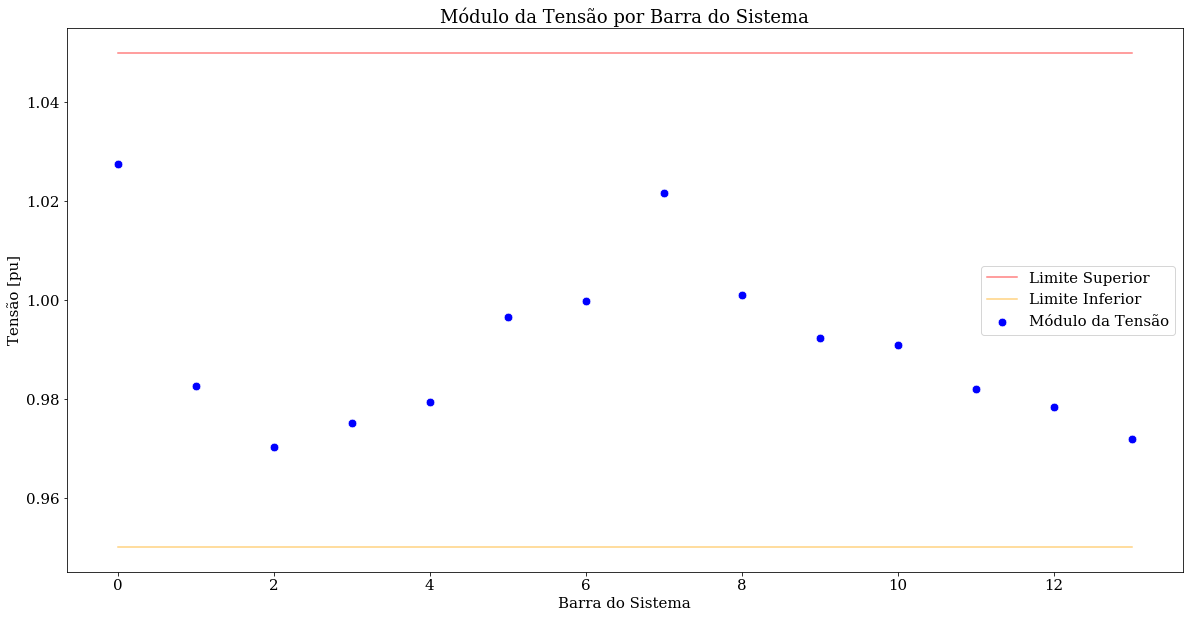

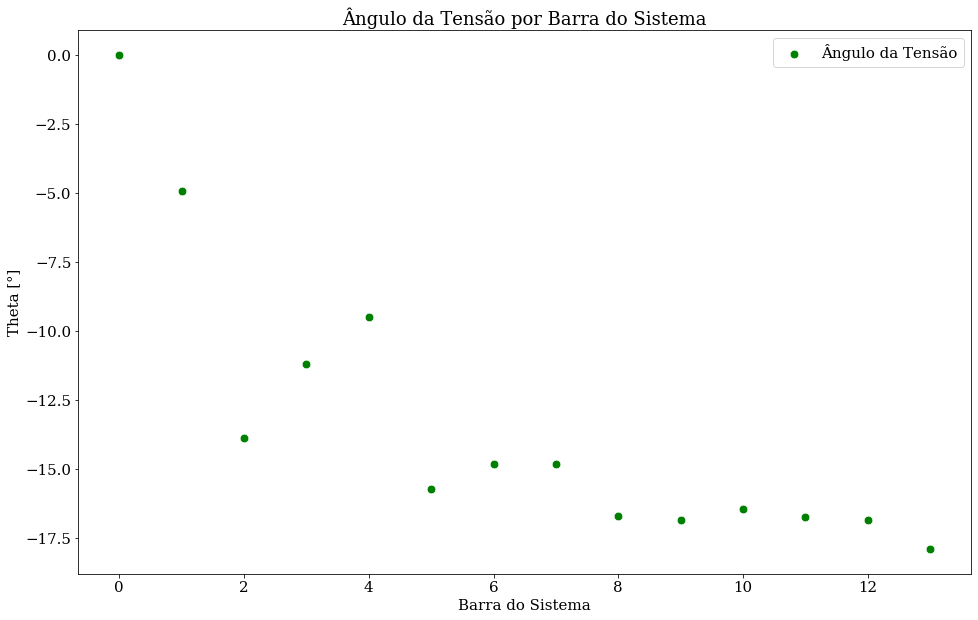

In [36]:

# sep_atualizado.gen['max_q_mvar'] = sep_atualizado.gen['max_q_mvar'].values + 5e-2
# sep_atualizado.gen['min_q_mvar'] = sep_atualizado.gen['min_q_mvar'].values - 5e-2

# sep_atualizado.ext_grid['max_q_mvar'] = sep_atualizado.ext_grid['max_q_mvar'].values + 5e-2
# sep_atualizado.ext_grid['min_q_mvar'] = sep_atualizado.ext_grid['min_q_mvar'].values - 5e-2

# sep_atualizado.ext_grid['max_p_mw'] = sep_atualizado.ext_grid['max_p_mw'].values + 5e-2
# sep_atualizado.ext_grid['min_p_mw'] = sep_atualizado.ext_grid['min_p_mw'].values - 5e-2

coleta_dados_vbus(sep_atualizado)

In [23]:
solucao_continua2,sep_atualizado2,tensao,t,s = automatiza_ipm_c(sep_atualizado, verbose=True, travado=True)

apm 191.254.77.203_gk_model6 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            0
   Variables    :          500
   Intermediates:            0
   Connections  :          187
   Equations    :          423
   Residuals    :          423
 
 Number of state variables:            500
 Number of total equations: -          423
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             77
 
 **********************************************
 Steady State Optimization with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program co

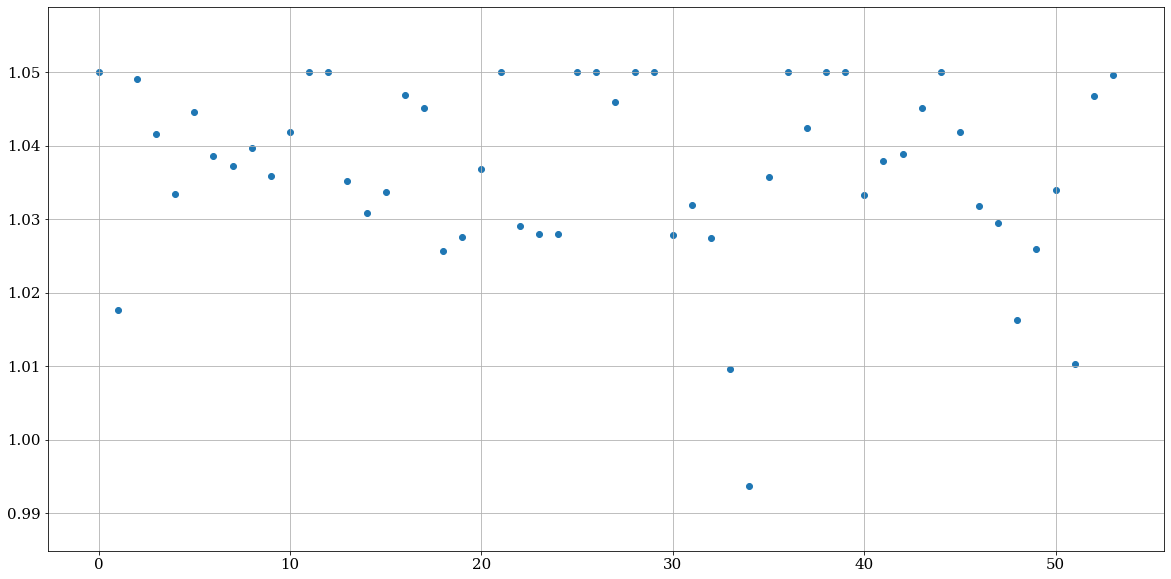

In [16]:
plt.scatter(np.arange(0,len(tensao),1),solucao_continua[:len(tensao)], label='IPOPT C')
# plt.scatter(np.arange(0,len(tensao),1),gbest[:len(tensao)], label='IPOPT C + PSO')
# plt.scatter(np.arange(0,len(tensao),1),solucao_continua2[:len(tensao)], label='IPOPT C + PSO + IPOPT Travado')
plt.grid()
# plt.legend()
# plt.title('Diferentes Tensões em cada Barra')

In [17]:
# plt.scatter(np.arange(0,len(tensao),1),solucao_continua[:len(tensao)], label='IPOPT C')
# plt.scatter(np.arange(0,len(tensao),1),gbest[:len(tensao)], label='IPOPT C + PSO')
plt.scatter(np.arange(0,len(tensao),1),gbest_ar[:len(tensao)], label='Solução Continua Arredondada')
plt.scatter(np.arange(0,len(tensao),1),solucao_continua2[:len(tensao)], label='Solução Híbrida Final')
plt.grid()
plt.legend()

NameError: name 'gbest_ar' is not defined

In [ ]:
# plt.scatter(np.arange(0,len(t),1),solucao_continua[len(tensao):len(t)+len(tensao)], label='IPOPT C')
# plt.scatter(np.arange(0,len(t),1),gbest[len(tensao):len(t)+len(tensao)], label='IPOPT C + PSO')
plt.scatter(np.arange(0,len(t),1),gbest_ar[len(tensao):len(t)+len(tensao)], label='Solucao Continua Arredondada')

plt.scatter(np.arange(0,len(t),1),solucao_continua2[len(tensao):len(t)+len(tensao)], label='Solucao Hibrida')
plt.grid()
plt.legend()
plt.title('Diferentes TAPS em cada Parte do Algoritmo')

In [ ]:
# plt.scatter(np.arange(0,len(s),1),solucao_continua[len(tensao)+len(t):len(tensao)+len(t)+len(s)], label='IPOPT C')
# plt.scatter(np.arange(0,len(s),1),gbest[len(tensao)+len(t):len(tensao)+len(t)+len(s)], label='IPOPT C + PSO')

plt.scatter(np.arange(0,len(s),1),gbest_ar[len(tensao)+len(t):len(tensao)+len(t)+len(s)], label='Solução Continua Arredondadada')
plt.scatter(np.arange(0,len(s),1),solucao_continua2[len(tensao)+len(t):len(tensao)+len(t)+len(s)], label='Soluçaõ Híbrida')
plt.grid()
plt.legend()
plt.title('Diferentes TAPS em cada Parte do Algoritmo')

In [73]:
validacao(sep_atualizado,gbest_ar)

Perdas de Potência Ativa [PU]:

1.1722989381611633
 
Penalização de Violação de Tensão [PU]:

7.40236399423086e-08
 
Penalização de Violação de Geração de Reativo [PU]:

0.052776576024927066
 
Penalização de Violação de TAP Discreto [PU]:

6.7499999999978195
 
Penalização de Violação de Bshunt Discreto [PU]:

1.5520144162386953e-27
 


# Teste Fluxo de Carga

In [4]:
from msc_rafael_pavan import fluxo_de_pot_algo
from numba import jit
import time

In [213]:
tempos_14_nr = []

sep=sep_14

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'nr')
    end = time.time()  
    tempos_14_nr.append(end-start)

    
tempos_30_nr = []

sep=sep_30

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'nr')
    end = time.time()   
    tempos_30_nr.append(end-start)
    
    
    
tempos_118_nr = []

sep=sep_118

for i in range(20):
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'nr')
    end = time.time()  
    tempos_118_nr.append(end-start)



In [216]:
tempos_14_inr = []

sep=sep_14

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'iwamoto_nr')
    end = time.time()  
    tempos_14_inr.append(end-start)
    
    
tempos_30_inr = []

sep=sep_30

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'iwamoto_nr')
    end = time.time()  
    tempos_30_inr.append(end-start)
    
    
    
tempos_118_inr = []

sep=sep_118

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'iwamoto_nr')
    end = time.time()  
    tempos_118_inr.append(end-start)



iwamoto muliplier: 1.0059215365388783
iwamoto muliplier: 1.0057610145353593
iwamoto muliplier: 1.0000106091877234
iwamoto muliplier: 0.9936489067767968
iwamoto muliplier: 1.0062994790505988
iwamoto muliplier: 1.0000054992097849
iwamoto muliplier: 1.0006401974323378
iwamoto muliplier: 1.0074432727347156
iwamoto muliplier: 1.000004628860319
iwamoto muliplier: 1.004458816329734
iwamoto muliplier: 1.0070856052086
iwamoto muliplier: 1.0000052619462152
iwamoto muliplier: 1.0091659234147918
iwamoto muliplier: 1.0069783413621938
iwamoto muliplier: 1.0000067761780251
iwamoto muliplier: 1.0027980033325965
iwamoto muliplier: 1.007984517563465
iwamoto muliplier: 1.000005868644301
iwamoto muliplier: 0.9996301018571452
iwamoto muliplier: 1.0067007106037378
iwamoto muliplier: 1.000004651004505
iwamoto muliplier: 1.0062702381557649
iwamoto muliplier: 1.007505048600239
iwamoto muliplier: 1.0000031184906404
iwamoto muliplier: 1.0083643074770945
iwamoto muliplier: 1.007923063124752
iwamoto muliplier: 1.0

iwamoto muliplier: 1.0003130296917677
iwamoto muliplier: 1.0075646547269246
iwamoto muliplier: 1.000011414906356
iwamoto muliplier: 1.0000000003222425
iwamoto muliplier: 1.0027515939354734
iwamoto muliplier: 1.0071139337494837
iwamoto muliplier: 1.0000127875464002
iwamoto muliplier: 1.0000000007348995
iwamoto muliplier: 1.005738820974788
iwamoto muliplier: 1.007533070033253
iwamoto muliplier: 1.0000106246457299
iwamoto muliplier: 1.000000000802669
iwamoto muliplier: 1.0018262365564816
iwamoto muliplier: 1.0085140203634388
iwamoto muliplier: 1.000004370911773
iwamoto muliplier: 1.0042050177010033
iwamoto muliplier: 1.0071889863321242
iwamoto muliplier: 1.0000041637641812
iwamoto muliplier: 0.9984799367801163
iwamoto muliplier: 1.0057317547998794
iwamoto muliplier: 1.0000135598637008
iwamoto muliplier: 1.0235081436847928
iwamoto muliplier: 1.0092960014100754
iwamoto muliplier: 1.0000161600582695
iwamoto muliplier: 1.000000000846431
iwamoto muliplier: 1.0089329577219113
iwamoto muliplier:

iwamoto muliplier: 0.9969877518198328
iwamoto muliplier: 1.0060673631751078
iwamoto muliplier: 1.0000096271131917
iwamoto muliplier: 1.0212435967834386
iwamoto muliplier: 1.007742552012291
iwamoto muliplier: 1.000006170054155
iwamoto muliplier: 1.0000000003209621
iwamoto muliplier: 1.0042634738195197
iwamoto muliplier: 1.0072066092563607
iwamoto muliplier: 1.0000071437834628
iwamoto muliplier: 1.0029387542302617
iwamoto muliplier: 1.0063893491916367
iwamoto muliplier: 1.0000121818099492
iwamoto muliplier: 1.0089114717984313
iwamoto muliplier: 1.0087732700986223
iwamoto muliplier: 1.000009735495101
iwamoto muliplier: 1.0000000007920762
iwamoto muliplier: 1.007189035408169
iwamoto muliplier: 1.0090161857611621
iwamoto muliplier: 1.000006105810707
iwamoto muliplier: 1.0000000003503162
iwamoto muliplier: 0.996107385682403
iwamoto muliplier: 1.0055208345266256
iwamoto muliplier: 1.000004827606496
iwamoto muliplier: 1.0105987103139216
iwamoto muliplier: 1.0084023205650727
iwamoto muliplier: 

iwamoto muliplier: 1.0018731738179796
iwamoto muliplier: 1.007085163584142
iwamoto muliplier: 1.0000034919596326
iwamoto muliplier: 1.0008273942003136
iwamoto muliplier: 1.0068746118340899
iwamoto muliplier: 1.000005923725705
iwamoto muliplier: 1.01043219095953
iwamoto muliplier: 1.0095409460161868
iwamoto muliplier: 1.0000135638371868
iwamoto muliplier: 1.0000000016490413
iwamoto muliplier: 1.0016880811919016
iwamoto muliplier: 1.0076997284642712
iwamoto muliplier: 1.0000030363948278
iwamoto muliplier: 0.997023138322803
iwamoto muliplier: 1.0071982838643627
iwamoto muliplier: 1.0000087105353437
iwamoto muliplier: 1.001713300905865
iwamoto muliplier: 1.0065085907417841
iwamoto muliplier: 1.0000037982275236
iwamoto muliplier: 1.0246326777517016
iwamoto muliplier: 1.0105065254896755
iwamoto muliplier: 1.000017705278609
iwamoto muliplier: 1.0000000013400383
iwamoto muliplier: 1.0024923822249907
iwamoto muliplier: 1.0064372389365337
iwamoto muliplier: 1.000002710297312
iwamoto muliplier: 1

iwamoto muliplier: 1.014275812968676
iwamoto muliplier: 1.0080105169775535
iwamoto muliplier: 1.0000066610688652
iwamoto muliplier: 1.0000000006613554
iwamoto muliplier: 1.0048833331861313
iwamoto muliplier: 1.0084283111000913
iwamoto muliplier: 1.0000051963972731
iwamoto muliplier: 1.0027604361466746
iwamoto muliplier: 1.007404995294697
iwamoto muliplier: 1.0000045084903268
iwamoto muliplier: 0.9899589215491785
iwamoto muliplier: 1.005667486699247
iwamoto muliplier: 1.0000080160496405
iwamoto muliplier: 1.0063033119892704
iwamoto muliplier: 1.0079273857256505
iwamoto muliplier: 1.000003199885461
iwamoto muliplier: 1.004536932962021
iwamoto muliplier: 1.0077357491262973
iwamoto muliplier: 1.0000034569955984
iwamoto muliplier: 1.002652587421685
iwamoto muliplier: 1.0064655515100474
iwamoto muliplier: 1.0000071556925878
iwamoto muliplier: 1.0168040838912675
iwamoto muliplier: 1.0098368164438376
iwamoto muliplier: 1.0000105995966333
iwamoto muliplier: 1.0000000009899286
iwamoto muliplier:

iwamoto muliplier: 1.0073947679168076
iwamoto muliplier: 1.0000033973175213
iwamoto muliplier: 1.0072972896722352
iwamoto muliplier: 1.009103940270344
iwamoto muliplier: 1.000005658707593
iwamoto muliplier: 1.000000000335268
iwamoto muliplier: 1.018463364738532
iwamoto muliplier: 1.0099763020598684
iwamoto muliplier: 1.0000075130612325
iwamoto muliplier: 1.0000000006872811
iwamoto muliplier: 0.9999408912072291
iwamoto muliplier: 1.0063427148116366
iwamoto muliplier: 1.0000054774251474
iwamoto muliplier: 0.9981109593140779
iwamoto muliplier: 1.0069166008702843
iwamoto muliplier: 1.0000068645784341
iwamoto muliplier: 1.006574153932464
iwamoto muliplier: 1.008138818909028
iwamoto muliplier: 1.0000047490029764
iwamoto muliplier: 1.000043996976769
iwamoto muliplier: 1.0066152354589495
iwamoto muliplier: 1.0000070844113995
iwamoto muliplier: 1.0058902615896494
iwamoto muliplier: 1.0082178935559039
iwamoto muliplier: 1.0000058943070977
iwamoto muliplier: 1.0002442731541938
iwamoto muliplier: 

iwamoto muliplier: 0.994914467168237
iwamoto muliplier: 1.0061808416954836
iwamoto muliplier: 1.000009495299439
iwamoto muliplier: 1.0025174099334764
iwamoto muliplier: 1.0055948680979425
iwamoto muliplier: 1.0000029611220855
iwamoto muliplier: 1.010981291466555
iwamoto muliplier: 1.0065815694518683
iwamoto muliplier: 1.0000233482481289
iwamoto muliplier: 1.0000000051484976
iwamoto muliplier: 0.9995647938251813
iwamoto muliplier: 1.006785332871305
iwamoto muliplier: 1.0000041037828824
iwamoto muliplier: 1.0297416724458974
iwamoto muliplier: 1.0092895373037511
iwamoto muliplier: 1.0000096560476852
iwamoto muliplier: 1.0000000005852325
iwamoto muliplier: 0.9965256049127154
iwamoto muliplier: 1.0081466229195384
iwamoto muliplier: 1.0000102990261024
iwamoto muliplier: 1.0000000003608074
iwamoto muliplier: 1.0048854463637975
iwamoto muliplier: 1.007774398565778
iwamoto muliplier: 1.0000039238005332
iwamoto muliplier: 1.0093097774585909
iwamoto muliplier: 1.0083142989890457
iwamoto muliplier

iwamoto muliplier: 1.0042930008628421
iwamoto muliplier: 1.008443594711152
iwamoto muliplier: 1.000011971013177
iwamoto muliplier: 1.0000000006136534
iwamoto muliplier: 1.0086762044687463
iwamoto muliplier: 1.0078172352632326
iwamoto muliplier: 1.0000087696657736
iwamoto muliplier: 1.0000000006969807
iwamoto muliplier: 0.9989554797615277
iwamoto muliplier: 1.0050980610381968
iwamoto muliplier: 1.000007641237981
iwamoto muliplier: 1.00812495414861
iwamoto muliplier: 1.0076955428817627
iwamoto muliplier: 1.0000063168211086
iwamoto muliplier: 1.014561565909937
iwamoto muliplier: 1.0104559236607666
iwamoto muliplier: 1.0000169630939018
iwamoto muliplier: 1.0000000010215453
iwamoto muliplier: 0.9831090589630103
iwamoto muliplier: 1.0049246905817097
iwamoto muliplier: 1.0000102692248487
iwamoto muliplier: 0.9931247700027304
iwamoto muliplier: 1.0048619455755468
iwamoto muliplier: 1.0000106618911995
iwamoto muliplier: 1.0055649378127407
iwamoto muliplier: 1.0090415576393983
iwamoto muliplier:

iwamoto muliplier: 1.0204907975378257
iwamoto muliplier: 1.009680560317235
iwamoto muliplier: 1.0000101851370207
iwamoto muliplier: 1.0000000006161855
iwamoto muliplier: 1.006646751695966
iwamoto muliplier: 1.0072614296458824
iwamoto muliplier: 1.00000397138096
iwamoto muliplier: 0.9939975902374617
iwamoto muliplier: 1.006103906108518
iwamoto muliplier: 1.0000059223809055
iwamoto muliplier: 1.0004795988161008
iwamoto muliplier: 1.0067583541720184
iwamoto muliplier: 1.000004299060151
iwamoto muliplier: 1.011791333717948
iwamoto muliplier: 1.010791155083827
iwamoto muliplier: 1.00001134284934
iwamoto muliplier: 1.000000000724269
iwamoto muliplier: 1.0059515994275787
iwamoto muliplier: 1.0067082332081834
iwamoto muliplier: 1.0000033280110165
iwamoto muliplier: 0.998944658836699
iwamoto muliplier: 1.0051637547905174
iwamoto muliplier: 1.000012094254127
iwamoto muliplier: 1.0069443887775433
iwamoto muliplier: 1.0087259963764408
iwamoto muliplier: 1.0000080889125675
iwamoto muliplier: 1.0000

iwamoto muliplier: 1.009386277126215
iwamoto muliplier: 1.0069446477608013
iwamoto muliplier: 1.0000050717280682
iwamoto muliplier: 0.9985065912734751
iwamoto muliplier: 1.0050446205020687
iwamoto muliplier: 1.000007230004025
iwamoto muliplier: 1.000621590470613
iwamoto muliplier: 1.0081374838362178
iwamoto muliplier: 1.0000054230587616
iwamoto muliplier: 1.0090819501503183
iwamoto muliplier: 1.0077507470558076
iwamoto muliplier: 1.0000128751940651
iwamoto muliplier: 1.0151788350818176
iwamoto muliplier: 1.0088082402095446
iwamoto muliplier: 1.0000088187291014
iwamoto muliplier: 1.0000000010674952
iwamoto muliplier: 1.0194191416633325
iwamoto muliplier: 1.0095350409844275
iwamoto muliplier: 1.000015762962528
iwamoto muliplier: 1.0000000010820456
iwamoto muliplier: 0.9996234142318619
iwamoto muliplier: 1.006428077067895
iwamoto muliplier: 1.0000047726493044
iwamoto muliplier: 0.9869696422473486
iwamoto muliplier: 1.0060071309489853
iwamoto muliplier: 1.0000136314322858
iwamoto muliplier

iwamoto muliplier: 0.9899484265714833
iwamoto muliplier: 1.0053555534940637
iwamoto muliplier: 1.0000190819838541
iwamoto muliplier: 0.9954121691202455
iwamoto muliplier: 1.0068173736683725
iwamoto muliplier: 1.0000074194468573
iwamoto muliplier: 1.0044513420029253
iwamoto muliplier: 1.0082079036095613
iwamoto muliplier: 1.0000055587964587
iwamoto muliplier: 1.000921358353378
iwamoto muliplier: 1.0052770588327773
iwamoto muliplier: 1.0000038339595088
iwamoto muliplier: 1.0055699983340087
iwamoto muliplier: 1.0079572131603263
iwamoto muliplier: 1.0000073695515543
iwamoto muliplier: 1.0101595263226166
iwamoto muliplier: 1.008121454493747
iwamoto muliplier: 1.000004144186693
iwamoto muliplier: 1.0113833691514555
iwamoto muliplier: 1.009427951411605
iwamoto muliplier: 1.00000602463852
iwamoto muliplier: 1.000000000353768
iwamoto muliplier: 1.0081940425700946
iwamoto muliplier: 1.0072356703498588
iwamoto muliplier: 1.0000049243761153
iwamoto muliplier: 0.9986956160919558
iwamoto muliplier: 

iwamoto muliplier: 1.005435101716273
iwamoto muliplier: 1.007401168591371
iwamoto muliplier: 1.0000046047267317
iwamoto muliplier: 1.0212156002169708
iwamoto muliplier: 1.010304490951403
iwamoto muliplier: 1.0000177089873579
iwamoto muliplier: 1.000000000947333
iwamoto muliplier: 1.0031633775850104
iwamoto muliplier: 1.007884547797116
iwamoto muliplier: 1.0000075457527027
iwamoto muliplier: 1.0000000002473153
iwamoto muliplier: 1.00701133107993
iwamoto muliplier: 1.0070276106902105
iwamoto muliplier: 1.0000136677237506
iwamoto muliplier: 1.0000000011970092
iwamoto muliplier: 1.0038070457969603
iwamoto muliplier: 1.00807519796074
iwamoto muliplier: 1.000007155974241
iwamoto muliplier: 1.0000000002853664
iwamoto muliplier: 1.0020655086451216
iwamoto muliplier: 1.0084447357939683
iwamoto muliplier: 1.0000120383490738
iwamoto muliplier: 1.0000000005428333
iwamoto muliplier: 1.023400505817787
iwamoto muliplier: 1.008716204258447
iwamoto muliplier: 1.0000082741648235
iwamoto muliplier: 1.000

iwamoto muliplier: 1.0035742525730103
iwamoto muliplier: 1.0081907511509673
iwamoto muliplier: 1.0000087864668572
iwamoto muliplier: 1.000000000381938
iwamoto muliplier: 1.003680817503852
iwamoto muliplier: 1.0084704017436672
iwamoto muliplier: 1.0000084439678278
iwamoto muliplier: 1.0000000003593073
iwamoto muliplier: 1.0092076131162357
iwamoto muliplier: 1.0083561612621892
iwamoto muliplier: 1.0000054609503977
iwamoto muliplier: 1.0069952163397926
iwamoto muliplier: 1.009266525564472
iwamoto muliplier: 1.0000068374469055
iwamoto muliplier: 1.0000000004914695
iwamoto muliplier: 1.0032305557769319
iwamoto muliplier: 1.0064218595525396
iwamoto muliplier: 1.000019584101847
iwamoto muliplier: 1.0000000013823327
iwamoto muliplier: 1.017318815200858
iwamoto muliplier: 1.0071249775716749
iwamoto muliplier: 1.0000033633103347
iwamoto muliplier: 1.0151367889153347
iwamoto muliplier: 1.0097490768761777
iwamoto muliplier: 1.0000103179925435
iwamoto muliplier: 1.0000000004369431
iwamoto muliplier

iwamoto muliplier: 1.003317213250381
iwamoto muliplier: 1.0062779366717183
iwamoto muliplier: 1.000003822920202
iwamoto muliplier: 1.0001478721676178
iwamoto muliplier: 1.0076289398370057
iwamoto muliplier: 1.0000065581250606
iwamoto muliplier: 1.0107423254337395
iwamoto muliplier: 1.007928791911287
iwamoto muliplier: 1.0000106708288203
iwamoto muliplier: 1.0000000005710141
iwamoto muliplier: 0.9978096195158955
iwamoto muliplier: 1.0091572298805858
iwamoto muliplier: 1.0000191039300694
iwamoto muliplier: 1.0000000012137897
iwamoto muliplier: 1.0101097315931105
iwamoto muliplier: 1.0096111542637227
iwamoto muliplier: 1.0000107171953936
iwamoto muliplier: 1.0000000010439822
iwamoto muliplier: 0.994892664994602
iwamoto muliplier: 1.0069959083065803
iwamoto muliplier: 1.0000089273157136
iwamoto muliplier: 1.0000000003530256
iwamoto muliplier: 1.0053944171830194
iwamoto muliplier: 1.0074101953394008
iwamoto muliplier: 1.000006776197274
iwamoto muliplier: 1.0007387290478644
iwamoto muliplier

iwamoto muliplier: 0.9927678977787229
iwamoto muliplier: 1.005692426542594
iwamoto muliplier: 1.0000056429167874
iwamoto muliplier: 1.0152780834885784
iwamoto muliplier: 1.0088996325929673
iwamoto muliplier: 1.0000117007274987
iwamoto muliplier: 1.0000000006027094
iwamoto muliplier: 0.9965843985710597
iwamoto muliplier: 1.0071050088955613
iwamoto muliplier: 1.0000063635774947
iwamoto muliplier: 1.0019200781406175
iwamoto muliplier: 1.007137466749925
iwamoto muliplier: 1.0000100532892282
iwamoto muliplier: 1.0000000007911367
iwamoto muliplier: 1.007223687213931
iwamoto muliplier: 1.0076443039009297
iwamoto muliplier: 1.0000094322529711
iwamoto muliplier: 1.0000000008976915
iwamoto muliplier: 1.0206682466631034
iwamoto muliplier: 1.0103249608208478
iwamoto muliplier: 1.0000166740961813
iwamoto muliplier: 1.0000000011438
iwamoto muliplier: 1.0085959696036924
iwamoto muliplier: 1.006442848453576
iwamoto muliplier: 1.0000115128599036
iwamoto muliplier: 1.0000000008658971
iwamoto muliplier: 

iwamoto muliplier: 1.0075969659069641
iwamoto muliplier: 1.0000706818586824
iwamoto muliplier: 1.0000000775714948
iwamoto muliplier: 0.9912091499893707
iwamoto muliplier: 1.0066861681786734
iwamoto muliplier: 1.0000504450605727
iwamoto muliplier: 1.0000000088121077
iwamoto muliplier: 1.002246984863572
iwamoto muliplier: 1.0082935577983503
iwamoto muliplier: 1.0000247369191344
iwamoto muliplier: 1.0000000028560798
iwamoto muliplier: 1.0066829573126532
iwamoto muliplier: 1.0084768546077005
iwamoto muliplier: 1.0000148454510875
iwamoto muliplier: 1.0000000051656233
iwamoto muliplier: 1.0254142094753518
iwamoto muliplier: 1.008245173275498
iwamoto muliplier: 1.0000168638809055
iwamoto muliplier: 1.0000000058963474
iwamoto muliplier: 0.9967075558157584
iwamoto muliplier: 1.0066522632292365
iwamoto muliplier: 1.0000294146802502
iwamoto muliplier: 1.0000000187816063
iwamoto muliplier: 1.0060955778237248
iwamoto muliplier: 1.0068979999754242
iwamoto muliplier: 1.0000220354153255
iwamoto mulipl

iwamoto muliplier: 1.000435052762078
iwamoto muliplier: 1.0059736039707605
iwamoto muliplier: 1.0000172727300451
iwamoto muliplier: 1.0000000007087304
iwamoto muliplier: 1.0037429023513262
iwamoto muliplier: 1.0073679788906853
iwamoto muliplier: 1.000022341124858
iwamoto muliplier: 1.0000000041860968
iwamoto muliplier: 0.9963425989720393
iwamoto muliplier: 1.0060002642120571
iwamoto muliplier: 1.000075163040439
iwamoto muliplier: 1.0000000673463396
iwamoto muliplier: 1.0006958750429882
iwamoto muliplier: 1.0067901829243402
iwamoto muliplier: 1.0000564941460248
iwamoto muliplier: 1.0000000580061243
iwamoto muliplier: 0.9762441225486085
iwamoto muliplier: 1.0073390152114954
iwamoto muliplier: 1.0000443210266676
iwamoto muliplier: 1.0000000031586043
iwamoto muliplier: 1.0010607570575858
iwamoto muliplier: 1.0076536956065787
iwamoto muliplier: 1.000050410487574
iwamoto muliplier: 1.0000000643020126
iwamoto muliplier: 1.0004370247853185
iwamoto muliplier: 1.00717420451747
iwamoto muliplier:

iwamoto muliplier: 1.0131746978405618
iwamoto muliplier: 1.007511283780098
iwamoto muliplier: 1.000105951088539
iwamoto muliplier: 1.0000001638779228
iwamoto muliplier: 1.0093426919103825
iwamoto muliplier: 1.007737687717448
iwamoto muliplier: 1.0000094403409494
iwamoto muliplier: 1.0000000014998491
iwamoto muliplier: 1.0097207023597266
iwamoto muliplier: 1.0069431200631176
iwamoto muliplier: 1.0001001364387454
iwamoto muliplier: 1.0000001191662464
iwamoto muliplier: 0.9882833056869728
iwamoto muliplier: 1.005556367500415
iwamoto muliplier: 1.0000336349935108
iwamoto muliplier: 1.000000001283164
iwamoto muliplier: 0.9800466629125751
iwamoto muliplier: 1.0060176956783944
iwamoto muliplier: 1.0000311527235424
iwamoto muliplier: 1.0000000011875876
iwamoto muliplier: 1.014038517949613
iwamoto muliplier: 1.0080627429095204
iwamoto muliplier: 1.0000874576857084
iwamoto muliplier: 1.000000128675354
iwamoto muliplier: 1.004696952701976
iwamoto muliplier: 1.0066630118818303
iwamoto muliplier: 1

iwamoto muliplier: 1.006995565581513
iwamoto muliplier: 1.0000216236944857
iwamoto muliplier: 1.000000002377254
iwamoto muliplier: 0.994585410020429
iwamoto muliplier: 1.0074632012167946
iwamoto muliplier: 1.0000594296449041
iwamoto muliplier: 1.00000007169472
iwamoto muliplier: 1.0239182573428176
iwamoto muliplier: 1.007511911808349
iwamoto muliplier: 1.0000228915081457
iwamoto muliplier: 1.0000000071209105
iwamoto muliplier: 1.0125504362714683
iwamoto muliplier: 1.007561362347529
iwamoto muliplier: 1.0000228238395232
iwamoto muliplier: 1.0000000102966011
iwamoto muliplier: 1.0032552919790503
iwamoto muliplier: 1.0062899548668336
iwamoto muliplier: 1.0000261094993697
iwamoto muliplier: 1.0000000052733902
iwamoto muliplier: 0.9958708732903822
iwamoto muliplier: 1.0067399847783018
iwamoto muliplier: 1.000009705368338
iwamoto muliplier: 1.000000000804726
iwamoto muliplier: 1.0060861791059665
iwamoto muliplier: 1.0059577892562277
iwamoto muliplier: 1.0000241513586476
iwamoto muliplier: 1.

iwamoto muliplier: 1.0089950269507135
iwamoto muliplier: 1.0068000697177344
iwamoto muliplier: 1.0000346268899056
iwamoto muliplier: 1.000000024078057
iwamoto muliplier: 1.009700510428027
iwamoto muliplier: 1.0083953844005995
iwamoto muliplier: 1.0000150001287282
iwamoto muliplier: 1.0000000015737447
iwamoto muliplier: 1.017588976027068
iwamoto muliplier: 1.007158132642188
iwamoto muliplier: 1.0000110627843446
iwamoto muliplier: 1.000000003087456
iwamoto muliplier: 0.9763348467897408
iwamoto muliplier: 1.0075926820459526
iwamoto muliplier: 1.0000361404242404
iwamoto muliplier: 1.000000002410185
iwamoto muliplier: 1.0114382247386153
iwamoto muliplier: 1.0066322407864072
iwamoto muliplier: 1.0000930445597433
iwamoto muliplier: 1.0000001221304247
iwamoto muliplier: 1.0036854711348269
iwamoto muliplier: 1.0084837056151712
iwamoto muliplier: 1.0000215313221679
iwamoto muliplier: 1.0000000021372768
iwamoto muliplier: 1.0068576843459287
iwamoto muliplier: 1.0060073869859119
iwamoto muliplier:

iwamoto muliplier: 0.9967000626747152
iwamoto muliplier: 1.008278703647892
iwamoto muliplier: 1.0000144102446333
iwamoto muliplier: 1.000000001357082
iwamoto muliplier: 0.9970474699711245
iwamoto muliplier: 1.006983308981062
iwamoto muliplier: 1.0000196630509937
iwamoto muliplier: 1.000000010346898
iwamoto muliplier: 1.0050594220269233
iwamoto muliplier: 1.0077609346839358
iwamoto muliplier: 1.0000223731827618
iwamoto muliplier: 1.000000013852654
iwamoto muliplier: 1.007277785864034
iwamoto muliplier: 1.008106310378912
iwamoto muliplier: 1.0000152811681042
iwamoto muliplier: 1.0000000015372625
iwamoto muliplier: 0.9859714346229624
iwamoto muliplier: 1.0054312966731138
iwamoto muliplier: 1.0000408430211893
iwamoto muliplier: 1.0000000007628465
iwamoto muliplier: 1.0026323383143398
iwamoto muliplier: 1.0068413797835258
iwamoto muliplier: 1.0000659137328498
iwamoto muliplier: 1.0000000728040526
iwamoto muliplier: 1.014164528889726
iwamoto muliplier: 1.0076646695781388
iwamoto muliplier: 1

iwamoto muliplier: 1.0053157822187033
iwamoto muliplier: 1.0067209092520757
iwamoto muliplier: 1.0000340620220982
iwamoto muliplier: 1.000000032480671
iwamoto muliplier: 1.0174518659636604
iwamoto muliplier: 1.007050292524687
iwamoto muliplier: 1.0000575468809596
iwamoto muliplier: 1.000000069172575
iwamoto muliplier: 0.9924886637562272
iwamoto muliplier: 1.0058232503475468
iwamoto muliplier: 1.0000169468544198
iwamoto muliplier: 1.0000000013451826
iwamoto muliplier: 1.0103219242633952
iwamoto muliplier: 1.0087775336003424
iwamoto muliplier: 1.0000233160356393
iwamoto muliplier: 1.000000006341385
iwamoto muliplier: 1.0147244103314115
iwamoto muliplier: 1.006936823225983
iwamoto muliplier: 1.0000169775055425
iwamoto muliplier: 1.0000000038092531
iwamoto muliplier: 1.0176418468791528
iwamoto muliplier: 1.0091327756172241
iwamoto muliplier: 1.0000768761992787
iwamoto muliplier: 1.0000001372196035
iwamoto muliplier: 1.0234354374284804
iwamoto muliplier: 1.0070487997110467
iwamoto muliplier

iwamoto muliplier: 0.9975585597962335
iwamoto muliplier: 1.008256137112094
iwamoto muliplier: 1.00003237523938
iwamoto muliplier: 1.0000000206584823
iwamoto muliplier: 1.0067195709552077
iwamoto muliplier: 1.0062920564088542
iwamoto muliplier: 1.0000826735942416
iwamoto muliplier: 1.0000000861752376
iwamoto muliplier: 0.9984038965881155
iwamoto muliplier: 1.0079473428935626
iwamoto muliplier: 1.0000241953444367
iwamoto muliplier: 1.0000000021698079
iwamoto muliplier: 1.0084677747141717
iwamoto muliplier: 1.0077023624938146
iwamoto muliplier: 1.0000134945474903
iwamoto muliplier: 1.000000001922887
iwamoto muliplier: 0.9994949217309955
iwamoto muliplier: 1.0072587620736173
iwamoto muliplier: 1.0000131690487097
iwamoto muliplier: 1.000000000955002
iwamoto muliplier: 1.011342045757248
iwamoto muliplier: 1.008316699973127
iwamoto muliplier: 1.0000130690525808
iwamoto muliplier: 1.0000000019288355
iwamoto muliplier: 0.9976329385745002
iwamoto muliplier: 1.0076655249707247
iwamoto muliplier: 

iwamoto muliplier: 1.0000001878616187
iwamoto muliplier: 1.0045357748362465
iwamoto muliplier: 1.0074654977844852
iwamoto muliplier: 1.0000526603579392
iwamoto muliplier: 1.0000000363475965
iwamoto muliplier: 0.9960101008300226
iwamoto muliplier: 1.0066770115963057
iwamoto muliplier: 1.0000157752853047
iwamoto muliplier: 1.0000000012170154
iwamoto muliplier: 1.0176913088221988
iwamoto muliplier: 1.0066614666855638
iwamoto muliplier: 1.0000700663141244
iwamoto muliplier: 1.0000000776326783
iwamoto muliplier: 1.003423259364274
iwamoto muliplier: 1.0069912236160135
iwamoto muliplier: 1.0001218665688212
iwamoto muliplier: 1.0000001712962174
iwamoto muliplier: 1.0060155893565212
iwamoto muliplier: 1.006098650254463
iwamoto muliplier: 1.0000144917435476
iwamoto muliplier: 1.000000002316742
iwamoto muliplier: 1.0044471814811742
iwamoto muliplier: 1.0065657995189636
iwamoto muliplier: 1.0000282912302345
iwamoto muliplier: 1.0000000261913748
iwamoto muliplier: 1.0018810772180025
iwamoto mulipli

iwamoto muliplier: 0.9995899853942377
iwamoto muliplier: 1.005266306289798
iwamoto muliplier: 1.0000078273826163
iwamoto muliplier: 1.0000000009755243
iwamoto muliplier: 1.0204438436879248
iwamoto muliplier: 1.0073371825020927
iwamoto muliplier: 1.0000206948251351
iwamoto muliplier: 1.0000000064930947
iwamoto muliplier: 0.9925187902152692
iwamoto muliplier: 1.0075372412152308
iwamoto muliplier: 1.0000162716585528
iwamoto muliplier: 1.0000000014365968
iwamoto muliplier: 1.0222291768515233
iwamoto muliplier: 1.008264960483855
iwamoto muliplier: 1.0000350163440264
iwamoto muliplier: 1.0000000461483272
iwamoto muliplier: 0.9894662284090524
iwamoto muliplier: 1.0054536755639856
iwamoto muliplier: 1.0000253247322946
iwamoto muliplier: 1.0000000007283982
iwamoto muliplier: 0.9995656459097411
iwamoto muliplier: 1.0070058532698434
iwamoto muliplier: 1.0000194144218795
iwamoto muliplier: 1.000000001381378
iwamoto muliplier: 0.9897016390446576
iwamoto muliplier: 1.0071519198741625
iwamoto mulipli

iwamoto muliplier: 0.9951519517646337
iwamoto muliplier: 1.007272949802037
iwamoto muliplier: 1.0000224286887303
iwamoto muliplier: 1.0000000021016218
iwamoto muliplier: 1.0187381825382393
iwamoto muliplier: 1.0067455727512142
iwamoto muliplier: 1.0001560688183357
iwamoto muliplier: 1.0000002287990857
iwamoto muliplier: 1.0124373772576816
iwamoto muliplier: 1.0095877877954482
iwamoto muliplier: 1.0000312713755612
iwamoto muliplier: 1.0000000152138726
iwamoto muliplier: 1.0118054145038715
iwamoto muliplier: 1.006822904365836
iwamoto muliplier: 1.0000114781238827
iwamoto muliplier: 1.0000000018083066
iwamoto muliplier: 1.0014347763284415
iwamoto muliplier: 1.0070292050596736
iwamoto muliplier: 1.0000201702390403
iwamoto muliplier: 1.00000000573286
iwamoto muliplier: 0.987269121288823
iwamoto muliplier: 1.0072646060279693
iwamoto muliplier: 1.000029759907769
iwamoto muliplier: 1.0000000066848955
iwamoto muliplier: 1.0081295831505233
iwamoto muliplier: 1.0066846130685316
iwamoto muliplier:

iwamoto muliplier: 1.004458098729304
iwamoto muliplier: 1.0074465051322052
iwamoto muliplier: 1.0000140713093986
iwamoto muliplier: 1.0000000021249107
iwamoto muliplier: 1.0036198960234648
iwamoto muliplier: 1.0083864948645245
iwamoto muliplier: 1.0000200176672758
iwamoto muliplier: 1.000000008713198
iwamoto muliplier: 1.000683666910755
iwamoto muliplier: 1.0074111564547474
iwamoto muliplier: 1.0000187014215993
iwamoto muliplier: 1.000000016382254
iwamoto muliplier: 1.0003053724265483
iwamoto muliplier: 1.0079669308670323
iwamoto muliplier: 1.0000286229635758
iwamoto muliplier: 1.000000011131734
iwamoto muliplier: 1.0145616852049764
iwamoto muliplier: 1.007294232248733
iwamoto muliplier: 1.0001096847472966
iwamoto muliplier: 1.0000001689947886
iwamoto muliplier: 1.0214714803060236
iwamoto muliplier: 1.0066011501930936
iwamoto muliplier: 1.000079802368376
iwamoto muliplier: 1.0000001027245435
iwamoto muliplier: 1.0262866926348277
iwamoto muliplier: 1.0073446912423243
iwamoto muliplier: 

iwamoto muliplier: 0.9930445728084637
iwamoto muliplier: 1.0060117954554202
iwamoto muliplier: 1.0001068985545758
iwamoto muliplier: 1.0000001091690582
iwamoto muliplier: 1.0005187318694981
iwamoto muliplier: 1.0062551279562475
iwamoto muliplier: 1.0000111831486864
iwamoto muliplier: 1.0000000008150114
iwamoto muliplier: 1.0084020511261904
iwamoto muliplier: 1.00753692099508
iwamoto muliplier: 1.0000194461268197
iwamoto muliplier: 1.0000000037287566
iwamoto muliplier: 0.9997001029312884
iwamoto muliplier: 1.0080922736522386
iwamoto muliplier: 1.000033280144055
iwamoto muliplier: 1.000000007385988
iwamoto muliplier: 0.9993355000134205
iwamoto muliplier: 1.0064002235152179
iwamoto muliplier: 1.0000115694335407
iwamoto muliplier: 1.0000000008380585
iwamoto muliplier: 1.0175565322011475
iwamoto muliplier: 1.007897523687476
iwamoto muliplier: 1.0000121757214138
iwamoto muliplier: 1.0000000016919115
iwamoto muliplier: 0.9918243799046247
iwamoto muliplier: 1.0078893588479576
iwamoto muliplier

iwamoto muliplier: 0.9924599158424419
iwamoto muliplier: 1.0057971020127303
iwamoto muliplier: 1.000026481163369
iwamoto muliplier: 1.0000000012048402
iwamoto muliplier: 1.008933890863948
iwamoto muliplier: 1.0069674756968858
iwamoto muliplier: 1.0000968193749145
iwamoto muliplier: 1.0000001319947946
iwamoto muliplier: 0.9949724150796286
iwamoto muliplier: 1.0056247131486795
iwamoto muliplier: 1.0000218470362088
iwamoto muliplier: 1.0000000008240872
iwamoto muliplier: 1.017781439482795
iwamoto muliplier: 1.0087299309969175
iwamoto muliplier: 1.0001040473215919
iwamoto muliplier: 1.0000001769451676
iwamoto muliplier: 0.9953510546046505
iwamoto muliplier: 1.0066833235334665
iwamoto muliplier: 1.000029535277337
iwamoto muliplier: 1.0000000025795195
iwamoto muliplier: 0.9932595738146287
iwamoto muliplier: 1.0056356083161417
iwamoto muliplier: 1.0000108137889132
iwamoto muliplier: 1.0000000004794134
iwamoto muliplier: 0.9992944730600472
iwamoto muliplier: 1.006938064868715
iwamoto muliplier

iwamoto muliplier: 1.0097231001348244
iwamoto muliplier: 1.005996949890805
iwamoto muliplier: 1.0000195282762996
iwamoto muliplier: 1.0000000027270295
iwamoto muliplier: 1.0050523528088608
iwamoto muliplier: 1.0061340019229517
iwamoto muliplier: 1.0000219831944432
iwamoto muliplier: 1.0000000061160386
iwamoto muliplier: 1.0070176114556615
iwamoto muliplier: 1.0074654128473144
iwamoto muliplier: 1.000095560189327
iwamoto muliplier: 1.0000001233294067
iwamoto muliplier: 0.9897241911408635
iwamoto muliplier: 1.0055826305237734
iwamoto muliplier: 1.0000481380986534
iwamoto muliplier: 1.0000000345363282
iwamoto muliplier: 1.0300863104765572
iwamoto muliplier: 1.0092510939370785
iwamoto muliplier: 1.0000311999834568
iwamoto muliplier: 1.0000000355189496
iwamoto muliplier: 1.000372465585132
iwamoto muliplier: 1.0072448826808933
iwamoto muliplier: 1.0000110842956411
iwamoto muliplier: 1.0000000021382598
iwamoto muliplier: 0.986605901285048
iwamoto muliplier: 1.0046992889187611
iwamoto muliplie

iwamoto muliplier: 1.013481582254826
iwamoto muliplier: 1.0076374922044804
iwamoto muliplier: 1.0000137189199596
iwamoto muliplier: 1.0000000036310042
iwamoto muliplier: 1.0000286403511354
iwamoto muliplier: 1.0072969036859651
iwamoto muliplier: 1.0000123409244561
iwamoto muliplier: 1.0000000019018418
iwamoto muliplier: 1.0027044585301625
iwamoto muliplier: 1.0059624113405194
iwamoto muliplier: 1.0000517748312259
iwamoto muliplier: 1.000000043773003
iwamoto muliplier: 1.0327053671784694
iwamoto muliplier: 1.0073863205336657
iwamoto muliplier: 1.000158138054188
iwamoto muliplier: 1.0000002630237368
iwamoto muliplier: 1.005116026580567
iwamoto muliplier: 1.0079313920703625
iwamoto muliplier: 1.0000855374400661
iwamoto muliplier: 1.0000001199987356
iwamoto muliplier: 1.0104023951966272
iwamoto muliplier: 1.0065543231065772
iwamoto muliplier: 1.00001709456557
iwamoto muliplier: 1.0000000023240423
iwamoto muliplier: 1.00135987887144
iwamoto muliplier: 1.007568999014546
iwamoto muliplier: 1.

iwamoto muliplier: 0.9884256426973579
iwamoto muliplier: 1.0059277362220795
iwamoto muliplier: 1.0000249621581818
iwamoto muliplier: 1.0000000026115905
iwamoto muliplier: 1.0145615988859746
iwamoto muliplier: 1.0065597320962223
iwamoto muliplier: 1.0000370733157642
iwamoto muliplier: 1.0000000275618093
iwamoto muliplier: 1.011861246393882
iwamoto muliplier: 1.0072984954796105
iwamoto muliplier: 1.0000187497318653
iwamoto muliplier: 1.000000004255001
iwamoto muliplier: 1.0335629136163138
iwamoto muliplier: 1.008977554046492
iwamoto muliplier: 1.0000284933928587
iwamoto muliplier: 1.000000007813249
iwamoto muliplier: 0.9922498846611386
iwamoto muliplier: 1.0054994820205025
iwamoto muliplier: 1.0000819562483179
iwamoto muliplier: 1.0000000670114266
iwamoto muliplier: 1.0154675135276787
iwamoto muliplier: 1.007370540406786
iwamoto muliplier: 1.0000064622505442
iwamoto muliplier: 1.0000000006530017
iwamoto muliplier: 0.9925761209317645
iwamoto muliplier: 1.0059587629947646
iwamoto muliplier

iwamoto muliplier: 1.0010964028812845
iwamoto muliplier: 1.0102658375105105
iwamoto muliplier: 1.0003625349702812
iwamoto muliplier: 1.0000004330577001
iwamoto muliplier: 1.0031603408637366
iwamoto muliplier: 1.0089283635358177
iwamoto muliplier: 1.0003330725318784
iwamoto muliplier: 1.0000003701512106
iwamoto muliplier: 1.0039863523951642
iwamoto muliplier: 1.010670134415031
iwamoto muliplier: 1.000312666979573
iwamoto muliplier: 1.0000002760727167
iwamoto muliplier: 0.9889068809907592
iwamoto muliplier: 1.0090301618160815
iwamoto muliplier: 1.0003053388621101
iwamoto muliplier: 1.0000003823879355
iwamoto muliplier: 0.9748758721762218
iwamoto muliplier: 1.0091560541926712
iwamoto muliplier: 1.0004087547999214
iwamoto muliplier: 1.0000005438348936
iwamoto muliplier: 1.0018141649570906
iwamoto muliplier: 1.008513203403962
iwamoto muliplier: 1.0003392044560442
iwamoto muliplier: 1.0000004427216138
iwamoto muliplier: 0.9962486539743245
iwamoto muliplier: 1.0095351301506803
iwamoto mulipli

iwamoto muliplier: 0.9943476943263431
iwamoto muliplier: 1.0087882527279086
iwamoto muliplier: 1.0003597722517439
iwamoto muliplier: 1.0000004489525918
iwamoto muliplier: 0.9974243479112144
iwamoto muliplier: 1.0097792830698937
iwamoto muliplier: 1.0003549597456065
iwamoto muliplier: 1.0000004659516477
iwamoto muliplier: 0.9949729811775225
iwamoto muliplier: 1.0085027239025202
iwamoto muliplier: 1.0003821668762434
iwamoto muliplier: 1.0000005254739839
iwamoto muliplier: 0.9976941068707768
iwamoto muliplier: 1.0092519427456654
iwamoto muliplier: 1.0004176131236395
iwamoto muliplier: 1.0000004333535162
iwamoto muliplier: 1.0067001759573713
iwamoto muliplier: 1.009423489409224
iwamoto muliplier: 1.0003086901658822
iwamoto muliplier: 1.000000289103363
iwamoto muliplier: 0.9981029931274573
iwamoto muliplier: 1.0098001230258584
iwamoto muliplier: 1.000403911967067
iwamoto muliplier: 1.0000004650728211
iwamoto muliplier: 0.9947524866303977
iwamoto muliplier: 1.008677109568078
iwamoto muliplie

iwamoto muliplier: 0.9923645670418778
iwamoto muliplier: 1.0091347695190145
iwamoto muliplier: 1.0004209123832724
iwamoto muliplier: 1.000000545486991
iwamoto muliplier: 0.9774417160283775
iwamoto muliplier: 1.0097998406494313
iwamoto muliplier: 1.0003356125108829
iwamoto muliplier: 1.000000312077597
iwamoto muliplier: 0.9927808406395734
iwamoto muliplier: 1.0090148959682343
iwamoto muliplier: 1.0003846682826083
iwamoto muliplier: 1.0000003530466783
iwamoto muliplier: 0.9998823414579316
iwamoto muliplier: 1.007918958813813
iwamoto muliplier: 1.0002907006990747
iwamoto muliplier: 1.0000003037698464
iwamoto muliplier: 0.9902360273743669
iwamoto muliplier: 1.0087956774511513
iwamoto muliplier: 1.0003892742955942
iwamoto muliplier: 1.0000004654396935
iwamoto muliplier: 0.9875374937811185
iwamoto muliplier: 1.0095797499249914
iwamoto muliplier: 1.000415499772386
iwamoto muliplier: 1.000000512894413
iwamoto muliplier: 1.0003589104380306
iwamoto muliplier: 1.0092089624136689
iwamoto muliplier

iwamoto muliplier: 0.9955162402965045
iwamoto muliplier: 1.009098555943629
iwamoto muliplier: 1.0003237511162517
iwamoto muliplier: 1.0000002450027712
iwamoto muliplier: 0.9847847663624575
iwamoto muliplier: 1.0082227047583816
iwamoto muliplier: 1.0003296599528047
iwamoto muliplier: 1.0000002885161274
iwamoto muliplier: 0.9832435122010408
iwamoto muliplier: 1.0088908317796899
iwamoto muliplier: 1.0003718891826976
iwamoto muliplier: 1.0000004572147454
iwamoto muliplier: 0.9996280967980935
iwamoto muliplier: 1.010488274104394
iwamoto muliplier: 1.0003273710043608
iwamoto muliplier: 1.000000323041914
iwamoto muliplier: 0.9989644174468337
iwamoto muliplier: 1.0101804149186524
iwamoto muliplier: 1.0004948432478846
iwamoto muliplier: 1.000000542748844
iwamoto muliplier: 1.0008664888865395
iwamoto muliplier: 1.0097493044346126
iwamoto muliplier: 1.000441281458127
iwamoto muliplier: 1.0000005402982348
iwamoto muliplier: 0.9945721311163914
iwamoto muliplier: 1.0081368713545762
iwamoto muliplier

iwamoto muliplier: 1.0014976167606773
iwamoto muliplier: 1.0099186518467096
iwamoto muliplier: 1.000266552808692
iwamoto muliplier: 1.0000002273424764
iwamoto muliplier: 0.9928914096339243
iwamoto muliplier: 1.0094414436385473
iwamoto muliplier: 1.0004047165977594
iwamoto muliplier: 1.000000400268317
iwamoto muliplier: 0.9941761981249547
iwamoto muliplier: 1.0099143040997423
iwamoto muliplier: 1.0004423683517667
iwamoto muliplier: 1.0000005295931331
iwamoto muliplier: 0.9887994752584688
iwamoto muliplier: 1.0091703763226672
iwamoto muliplier: 1.000381977237281
iwamoto muliplier: 1.000000360747184
iwamoto muliplier: 1.0012586739415155
iwamoto muliplier: 1.0093042046986633
iwamoto muliplier: 1.0003877695803594
iwamoto muliplier: 1.000000524725955
iwamoto muliplier: 0.9907374938632625
iwamoto muliplier: 1.0092087891186843
iwamoto muliplier: 1.0002670852201156
iwamoto muliplier: 1.000000246810668
iwamoto muliplier: 0.9983075814987359
iwamoto muliplier: 1.0090350514415511
iwamoto muliplier:

iwamoto muliplier: 0.9972271353899316
iwamoto muliplier: 1.009506498856994
iwamoto muliplier: 1.0003536832128377
iwamoto muliplier: 1.000000367560827
iwamoto muliplier: 0.9951819810044307
iwamoto muliplier: 1.0075876462692794
iwamoto muliplier: 1.0003389806881278
iwamoto muliplier: 1.0000003842198861
iwamoto muliplier: 0.9924135944692246
iwamoto muliplier: 1.0077676697933446
iwamoto muliplier: 1.0003146155235805
iwamoto muliplier: 1.000000353887082
iwamoto muliplier: 1.0075524111522287
iwamoto muliplier: 1.0109866646492915
iwamoto muliplier: 1.000282557099872
iwamoto muliplier: 1.0000002339228249
iwamoto muliplier: 0.982245655043925
iwamoto muliplier: 1.0076989246075476
iwamoto muliplier: 1.0002910738287978
iwamoto muliplier: 1.0000003286157673
iwamoto muliplier: 1.0019509275525822
iwamoto muliplier: 1.0109846799015316
iwamoto muliplier: 1.000346801467214
iwamoto muliplier: 1.0000003715151469
iwamoto muliplier: 1.0023849150464255
iwamoto muliplier: 1.009620859859566
iwamoto muliplier: 

iwamoto muliplier: 0.9967734560247654
iwamoto muliplier: 1.0083834637252824
iwamoto muliplier: 1.00032744477621
iwamoto muliplier: 1.0000003350255056
iwamoto muliplier: 1.001090039311361
iwamoto muliplier: 1.0106012107441027
iwamoto muliplier: 1.000289658238059
iwamoto muliplier: 1.0000002398168968
iwamoto muliplier: 0.9920830395322215
iwamoto muliplier: 1.0089868483798181
iwamoto muliplier: 1.0003662099366653
iwamoto muliplier: 1.0000003156906958
iwamoto muliplier: 0.9971292216449453
iwamoto muliplier: 1.0099988280227075
iwamoto muliplier: 1.0003625855285199
iwamoto muliplier: 1.0000004409554781
iwamoto muliplier: 1.008922425392765
iwamoto muliplier: 1.0082993365535817
iwamoto muliplier: 1.0004487753827027
iwamoto muliplier: 1.0000007153216173
iwamoto muliplier: 0.9939544472584418
iwamoto muliplier: 1.0093073076623877
iwamoto muliplier: 1.0003771531411378
iwamoto muliplier: 1.0000002880636285
iwamoto muliplier: 1.0011422405999115
iwamoto muliplier: 1.009729615338711
iwamoto muliplier:

iwamoto muliplier: 0.9836328400355266
iwamoto muliplier: 1.0098141647859886
iwamoto muliplier: 1.000440135357193
iwamoto muliplier: 1.000000462953923
iwamoto muliplier: 1.0028251882335302
iwamoto muliplier: 1.0087364081656165
iwamoto muliplier: 1.000353715688034
iwamoto muliplier: 1.0000003272814102
iwamoto muliplier: 0.9852962488851796
iwamoto muliplier: 1.009091130017764
iwamoto muliplier: 1.0004015592395032
iwamoto muliplier: 1.0000004961210356
iwamoto muliplier: 1.0002517326329292
iwamoto muliplier: 1.0102777671629577
iwamoto muliplier: 1.0003936073197626
iwamoto muliplier: 1.0000004322687042
iwamoto muliplier: 0.9928556065077287
iwamoto muliplier: 1.008048813318688
iwamoto muliplier: 1.0003348231925329
iwamoto muliplier: 1.0000003650090876
iwamoto muliplier: 0.9994060515754817
iwamoto muliplier: 1.00908250386981
iwamoto muliplier: 1.0002915987836618
iwamoto muliplier: 1.0000002719617074
iwamoto muliplier: 0.9997820712600604
iwamoto muliplier: 1.0084291754357793
iwamoto muliplier: 

iwamoto muliplier: 0.998755070911607
iwamoto muliplier: 1.0094919922104248
iwamoto muliplier: 1.0003828293565937
iwamoto muliplier: 1.0000004591668568
iwamoto muliplier: 0.9875073109629603
iwamoto muliplier: 1.0099148192091822
iwamoto muliplier: 1.0003021510602967
iwamoto muliplier: 1.0000002555977638
iwamoto muliplier: 0.9994502058449323
iwamoto muliplier: 1.0091207069146746
iwamoto muliplier: 1.0003582082094877
iwamoto muliplier: 1.000000509814106
iwamoto muliplier: 0.9957224309611218
iwamoto muliplier: 1.0084166965115244
iwamoto muliplier: 1.0004014412435411
iwamoto muliplier: 1.0000005403938126
iwamoto muliplier: 1.00385958846779
iwamoto muliplier: 1.0093345537007896
iwamoto muliplier: 1.0003319726537891
iwamoto muliplier: 1.00000033000652
iwamoto muliplier: 1.0015682548979263
iwamoto muliplier: 1.0085140554032936
iwamoto muliplier: 1.000407227660792
iwamoto muliplier: 1.000000620528925
iwamoto muliplier: 0.9930617313742741
iwamoto muliplier: 1.0089411112799653
iwamoto muliplier: 1

iwamoto muliplier: 1.0046042570667397
iwamoto muliplier: 1.0093387789230701
iwamoto muliplier: 1.0004399059500322
iwamoto muliplier: 1.0000005350969317
iwamoto muliplier: 1.0005769615314513
iwamoto muliplier: 1.0091733556913804
iwamoto muliplier: 1.0003171925328525
iwamoto muliplier: 1.0000003284101127
iwamoto muliplier: 0.9951139906389969
iwamoto muliplier: 1.0099197803003617
iwamoto muliplier: 1.0003476602167258
iwamoto muliplier: 1.0000003894162832
iwamoto muliplier: 0.9860982486378216
iwamoto muliplier: 1.0082694574383078
iwamoto muliplier: 1.0003634757968443
iwamoto muliplier: 1.000000399889468
iwamoto muliplier: 1.0002942938997201
iwamoto muliplier: 1.0077368210570143
iwamoto muliplier: 1.0003604596347127
iwamoto muliplier: 1.00000044958085
iwamoto muliplier: 0.9854090224530192
iwamoto muliplier: 1.0085371064279032
iwamoto muliplier: 1.000364037085797
iwamoto muliplier: 1.0000004341644015
iwamoto muliplier: 1.0073028901193133
iwamoto muliplier: 1.0088155532652534
iwamoto muliplie

iwamoto muliplier: 1.007356585303315
iwamoto muliplier: 1.0078423616786052
iwamoto muliplier: 1.000348788511667
iwamoto muliplier: 1.000000425512389
iwamoto muliplier: 0.9951463716383921
iwamoto muliplier: 1.0080883189681278
iwamoto muliplier: 1.0003526578007886
iwamoto muliplier: 1.000000453470931
iwamoto muliplier: 1.0027399283663092
iwamoto muliplier: 1.0099274200482704
iwamoto muliplier: 1.0003016647095653
iwamoto muliplier: 1.0000002707792741
iwamoto muliplier: 0.9982897059678075
iwamoto muliplier: 1.008186277311894
iwamoto muliplier: 1.0003756187395614
iwamoto muliplier: 1.0000005181573939
iwamoto muliplier: 0.9977919397787691
iwamoto muliplier: 1.0084683080698957
iwamoto muliplier: 1.0003488894993549
iwamoto muliplier: 1.0000004694898998
iwamoto muliplier: 1.0074565046441648
iwamoto muliplier: 1.0112799559824646
iwamoto muliplier: 1.0003320783874845
iwamoto muliplier: 1.0000003575682055
iwamoto muliplier: 0.9978757446556551
iwamoto muliplier: 1.0091348259540183
iwamoto muliplier

iwamoto muliplier: 0.9931781092405115
iwamoto muliplier: 1.009032593624897
iwamoto muliplier: 1.000339009027271
iwamoto muliplier: 1.0000004454892275
iwamoto muliplier: 1.0036864607645273
iwamoto muliplier: 1.0096133765812176
iwamoto muliplier: 1.000366832529371
iwamoto muliplier: 1.000000531544786
iwamoto muliplier: 0.9999084995203984
iwamoto muliplier: 1.00972838206915
iwamoto muliplier: 1.0003865994183576
iwamoto muliplier: 1.0000005041987203
iwamoto muliplier: 0.9900565076093119
iwamoto muliplier: 1.0093624037030842
iwamoto muliplier: 1.0003900394737737
iwamoto muliplier: 1.0000004657236428
iwamoto muliplier: 1.0015811044116771
iwamoto muliplier: 1.0090357281351712
iwamoto muliplier: 1.0004006670744656
iwamoto muliplier: 1.0000005596143795
iwamoto muliplier: 1.002191844255517
iwamoto muliplier: 1.0104289332292815
iwamoto muliplier: 1.000368974813499
iwamoto muliplier: 1.0000004222432015
iwamoto muliplier: 0.9834355054082365
iwamoto muliplier: 1.0084420316476481
iwamoto muliplier: 1

iwamoto muliplier: 1.001924931348069
iwamoto muliplier: 1.0101336729369939
iwamoto muliplier: 1.0003168785173433
iwamoto muliplier: 1.000000273142259
iwamoto muliplier: 1.0000762185968057
iwamoto muliplier: 1.0100836049917898
iwamoto muliplier: 1.000435441379562
iwamoto muliplier: 1.0000004653402648
iwamoto muliplier: 1.0033212013136572
iwamoto muliplier: 1.0108080041212015
iwamoto muliplier: 1.0003645354547788
iwamoto muliplier: 1.0000004675392156
iwamoto muliplier: 0.9961428188795081
iwamoto muliplier: 1.0086783591485524
iwamoto muliplier: 1.000302727711762
iwamoto muliplier: 1.0000002988522856
iwamoto muliplier: 0.9993631925860915
iwamoto muliplier: 1.0085640433127712
iwamoto muliplier: 1.0003313369258626
iwamoto muliplier: 1.0000004059587633
iwamoto muliplier: 0.9954801096304425
iwamoto muliplier: 1.0078126346551235
iwamoto muliplier: 1.0003201707373528
iwamoto muliplier: 1.000000340528218
iwamoto muliplier: 0.9967951129649127
iwamoto muliplier: 1.0093800398802752
iwamoto muliplier

iwamoto muliplier: 1.002748807999223
iwamoto muliplier: 1.0087065357610494
iwamoto muliplier: 1.000322894931583
iwamoto muliplier: 1.0000003938170792
iwamoto muliplier: 0.9998788074671997
iwamoto muliplier: 1.0090860599980054
iwamoto muliplier: 1.0003341636383871
iwamoto muliplier: 1.000000289525882
iwamoto muliplier: 0.9940095732573535
iwamoto muliplier: 1.0100975714960692
iwamoto muliplier: 1.0003670846346164
iwamoto muliplier: 1.000000434347296
iwamoto muliplier: 0.9833969819978873
iwamoto muliplier: 1.0097654797245765
iwamoto muliplier: 1.0003842612099205
iwamoto muliplier: 1.0000003094417163
iwamoto muliplier: 0.9988742935838273
iwamoto muliplier: 1.008228383458539
iwamoto muliplier: 1.0003315212186965
iwamoto muliplier: 1.0000004155733921
iwamoto muliplier: 0.9977343935880635
iwamoto muliplier: 1.0091460581044125
iwamoto muliplier: 1.0003109146852778
iwamoto muliplier: 1.0000003300276663
iwamoto muliplier: 0.9999459408463713
iwamoto muliplier: 1.0087281498850336
iwamoto muliplier

iwamoto muliplier: 0.9985461911113713
iwamoto muliplier: 1.0091035181689687
iwamoto muliplier: 1.0003429703545559
iwamoto muliplier: 1.0000003941869238
iwamoto muliplier: 0.9857271504783514
iwamoto muliplier: 1.0088561889536536
iwamoto muliplier: 1.0003769697545875
iwamoto muliplier: 1.0000003299402112
iwamoto muliplier: 0.9928725463818957
iwamoto muliplier: 1.0091621456250923
iwamoto muliplier: 1.000400554762359
iwamoto muliplier: 1.0000004271243237
iwamoto muliplier: 0.9989979598533169
iwamoto muliplier: 1.0095550695659727
iwamoto muliplier: 1.0004023737421457
iwamoto muliplier: 1.0000004225057155
iwamoto muliplier: 0.9984014712861278
iwamoto muliplier: 1.0096012634192069
iwamoto muliplier: 1.0003724935131144
iwamoto muliplier: 1.0000004105848668
iwamoto muliplier: 1.0057273108225224
iwamoto muliplier: 1.0080000466309897
iwamoto muliplier: 1.000384714239651
iwamoto muliplier: 1.0000004746777718
iwamoto muliplier: 0.9937051649441351
iwamoto muliplier: 1.0089750378136424
iwamoto mulipl

iwamoto muliplier: 1.0036090870608547
iwamoto muliplier: 1.0086557450443916
iwamoto muliplier: 1.000373709743697
iwamoto muliplier: 1.0000005463022765
iwamoto muliplier: 0.9884193812621517
iwamoto muliplier: 1.0095945889521107
iwamoto muliplier: 1.0004211523077273
iwamoto muliplier: 1.0000005453279557
iwamoto muliplier: 0.9996696668749413
iwamoto muliplier: 1.0104011795919663
iwamoto muliplier: 1.000351696462281
iwamoto muliplier: 1.0000003593594764
iwamoto muliplier: 0.99288078437994
iwamoto muliplier: 1.008925344722469
iwamoto muliplier: 1.0003383271663393
iwamoto muliplier: 1.0000003987509776
iwamoto muliplier: 0.9915048188011448
iwamoto muliplier: 1.0085327965086055
iwamoto muliplier: 1.0003303188606965
iwamoto muliplier: 1.0000003946354294
iwamoto muliplier: 0.9943757515962239
iwamoto muliplier: 1.008902338176552
iwamoto muliplier: 1.0004181428656762
iwamoto muliplier: 1.0000004973695908
iwamoto muliplier: 0.9999291535069954
iwamoto muliplier: 1.007878327492541
iwamoto muliplier: 

iwamoto muliplier: 1.008374502121449
iwamoto muliplier: 1.000319119715888
iwamoto muliplier: 1.0000003438972846
iwamoto muliplier: 1.0007098936278276
iwamoto muliplier: 1.0095044245136497
iwamoto muliplier: 1.0003279952535644
iwamoto muliplier: 1.0000003566976576
iwamoto muliplier: 0.9951335283149679
iwamoto muliplier: 1.0088885836984618
iwamoto muliplier: 1.0004008597856235
iwamoto muliplier: 1.0000005302059807
iwamoto muliplier: 1.0010979315036597
iwamoto muliplier: 1.0101644370674132
iwamoto muliplier: 1.0003142750879903
iwamoto muliplier: 1.00000027193312
iwamoto muliplier: 1.000558264525141
iwamoto muliplier: 1.0083496122774878
iwamoto muliplier: 1.000281271066501
iwamoto muliplier: 1.0000002815389661
iwamoto muliplier: 1.0052220165248615
iwamoto muliplier: 1.0111363339935422
iwamoto muliplier: 1.0003214630282942
iwamoto muliplier: 1.000000313576309
iwamoto muliplier: 0.9990548027363073
iwamoto muliplier: 1.0102035617299334
iwamoto muliplier: 1.0002919750521848
iwamoto muliplier: 

In [187]:
tempos_14_fdbx = []

sep=sep_14

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdbx')
    end = time.time()  
    tempos_14_fdbx.append(end-start)
    
    
tempos_30_fdbx = []

sep=sep_30

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdbx')
    end = time.time()  
    tempos_30_fdbx.append(end-start)
    
    
    
tempos_118_fdbx = []

sep=sep_118

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdbx')
    end = time.time()    
    tempos_118_fdbx.append(end-start)



In [188]:
tempos_14_fdxb = []

sep=sep_14

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdxb')
    end = time.time()  
    tempos_14_fdxb.append(end-start)
    
    
tempos_30_fdxb = []

sep=sep_30

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdxb')
    end = time.time()  
    tempos_30_fdxb.append(end-start)
    
    
    
tempos_118_fdxb = []

sep=sep_118

for i in range(20):
    
    dados = cria_enxame(sep,50)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdxb')
    end = time.time()  
    tempos_118_fdxb.append(end-start)



       The following algorithms are available:

            “nr” Newton-Raphson (pypower implementation with numba accelerations)
            “iwamoto_nr” Newton-Raphson with Iwamoto multiplier (maybe slower than NR but more robust)
            “bfsw” backward/forward sweep (specially suited for radial and weakly-meshed networks)
            “gs” gauss-seidel (pypower implementation)
            “fdbx” fast-decoupled (pypower implementation)
            “fdxb” fast-decoupled (pypower implementation)



In [5]:
tempos_300_nr = []

sep=sep_300

for i in range(20):
    
    dados = cria_enxame(sep,100)
    start = time.time()
    fluxo_de_pot_algo(dados,sep,'fdbx')
    end = time.time()  
    tempos_300_nr.append(end-start)
    

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/pandapower/pypower/fdpf.py:121: RuntimeWarning: overflow encountered in multiply
  mis = (V * conj(Ybus * V) - Sbus) / Vm
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/pandapower/pypower/fdpf.py:121: RuntimeWarning: invalid value encountered in multiply
  mis = (V * conj(Ybus * V) - Sbus) / Vm
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/pandapower/pypower/fdpf.py:121: RuntimeWarning: invalid value encountered in true_divide
  mis = (V * conj(Ybus * V) - Sbus) / Vm
/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/pandapower/pypower/fdpf.py:96: RuntimeWarning: invalid value encountered in true_divide
  mis = (V * conj(Ybus * V) - Sbus) / Vm


LoadflowNotConverged: Power Flow fdbx did not converge after 10000 iterations!

In [217]:
data = {'method': ['nw14', 'i-nw14', 'fdbx14','fdxb14', 'nw30', 'i-nw30', 'fdbx30','fdxb30', 'nw118', 'i-nw118', 'fdbx118','fdxb118'], 'mean':[np.mean(tempos_14_nr),np.mean(tempos_14_inr),np.mean(tempos_14_fdbx),np.mean(tempos_14_fdxb),np.mean(tempos_30_nr),np.mean(tempos_30_inr),np.mean(tempos_30_fdbx),np.mean(tempos_30_fdxb),np.mean(tempos_118_nr),np.mean(tempos_118_inr),np.mean(tempos_118_fdbx),np.mean(tempos_118_fdxb)], 'std':[np.std(tempos_14_nr),np.std(tempos_14_inr),np.std(tempos_14_fdbx),np.std(tempos_14_fdxb),np.std(tempos_30_nr),np.std(tempos_30_inr),np.std(tempos_30_fdbx),np.std(tempos_30_fdxb),np.std(tempos_118_nr),np.std(tempos_118_inr),np.std(tempos_118_fdbx),np.std(tempos_118_fdxb)], 'median':[np.median(tempos_14_nr),np.median(tempos_14_inr), np.median(tempos_14_fdbx),np.median(tempos_14_fdxb),np.median(tempos_30_nr),np.median(tempos_30_inr),np.median(tempos_30_fdbx),np.median(tempos_30_fdxb), np.median(tempos_118_nr),np.median(tempos_118_inr),np.median(tempos_118_fdbx),np.median(tempos_118_fdxb)]}

In [232]:
dados = pd.DataFrame(data)

dados

,method,mean,std,median
0,nw14,0.985455,0.053391,0.971374
1,i-nw14,1.068335,0.106921,1.039949
2,fdbx14,1.225208,0.091329,1.216784
3,fdxb14,1.189924,0.060236,1.186322
4,nw30,0.952844,0.042150,0.925607
5,i-nw30,1.057895,0.045193,1.031011
6,fdbx30,1.234135,0.077650,1.218756
7,fdxb30,1.218224,0.079502,1.213735
8,nw118,1.520381,0.325320,1.354091
9,i-nw118,1.420900,0.073884,1.433563


In [237]:
dados.to_csv('dados1430118_1000.csv')

In [4]:
pd.read_csv('dados1430118_1000.csv').iloc[:,1:]


,method,mean,std,median
0,nw14,0.985455,0.053391,0.971374
1,i-nw14,1.068335,0.106921,1.039949
2,fdbx14,1.225208,0.091329,1.216784
3,fdxb14,1.189924,0.060236,1.186322
4,nw30,0.952844,0.042150,0.925607
5,i-nw30,1.057895,0.045193,1.031011
6,fdbx30,1.234135,0.077650,1.218756
7,fdxb30,1.218224,0.079502,1.213735
8,nw118,1.520381,0.325320,1.354091
9,i-nw118,1.420900,0.073884,1.433563


In [153]:
n_mass = 25
sep = sep_14
massas = cria_enxame(sep,n_mass)
inicial=False
v_amp = 0
g0 = 100
alfa = 10
max_iter = 100


zeta = 1e6
psi = 1e6
sigma = 1
omega = 1
    
        
if len(sep.bus) == 14:
        
    n_vgen = 4+1
    n_tap = 3
    n_bshunt = 1
    
if len(sep.bus) == 30:
        
    n_vgen = 5+1
    n_tap = 4
    n_bshunt = 2
        
    
if len(sep.bus) == 118:
        
    n_vgen = 53+1
    n_tap = 9
    n_bshunt = 14
        
        
if len(sep.bus) == 300:
        
    n_vgen = 68+1
    n_tap = 62
    n_bshunt = 29

if inicial == True:
        
    massas[0,:]=valor_inicial   
        
 
    
j = []
    
    
tempo = []
        
perdas = []
    
pen_v = []
    
pen_gq = []
    
pen_tap = []
    
pen_bsh = []

    
v_lim_superior = np.repeat(sep.bus['max_vm_pu'][0], n_vgen)
    
v_lim_inferior = np.repeat(sep.bus['min_vm_pu'][0], n_vgen)
    
tap_pos, tap_neutral, tap_step_percent,valores_taps = coleta_dados_trafo(sep,relatorio=False)
    
tap_max = np.repeat(valores_taps[-1], len(tap_pos))
    
tap_min = np.repeat(valores_taps[0], len(tap_pos))
    
bsh,b=coleta_dados_bshunt(sep)

bsh_max=[]
    
bsh_min=[]
    

for bs in bsh:
    bsh_max.append([np.max(bs)])
    bsh_min.append([np.min(bs)])

maximo = np.expand_dims(np.concatenate((v_lim_superior, tap_max, bsh_max), axis = None), 0)
minimo = np.expand_dims(np.concatenate((v_lim_inferior, tap_min, bsh_min), axis = None), 0)
     
    
lim_sup = np.tile(maximo, (n_mass,1))
lim_inf = np.tile(minimo, (n_mass,1))
    
v_anterior = v_amp*cria_enxame(sep,n_mass)


bests_val = [1e15]
bests = []


for itera in range(max_iter):

    massas_fit_d = np.copy(massas)

    ######################### FASE DE AVALIAÇÃO DAS MASSAS possível for aqui


    print('inicia calculo do fluxo')
    for linha in range(n_mass):
     
        massas_fit_d[linha][n_vgen:n_vgen+n_tap] = discreto_tap(massas[linha],n_tap,n_vgen,n_bshunt,sep)
        massas_fit_d[linha][n_vgen+n_tap:n_vgen+n_tap+n_bshunt] = discreto_bshunt(massas[linha],n_tap,n_vgen,n_bshunt,sep)


        massas[:,-6:] = (fluxo_de_pot(massas_fit_d,sep))[:,-6:]
        massas[:,-6:] = (fitness(massas,zeta,psi,sigma,omega))[:,-6:]


    ######################## FASE DE SELEÇÃO DA MELHOR E DA PIOR MASSA
    
    print('termina calculo do fluxo')

    best = np.copy(massas[np.argmin(massas[:,-1]),:])
    mini = np.argmin(massas[:,-1])
    print('best: ',best)
    best_ant = np.copy(best)
    
    worst = np.copy(massas[np.argmax(massas[:,-1]),:])
    
    if best[-1]<bests_val[-1]:
        bests_val.append(best[-1])
        bests.append(best)
        print('atualizou')
        
        
    
    
    print('worst: ',worst)
    

    
    ######################## FASE DE CÁLCULO DAS MASSAS


    m_massas = np.abs((np.copy(massas[:,-1])-np.median(np.copy(massas[:,-1]))/(best[-1]-np.median(np.copy(massas[:,-1]))))
                     )
    print(m_massas)


    ######################## FASE DE CÁLCULO DA CONSTANTE GRAVITACIONAL


    G = g0*np.exp(-alfa*(itera/max_iter))


    ######################## IDENTIFICA TOP K MELHORES MASSAS


    k = n_mass - (n_mass-1)*itera/max_iter

    k = int(round(k))

    ######################## FASE DE CÁLCULO DAS FORÇAS

    massas_auxiliar = np.concatenate((np.copy(massas),np.copy(m_massas).reshape(1,-1).T), axis=1)

    index=np.argsort(massas_auxiliar[:,-1])

    F = np.zeros(massas.shape)
    a = np.zeros(massas.shape)
    df_m = np.zeros(massas.shape)

    e = 1e-5

    for i in range(len(m_massas)):

        dif = (massas[i,:-6] - massas[:,:-6])

        dist = np.sqrt(np.sum(dif**2,axis=1))

        random = np.random.rand(len(m_massas))

        for j in range(massas[:,:-6].shape[1]):

            df_m[:,j] = dif[:,j]*m_massas[i]*m_massas*G*random/(dist+e)

            auxi = np.copy(df_m[index])
            F[i] =  np.sum(auxi[:k,:],axis=0)
            a[i] = F[i]/(m_massas[i]+e)


    ##################################### FASE DE ATUALIZAÇÃO DA VELOCIDADE

    random = np.random.rand(len(m_massas))
    v_novo=np.zeros(massas.shape)

    a[a>0.0005] = 0.0005
    a[a<-0.0005] = -0.0005
    
    for j in range(massas[:,:-6].shape[1]):

        v_novo[:,j] = np.random.rand(len(m_massas))*v_anterior[:,j] + a[:,j]

    print(a)

    v_anterior = np.copy(v_novo)

    ##################################### FASE DE ATUALIZAÇÃO DA POSIÇÃO

    massas = massas+v_novo
    
    massas_estat = massas[:,-6:]

    massas = np.concatenate(( np.clip(massas[:,0:-6], a_min = lim_inf, a_max = lim_sup, out = massas[:,0:-6]),massas_estat),axis=1) 
        

inicia calculo do fluxo
termina calculo do fluxo
best:  [1.02027666e+00 1.00030601e+00 9.56659779e-01 9.62853163e-01
 1.01470060e+00 9.80000000e-01 9.90000000e-01 9.90000000e-01
 3.90000000e-01 1.49398610e-01 5.74941918e-06 0.00000000e+00
 1.43494684e-27 1.33780693e-26 5.89881779e+00]
atualizou
worst:  [9.63205802e-01 1.01943768e+00 1.02416088e+00 9.66569771e-01
 1.00479199e+00 9.70000000e-01 1.02000000e+00 9.70000000e-01
 0.00000000e+00 2.08479120e-01 5.38522939e-04 2.71415866e+03
 1.39988766e-27 0.00000000e+00 2.71415920e+09]
[3.66626392e+05 2.71415920e+09 8.94268272e+05 2.32832223e+06
 4.31021156e+05 7.79300645e+07 6.89882466e+00 6.16457731e+08
 3.78572796e+05 8.18874712e+08 1.90733138e+09 2.63505948e+05
 8.74083730e+05 7.53488196e+08 3.38909033e+05 5.24353885e+05
 8.59507231e+05 6.24325472e+05 1.49828269e+04 5.87961657e+05
 4.30404462e+05 4.39650853e+05 1.02798936e+07 1.12647572e+06
 1.03862768e+08]
[[ 0.0005  0.0005 -0.0005 -0.0005 -0.0005  0.0005 -0.0005 -0.0005 -0.0005
   0.    

termina calculo do fluxo
best:  [1.02260301e+00 9.98250754e-01 9.53928233e-01 9.61010204e-01
 1.01696260e+00 9.77898355e-01 9.92590720e-01 9.92231851e-01
 3.90000000e-01 1.49427762e-01 2.09235420e-05 0.00000000e+00
 1.43494684e-27 1.33780693e-26 2.10729697e+01]
worst:  [9.60953098e-01 1.02036162e+00 1.02605868e+00 9.64699582e-01
 1.00308760e+00 9.68047304e-01 1.02196449e+00 9.68236627e-01
 0.00000000e+00 2.13042433e-01 6.43197542e-04 3.32557249e+03
 1.39988766e-27 0.00000000e+00 3.32557313e+09]
[4.22722238e+05 3.32557313e+09 9.76237514e+05 4.00601102e+05
 4.42044928e+05 7.10298421e+07 2.20730005e+01 5.96579479e+08
 4.23334157e+05 8.49821221e+08 1.84108173e+09 1.99607410e+05
 1.02833831e+06 7.61908242e+08 3.71276768e+05 5.28038846e+05
 1.02556265e+06 6.85069245e+05 2.80120680e+04 7.32860210e+05
 4.94085602e+05 4.49749564e+05 6.01631558e+05 1.30417245e+06
 3.65531487e+08]
[[ 0.0005  0.0005 -0.0005 -0.0005 -0.0005  0.0005  0.0005 -0.0005 -0.0005
   0.      0.      0.      0.      0.      

KeyboardInterrupt: 

In [ ]:
bests_val

In [8]:
sep = case14()
v_init14 = inicializa_sep(sep_14,algorithm='fdbx', relatorio=False)


In [12]:
sep.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,1,True,True,None,40.0,1.0,NaN,None,1.045,False,140.0,0.0,50.0,-40.0
1,2,True,True,None,0.0,1.0,NaN,None,1.010,False,100.0,0.0,40.0,0.0
2,5,True,True,None,0.0,1.0,NaN,None,1.070,False,100.0,0.0,24.0,-6.0
3,7,True,True,None,0.0,1.0,NaN,None,1.090,False,100.0,0.0,24.0,-6.0


In [21]:
cria_enxame(sep_14,1)

array([[0.97239718, 0.99508111, 0.98702117, 0.99665369, 1.0014685 ,
        0.99      , 1.04      , 1.04      , 0.34      , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [15]:
sep.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,1,True,True,None,40.0,1.0,NaN,None,1.045,False,140.0,0.0,50.0,-40.0
1,2,True,True,None,0.0,1.0,NaN,None,1.010,False,100.0,0.0,40.0,0.0
2,5,True,True,None,0.0,1.0,NaN,None,1.070,False,100.0,0.0,24.0,-6.0
3,7,True,True,None,0.0,1.0,NaN,None,1.090,False,100.0,0.0,24.0,-6.0


In [72]:
a = 0.1
y = []
for i in range(500):
    x=a*np.exp(10*i/500)
    y.append(x)

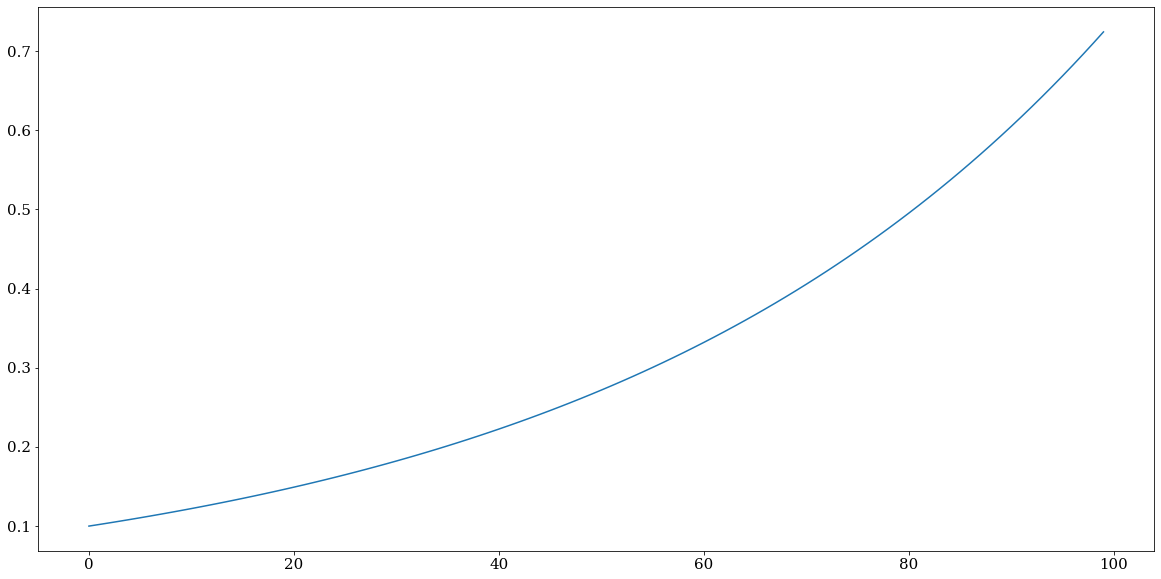

In [75]:
plt.plot(y[:100])

In [11]:
global_best = fluxo_de_pot_q(gbest.reshape(1,-1),sep_atualizado)

NameError: name 'gbest' is not defined

In [21]:
gbest

array([[1.05000000e+00, 1.01762009e+00, 1.04905237e+00, 1.04160457e+00,
        1.03350248e+00, 1.04465436e+00, 1.03868394e+00, 1.03731394e+00,
        1.03967820e+00, 1.03585300e+00, 1.04212857e+00, 1.05000000e+00,
        1.05000000e+00, 1.03541780e+00, 1.03103703e+00, 1.03392026e+00,
        1.04699303e+00, 1.04512806e+00, 1.02569731e+00, 1.02755107e+00,
        1.03678341e+00, 1.05000000e+00, 1.02908472e+00, 1.02802447e+00,
        1.02804044e+00, 1.05000000e+00, 1.05000000e+00, 1.04593017e+00,
        1.05000000e+00, 1.05000000e+00, 1.02792247e+00, 1.03206435e+00,
        1.02747853e+00, 1.00965510e+00, 9.93746184e-01, 1.03571377e+00,
        1.05000000e+00, 1.04249680e+00, 1.05000000e+00, 1.05000000e+00,
        1.03335178e+00, 1.03794500e+00, 1.03894829e+00, 1.04511066e+00,
        1.05000000e+00, 1.04182612e+00, 1.03178093e+00, 1.02945423e+00,
        1.01628916e+00, 1.02594972e+00, 1.03394661e+00, 1.01022924e+00,
        1.04675542e+00, 1.04972179e+00, 9.85000000e-01, 1.060000

In [68]:
validacao(sep_atualizado,gbest.ravel())

Perdas de Potência Ativa [PU]:

1.1773870489962943
 
Penalização de Violação de Tensão [PU]:

1.5773759390514958e-06
 
Penalização de Violação de Geração de Reativo [PU]:

0.004939037583684244
 
Penalização de Violação de TAP Discreto [PU]:

6.000000000000046
 
Penalização de Violação de Bshunt Discreto [PU]:

1.9517278719840494e-27
 


In [12]:
sep_14.res_bus['q_mvar'].sort_index()

0     16.549300
1    -30.857100
2     -6.075348
3     -3.900000
4      1.600000
5     -5.230945
6      0.000000
7    -17.623452
8     -4.584844
9      5.800000
10     1.800000
11     1.600000
12     5.800000
13     5.000000
Name: q_mvar, dtype: float64

In [64]:
fitness(global_best.reshape(1,-1),100,100,0,0)[0]

array([1.05000000e+00, 1.01101761e+00, 1.05000000e+00, 1.03732324e+00,
       1.03050884e+00, 1.03971432e+00, 1.03209015e+00, 1.03214124e+00,
       1.03687297e+00, 1.03134014e+00, 1.03817631e+00, 1.05000000e+00,
       1.05000000e+00, 1.03028496e+00, 1.02408478e+00, 1.02910501e+00,
       1.04789356e+00, 1.04510048e+00, 1.02522465e+00, 1.02253118e+00,
       1.03184538e+00, 1.05000000e+00, 1.02591088e+00, 1.02333270e+00,
       1.02454493e+00, 1.05000000e+00, 1.05000000e+00, 1.04148005e+00,
       1.05000000e+00, 1.05000000e+00, 1.02346792e+00, 1.02488438e+00,
       1.02431796e+00, 1.00331818e+00, 9.89834434e-01, 1.03183976e+00,
       1.05000000e+00, 1.04029858e+00, 1.05000000e+00, 1.05000000e+00,
       1.02563455e+00, 1.03561483e+00, 1.03592280e+00, 1.03719202e+00,
       1.05000000e+00, 1.04405702e+00, 1.02670552e+00, 1.02672252e+00,
       1.01145149e+00, 1.02273517e+00, 1.03448117e+00, 1.00496661e+00,
       1.04388024e+00, 1.05000000e+00, 9.75557540e-01, 1.04978501e+00,
      

In [65]:
validacao_q(sep_118,global_best)

Perdas de Potência Ativa [PU]:

1.2922713857775967
 
Penalização de Violação de Tensão [PU]:

0.00017106770400889746
 
Penalização de Violação de Geração de Reativo [PU]:

7.808864611396346e-16
 
Penalização de Violação de TAP Discreto [PU]:

4.925008528337948
 
Penalização de Violação de Bshunt Discreto [PU]:

1.4763414495954013
 


In [108]:
validacao(sep_atualizado,gbest)

Perdas de Potência Ativa [PU]:

1.1773870489962943
 
Penalização de Violação de Tensão [PU]:

1.5773759390514958e-06
 
Penalização de Violação de Geração de Reativo [PU]:

0.004939037583684244
 
Penalização de Violação de TAP Discreto [PU]:

6.000000000000046
 
Penalização de Violação de Bshunt Discreto [PU]:

1.9517278719840494e-27
 


In [104]:
b = np.copy(sep_atualizado.res_bus['vm_pu'].sort_index().to_numpy())
theta  = np.copy(sep_atualizado.res_bus['va_degree'].sort_index().to_numpy())
sh  = np.copy(sep_atualizado.shunt['q_mvar'].sort_index().to_numpy())
q_gen = np.copy(sep_atualizado.res_gen['q_mvar'].sort_index().to_numpy())
q0 = np.copy(sep_atualizado.res_ext_grid['q_mvar'].sort_index().to_numpy())
p0 = np.copy(sep_atualizado.res_ext_grid['p_mw'].sort_index().to_numpy())

In [105]:
sep_atualizado.res_bus['vm_pu'].sort_index().iloc[:] = b
sep_atualizado.res_bus['va_degree'].sort_index().iloc[:] = theta
sep_atualizado.res_ext_grid['p_mw'] = p0
sep_atualizado.res_ext_grid['q_mvar'] = q0
sep_atualizado.res_gen['q_mvar'] = q_gen
sep_atualizado.shunt['q_mvar'] = sh


In [106]:
sh

array([ -0.,  -0.,  -0., -10., -10., -10.,  -0., -12., -20., -10., -20.,
       -20., -20., -20.])

In [8]:
sep_300.res_line['pl_mw'].sum()+sep_300.res_trafo['pl_mw'].sum()

408.2249250139281

In [19]:
a = []

a.append(global_best[-4])
a.append(global_best[-5])

In [21]:
max(a)

0.17097458599173665

In [18]:
np.max(global_best[-4],global_best[-5])

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [4]:
a = [1]

In [9]:
float(a)

TypeError: float() argument must be a string or a number, not 'list'

In [10]:
float(b)

1.0

In [10]:
sep_300.load['p_mw'].sum()/100

238.47650000000002

In [11]:
sep_300.load['q_mvar'].sum()/100

77.07600000000001

In [6]:
len(cria_enxame(sep_300,1)[0])

166

In [8]:
len(sep_300.trafo)

128

In [20]:
a = sep_300.trafo['tap_pos'].values

a

array([ 1., -1., nan,  1., nan, -1., nan,  1.,  1.,  1.,  1., -1., nan,
       nan, nan, nan, -1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, -1., -1., -1., -1., -1., -1., nan, nan, nan, nan, nan, nan,
       nan, -1., nan, nan, nan, nan, nan, -1., nan, nan, nan, nan,  1.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, -1., nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan,  1., nan, nan, -1., -1.,
       -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.,  1., nan,
       -1.,  1., nan, nan,  1., nan, nan,  1., -1.,  1.,  1., nan,  1.,
        1.,  1., nan, -1., nan,  1., -1., nan,  1.,  1.,  1.,  1., -1.,
       nan, -1., -1.,  1.,  1.,  1., -1., nan,  1.,  1.,  1.])

In [13]:
(np.random.randn(len(global_best)))*0.1*0.1

NameError: name 'global_best' is not defined

In [42]:
a = cria_enxame(sep_14,10)

In [19]:
np.log(0.0)

11.512925464970229

In [10]:
validacao(sep_118,global_best)

Perdas de Potência Ativa [PU]:

1.348863648732933
 
Penalização de Violação de Tensão [PU]:

0.0
 
Penalização de Violação de Geração de Reativo [PU]:

0.4433173104554004
 
Penalização de Violação de TAP Discreto [PU]:

5.784911289237865
 
Penalização de Violação de Bshunt Discreto [PU]:

8.018705474409654
 


In [26]:
sep_118.res_gen['q_mvar'].to_numpy()> sep_118.gen['min_q_mvar'].to_numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True])

In [27]:
sep_118.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar
0,0,True,True,None,0.0,1.0,NaN,None,0.996322,False,100.0,0.0,15.0,-5.0
1,3,True,True,None,0.0,1.0,NaN,None,0.991986,False,100.0,0.0,300.0,-300.0
2,5,True,True,None,0.0,1.0,NaN,None,0.986588,False,100.0,0.0,50.0,-13.0
3,7,True,True,None,0.0,1.0,NaN,None,0.993352,False,100.0,0.0,300.0,-300.0
4,9,True,True,None,450.0,1.0,NaN,None,1.007066,False,550.0,0.0,200.0,-147.0
5,11,True,True,None,85.0,1.0,NaN,None,1.003688,False,185.0,0.0,120.0,-35.0
6,14,True,True,None,0.0,1.0,NaN,None,1.001250,False,100.0,0.0,30.0,-10.0
7,17,True,True,None,0.0,1.0,NaN,None,1.010986,False,100.0,0.0,50.0,-16.0
8,18,True,True,None,0.0,1.0,NaN,None,1.000124,False,100.0,0.0,24.0,-8.0
9,23,True,True,None,0.0,1.0,NaN,None,1.017339,False,100.0,0.0,300.0,-300.0


In [32]:
sep_118.res_gen['q_mvar'].sum() + sep_118.res_ext_grid['q_mvar'].sum() - sep_118.res_shunt['q_mvar'].sum() - sep_118.res_sgen['q_mvar'].sum()

889.6739792987806

In [30]:
sep_118.load['q_mvar'].sum()

1438.0

In [31]:
sep_118.load['q_mvar']

0     27.0
1      9.0
10     1.0
11    30.0
12    10.0
      ... 
94     3.0
95     7.0
96     0.0
97     8.0
98    15.0
Name: q_mvar, Length: 99, dtype: float64

In [2]:
sep_118.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,4,None,40.0,0.0,138.0,1,1,True
1,33,None,-14.0,0.0,138.0,1,1,True
10,82,None,-10.0,0.0,138.0,1,1,True
11,104,None,-20.0,0.0,138.0,1,1,True
12,106,None,-6.0,0.0,138.0,1,1,True
13,109,None,-6.0,0.0,138.0,1,1,True
2,36,None,25.0,0.0,138.0,1,1,True
3,43,None,-10.0,0.0,138.0,1,1,True
4,44,None,-10.0,0.0,138.0,1,1,True
5,45,None,-10.0,0.0,138.0,1,1,True


In [13]:
sep_atualizado.gen

,bus,controllable,in_service,name,p_mw,scaling,sn_mva,type,vm_pu,slack,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,min_vm_pu,max_vm_pu
0,0,True,True,None,0.0,1.0,NaN,None,0.975732,False,100.0,0.0,15.0,-5.0,0.94,1.06
1,3,True,True,None,0.0,1.0,NaN,None,1.013623,False,100.0,0.0,300.0,-300.0,0.94,1.06
2,5,True,True,None,0.0,1.0,NaN,None,1.000928,False,100.0,0.0,50.0,-13.0,0.94,1.06
3,7,True,True,None,0.0,1.0,NaN,None,0.999028,False,100.0,0.0,300.0,-300.0,0.94,1.06
4,9,True,True,None,450.0,1.0,NaN,None,1.007385,False,550.0,0.0,200.0,-147.0,0.94,1.06
5,11,True,True,None,85.0,1.0,NaN,None,0.986634,False,185.0,0.0,120.0,-35.0,0.94,1.06
6,14,True,True,None,0.0,1.0,NaN,None,1.002132,False,100.0,0.0,30.0,-10.0,0.94,1.06
7,17,True,True,None,0.0,1.0,NaN,None,1.007726,False,100.0,0.0,50.0,-16.0,0.94,1.06
8,18,True,True,None,0.0,1.0,NaN,None,0.996913,False,100.0,0.0,24.0,-8.0,0.94,1.06
9,23,True,True,None,0.0,1.0,NaN,None,1.023592,False,100.0,0.0,300.0,-300.0,0.94,1.06


In [16]:
len(sep_300.trafo)

128

In [20]:
len(sep_300.trafo[~pd.isnull(sep_300.trafo['tap_pos'])])

62

In [19]:
sep_14.trafo

,df,hv_bus,i0_percent,in_service,lv_bus,max_loading_percent,name,parallel,pfe_kw,shift_degree,...,tap_min,tap_phase_shifter,tap_pos,tap_side,tap_step_degree,tap_step_percent,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent
0,1.0,3,0.0,True,6,100.0,None,1,0.0,0.0,...,NaN,False,0.929483,hv,NaN,2.2,135.0,14.000,2070.288,0.0
1,1.0,3,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,-2.684505,hv,NaN,3.1,135.0,0.208,5506.182,0.0
2,1.0,4,0.0,True,5,100.0,None,1,0.0,0.0,...,NaN,False,0.058717,hv,NaN,6.8,135.0,0.208,2494.998,0.0
3,1.0,6,0.0,True,7,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,12.000,1743.885,0.0
4,1.0,6,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,0.208,1089.099,0.0


In [10]:
sep_14.

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,8,None,-19.0,0.0,0.208,1,1,True


In [154]:
sep_118

This pandapower network includes the following parameter tables:
   - bus (118 elements)
   - load (99 elements)
   - gen (53 elements)
   - shunt (14 elements)
   - ext_grid (1 element)
   - line (173 elements)
   - trafo (13 elements)
   - poly_cost (54 elements)
   - bus_geodata (118 elements)
 and the following results tables:
   - res_bus (118 elements)
   - res_line (173 elements)
   - res_trafo (13 elements)
   - res_ext_grid (1 element)
   - res_load (99 elements)
   - res_shunt (14 elements)
   - res_gen (53 elements)

In [14]:
sep_30.trafo

,df,hv_bus,i0_percent,in_service,lv_bus,max_loading_percent,name,parallel,pfe_kw,shift_degree,...,tap_min,tap_phase_shifter,tap_pos,tap_side,tap_step_degree,tap_step_percent,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent
0,1.0,5,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,2.2,132.0,1.0,20.799792,0.0
1,1.0,5,0.0,True,9,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,3.1,132.0,33.0,55.599444,0.0
2,1.0,10,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,11.0,1.0,20.799792,0.0
3,1.0,9,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,33.0,1.0,10.999890,0.0
4,1.0,3,0.0,True,11,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,6.8,132.0,33.0,25.599744,0.0
5,1.0,11,0.0,True,12,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,33.0,11.0,13.999860,0.0
6,1.0,27,0.0,True,26,100.0,None,1,0.0,0.0,...,NaN,False,-1.0,hv,NaN,3.2,132.0,33.0,39.599604,0.0


In [ ]:
9 e 23  ------- 0,1,4,6